# AE Experimentation

## Imports and Constants

In [1]:
import sys
import os

# Füge das übergeordnete Verzeichnis zu sys.path hinzu
parent_dir = os.path.abspath(os.path.join(os.getcwd(), '../../'))
sys.path.insert(0, parent_dir)

In [2]:
import pandas as pd
from pathlib import Path
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
import random

import torch
import torch.nn as nn
from torch.utils.data import DataLoader
import seaborn as sns
import torch.nn.functional as F
from copy import deepcopy as dc

from utilities import split_data_into_sequences, train_test_split, load_sequential_time_series, reconstruct_sequential_data, Scaler, extract_features_and_targets_reg
from data_evaluation.predictive.TimeSeriesDataset import TimeSeriesDataset
from AE import LSTMAE, FCAE, train_autoencoder

In [3]:
DATA_FOLDER = Path("../../data")
REAL_DATA_FOLDER = DATA_FOLDER / "real"
SYNTHETIC_DATA_FOLDER = DATA_FOLDER / "synthetic"
BENCHMARK = False
TEST_EXISTING_MODEL = False

In [4]:
model_name = "LSTM_AE"
hyperparameters = {
    "seq_len": 12,
    "lr": 0.0001,
    "batch_size": 32,
    "num_epochs": 1000,
    "device": 'cuda' if torch.cuda.is_available() else 'cpu'
}

## Data

In [5]:
traffic_df = pd.read_csv(REAL_DATA_FOLDER / "metro_interstate_traffic_volume_label_encoded_no_categorical.csv")
traffic_df.shape

(28511, 5)

In [6]:
traffic_np = traffic_df.to_numpy()
traffic_np.shape

(28511, 5)

### Preprocessing

In [7]:
# Train test split
train, test = train_test_split(traffic_np, split_ratio=0.8)
test, val = train_test_split(test, split_ratio=0.5)

In [8]:
# scale data
scaler = Scaler(train)
train_scaled = scaler.scale_data(train)
val_scaled = scaler.scale_data(val)
test_scaled = scaler.scale_data(test)

In [9]:
# split data into sequences
train_seq_scaled = split_data_into_sequences(train_scaled, hyperparameters['seq_len'], shuffle_data=False)
val_seq_scaled = split_data_into_sequences(val_scaled, hyperparameters['seq_len'], shuffle_data=False)
test_seq_scaled = split_data_into_sequences(test_scaled, hyperparameters['seq_len'], shuffle_data=False)

Shape of the data after splitting into sequences: (22797, 12, 5)
Shape of the data after splitting into sequences: (2841, 12, 5)
Shape of the data after splitting into sequences: (2840, 12, 5)


In [10]:
# create datasets
# NOTE: The targets are not used in the training process, but are required by the PyTorch Dataset class
train_dataset = TimeSeriesDataset(train_seq_scaled, np.zeros((train_seq_scaled.shape[0], 1)))
val_dataset = TimeSeriesDataset(val_seq_scaled, np.zeros((val_seq_scaled.shape[0], 1)))
test_dataset = TimeSeriesDataset(test_seq_scaled, np.zeros((test_seq_scaled.shape[0], 1)))

In [11]:
# create DataLoaders
train_loader = DataLoader(train_dataset, batch_size=hyperparameters['batch_size'], shuffle=False)
val_loader = DataLoader(val_dataset, batch_size=hyperparameters['batch_size'], shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=hyperparameters['batch_size'], shuffle=True)

In [12]:
X_train, y = next(iter(train_loader))

## Autoencoder

In [13]:
if model_name == "LSTM_AE":
    model = LSTMAE().to(hyperparameters['device'])
elif model_name == "FCAE":
    model = FCAE(verbose=False).to(hyperparameters['device'])

In [14]:
if False:
    test_sample = train_seq_scaled[:32]
    
    model.eval()
    with torch.inference_mode():
        pred = model(torch.tensor(test_sample, dtype=torch.float32).to(hyperparameters['device']))
        print(pred.shape)

## Training

In [15]:
optimizer = torch.optim.Adam(params=model.parameters(), lr=hyperparameters['lr'])
criterion = nn.L1Loss()

  0%|          | 1/1000 [00:01<27:19,  1.64s/it]

Epoch: 0 
 Train Loss: 0.22934899086244978 
 Val Loss: 0.2231960470756788
**************************************************


  0%|          | 2/1000 [00:03<26:23,  1.59s/it]

Epoch: 1 
 Train Loss: 0.19068493680482493 
 Val Loss: 0.21604998962263042
**************************************************


  0%|          | 3/1000 [00:04<26:25,  1.59s/it]

Epoch: 2 
 Train Loss: 0.19066140964773562 
 Val Loss: 0.2139906802873933
**************************************************


  0%|          | 4/1000 [00:06<26:21,  1.59s/it]

Epoch: 3 
 Train Loss: 0.19053603448548456 
 Val Loss: 0.21294867088285724
**************************************************


  0%|          | 5/1000 [00:07<26:29,  1.60s/it]

Epoch: 4 
 Train Loss: 0.19028374432556092 
 Val Loss: 0.2122885872808735
**************************************************


  1%|          | 6/1000 [00:09<26:29,  1.60s/it]

Epoch: 5 
 Train Loss: 0.18993036106207928 
 Val Loss: 0.2118469550368491
**************************************************


  1%|          | 7/1000 [00:11<26:27,  1.60s/it]

INFO: Validation loss did not improve in epoch 7
Epoch: 6 
 Train Loss: 0.18929849775066548 
 Val Loss: 0.21223105858550984
**************************************************


  1%|          | 8/1000 [00:12<26:47,  1.62s/it]

INFO: Validation loss did not improve in epoch 8
Epoch: 7 
 Train Loss: 0.18827193186502136 
 Val Loss: 0.21236856080842823
**************************************************


  1%|          | 9/1000 [00:14<26:38,  1.61s/it]

INFO: Validation loss did not improve in epoch 9
Epoch: 8 
 Train Loss: 0.18732849260867895 
 Val Loss: 0.21221525582034936
**************************************************


  1%|          | 10/1000 [00:15<26:13,  1.59s/it]

INFO: Validation loss did not improve in epoch 10
Epoch: 9 
 Train Loss: 0.18611566892721876 
 Val Loss: 0.21208876086754747
**************************************************


  1%|          | 11/1000 [00:17<25:57,  1.57s/it]

Epoch: 10 
 Train Loss: 0.18464524537157712 
 Val Loss: 0.21174234269040354
**************************************************


  1%|          | 12/1000 [00:19<25:45,  1.56s/it]

INFO: Validation loss did not improve in epoch 12
Epoch: 11 
 Train Loss: 0.18248513477840062 
 Val Loss: 0.21223622074957643
**************************************************


  1%|▏         | 13/1000 [00:20<25:47,  1.57s/it]

Epoch: 12 
 Train Loss: 0.17956845065236593 
 Val Loss: 0.20866747903689908
**************************************************


  1%|▏         | 14/1000 [00:22<25:34,  1.56s/it]

Epoch: 13 
 Train Loss: 0.1765328554794464 
 Val Loss: 0.2016557761457529
**************************************************


  2%|▏         | 15/1000 [00:23<25:29,  1.55s/it]

Epoch: 14 
 Train Loss: 0.17427048052636304 
 Val Loss: 0.18918972922844834
**************************************************


  2%|▏         | 16/1000 [00:25<25:50,  1.58s/it]

Epoch: 15 
 Train Loss: 0.17256147154250284 
 Val Loss: 0.17801069007830672
**************************************************


  2%|▏         | 17/1000 [00:27<26:15,  1.60s/it]

Epoch: 16 
 Train Loss: 0.17172944199863358 
 Val Loss: 0.17433082153288165
**************************************************


  2%|▏         | 18/1000 [00:28<25:58,  1.59s/it]

Epoch: 17 
 Train Loss: 0.17142632714411318 
 Val Loss: 0.17378848590207904
**************************************************


  2%|▏         | 19/1000 [00:30<25:43,  1.57s/it]

Epoch: 18 
 Train Loss: 0.1712584948431058 
 Val Loss: 0.17365769388970365
**************************************************


  2%|▏         | 20/1000 [00:31<25:55,  1.59s/it]

INFO: Validation loss did not improve in epoch 20
Epoch: 19 
 Train Loss: 0.1711182535676936 
 Val Loss: 0.17367506378822112
**************************************************


  2%|▏         | 21/1000 [00:33<25:36,  1.57s/it]

INFO: Validation loss did not improve in epoch 21
Epoch: 20 
 Train Loss: 0.17098920665900805 
 Val Loss: 0.1737730534893743
**************************************************


  2%|▏         | 22/1000 [00:34<25:28,  1.56s/it]

INFO: Validation loss did not improve in epoch 22
Epoch: 21 
 Train Loss: 0.17086503151046611 
 Val Loss: 0.17391930470305883
**************************************************


  2%|▏         | 23/1000 [00:36<25:18,  1.55s/it]

INFO: Validation loss did not improve in epoch 23
Epoch: 22 
 Train Loss: 0.1707463812965999 
 Val Loss: 0.1738994371020392
**************************************************


  2%|▏         | 24/1000 [00:37<25:26,  1.56s/it]

INFO: Validation loss did not improve in epoch 24
Epoch: 23 
 Train Loss: 0.17063132826066452 
 Val Loss: 0.17381790548228146
**************************************************


  2%|▎         | 25/1000 [00:39<25:20,  1.56s/it]

Epoch: 24 
 Train Loss: 0.1705188565844406 
 Val Loss: 0.17364142801654472
**************************************************


  3%|▎         | 26/1000 [00:41<25:11,  1.55s/it]

Epoch: 25 
 Train Loss: 0.17041084541303078 
 Val Loss: 0.173411915141545
**************************************************


  3%|▎         | 27/1000 [00:42<25:28,  1.57s/it]

Epoch: 26 
 Train Loss: 0.17030788920454024 
 Val Loss: 0.17321461422389814
**************************************************


  3%|▎         | 28/1000 [00:44<25:40,  1.58s/it]

Epoch: 27 
 Train Loss: 0.1702092123671133 
 Val Loss: 0.17298939187874954
**************************************************


  3%|▎         | 29/1000 [00:45<25:47,  1.59s/it]

Epoch: 28 
 Train Loss: 0.17011729742793516 
 Val Loss: 0.1727631331494685
**************************************************


  3%|▎         | 30/1000 [00:47<25:57,  1.61s/it]

Epoch: 29 
 Train Loss: 0.170027521975746 
 Val Loss: 0.17254857618487282
**************************************************


  3%|▎         | 31/1000 [00:49<25:56,  1.61s/it]

Epoch: 30 
 Train Loss: 0.16993961373519095 
 Val Loss: 0.17233953097563112
**************************************************


  3%|▎         | 32/1000 [00:50<25:36,  1.59s/it]

Epoch: 31 
 Train Loss: 0.16984941155178182 
 Val Loss: 0.17214971044090357
**************************************************


  3%|▎         | 33/1000 [00:52<25:19,  1.57s/it]

Epoch: 32 
 Train Loss: 0.16975172409503023 
 Val Loss: 0.17197379988900732
**************************************************


  3%|▎         | 34/1000 [00:53<25:39,  1.59s/it]

Epoch: 33 
 Train Loss: 0.16963891516770085 
 Val Loss: 0.17180848858329686
**************************************************


  4%|▎         | 35/1000 [00:55<25:44,  1.60s/it]

Epoch: 34 
 Train Loss: 0.1695029361782201 
 Val Loss: 0.17161557580647843
**************************************************


  4%|▎         | 36/1000 [00:57<25:47,  1.60s/it]

Epoch: 35 
 Train Loss: 0.16932200535943764 
 Val Loss: 0.17142955389585388
**************************************************


  4%|▎         | 37/1000 [00:58<25:49,  1.61s/it]

Epoch: 36 
 Train Loss: 0.16905538120201224 
 Val Loss: 0.17121723377972506
**************************************************


  4%|▍         | 38/1000 [01:00<25:51,  1.61s/it]

Epoch: 37 
 Train Loss: 0.16851660881980438 
 Val Loss: 0.16939206806461463
**************************************************


  4%|▍         | 39/1000 [01:01<25:47,  1.61s/it]

Epoch: 38 
 Train Loss: 0.1627505952897279 
 Val Loss: 0.16220650713095505
**************************************************


  4%|▍         | 40/1000 [01:03<25:51,  1.62s/it]

Epoch: 39 
 Train Loss: 0.15750134273381253 
 Val Loss: 0.15855051300833733
**************************************************


  4%|▍         | 41/1000 [01:05<26:11,  1.64s/it]

Epoch: 40 
 Train Loss: 0.15451844488002808 
 Val Loss: 0.15641897456364684
**************************************************


  4%|▍         | 42/1000 [01:06<25:52,  1.62s/it]

Epoch: 41 
 Train Loss: 0.15347091915271394 
 Val Loss: 0.1557632259438547
**************************************************


  4%|▍         | 43/1000 [01:08<25:35,  1.60s/it]

Epoch: 42 
 Train Loss: 0.1528936856404093 
 Val Loss: 0.15523682233322872
**************************************************


  4%|▍         | 44/1000 [01:10<25:49,  1.62s/it]

Epoch: 43 
 Train Loss: 0.1524552862469478 
 Val Loss: 0.15488385208202213
**************************************************


  4%|▍         | 45/1000 [01:11<26:01,  1.63s/it]

Epoch: 44 
 Train Loss: 0.15206504488810582 
 Val Loss: 0.1546742846624235
**************************************************


  5%|▍         | 46/1000 [01:13<26:02,  1.64s/it]

Epoch: 45 
 Train Loss: 0.1516549541584907 
 Val Loss: 0.15457520583707296
**************************************************


  5%|▍         | 47/1000 [01:14<26:10,  1.65s/it]

Epoch: 46 
 Train Loss: 0.15113943178849334 
 Val Loss: 0.15453907763690092
**************************************************


  5%|▍         | 48/1000 [01:16<26:28,  1.67s/it]

INFO: Validation loss did not improve in epoch 48
Epoch: 47 
 Train Loss: 0.1503885169245752 
 Val Loss: 0.15462194533830279
**************************************************


  5%|▍         | 49/1000 [01:18<26:23,  1.67s/it]

INFO: Validation loss did not improve in epoch 49
Epoch: 48 
 Train Loss: 0.14901769983609628 
 Val Loss: 0.15519132423266935
**************************************************


  5%|▌         | 50/1000 [01:20<26:33,  1.68s/it]

Epoch: 49 
 Train Loss: 0.1453605866762398 
 Val Loss: 0.15257280286443367
**************************************************


  5%|▌         | 51/1000 [01:21<26:47,  1.69s/it]

INFO: Validation loss did not improve in epoch 51
Epoch: 50 
 Train Loss: 0.14174513928435462 
 Val Loss: 0.1527026268036178
**************************************************


  5%|▌         | 52/1000 [01:23<26:43,  1.69s/it]

Epoch: 51 
 Train Loss: 0.13838798711585798 
 Val Loss: 0.1491767279385181
**************************************************


  5%|▌         | 53/1000 [01:25<26:38,  1.69s/it]

Epoch: 52 
 Train Loss: 0.13123477388272614 
 Val Loss: 0.1457357347178995
**************************************************


  5%|▌         | 54/1000 [01:26<26:39,  1.69s/it]

Epoch: 53 
 Train Loss: 0.12790238158189565 
 Val Loss: 0.14448540858673245
**************************************************


  6%|▌         | 55/1000 [01:28<26:20,  1.67s/it]

Epoch: 54 
 Train Loss: 0.1270259705386523 
 Val Loss: 0.14277791650442595
**************************************************


  6%|▌         | 56/1000 [01:30<26:13,  1.67s/it]

Epoch: 55 
 Train Loss: 0.1264600143212757 
 Val Loss: 0.14122599999556382
**************************************************


  6%|▌         | 57/1000 [01:31<26:21,  1.68s/it]

Epoch: 56 
 Train Loss: 0.12600752821017114 
 Val Loss: 0.1397201878468642
**************************************************


  6%|▌         | 58/1000 [01:33<26:31,  1.69s/it]

Epoch: 57 
 Train Loss: 0.1256247268621333 
 Val Loss: 0.1385051202070847
**************************************************


  6%|▌         | 59/1000 [01:35<26:42,  1.70s/it]

Epoch: 58 
 Train Loss: 0.1252972727633626 
 Val Loss: 0.13757742648379187
**************************************************


  6%|▌         | 60/1000 [01:36<26:31,  1.69s/it]

Epoch: 59 
 Train Loss: 0.12501652063318588 
 Val Loss: 0.1368750035762787
**************************************************


  6%|▌         | 61/1000 [01:38<26:45,  1.71s/it]

Epoch: 60 
 Train Loss: 0.1247722161110872 
 Val Loss: 0.13630648141496637
**************************************************


  6%|▌         | 62/1000 [01:40<26:37,  1.70s/it]

Epoch: 61 
 Train Loss: 0.12454670008799638 
 Val Loss: 0.13580390626794836
**************************************************


  6%|▋         | 63/1000 [01:42<26:20,  1.69s/it]

Epoch: 62 
 Train Loss: 0.12434707405398303 
 Val Loss: 0.13539282056722748
**************************************************


  6%|▋         | 64/1000 [01:43<26:40,  1.71s/it]

Epoch: 63 
 Train Loss: 0.12416523346497167 
 Val Loss: 0.13505241609691235
**************************************************


  6%|▋         | 65/1000 [01:45<26:52,  1.72s/it]

Epoch: 64 
 Train Loss: 0.12399907085684038 
 Val Loss: 0.13477425051204275
**************************************************


  7%|▋         | 66/1000 [01:47<27:05,  1.74s/it]

Epoch: 65 
 Train Loss: 0.12384884110632317 
 Val Loss: 0.13454762938317288
**************************************************


  7%|▋         | 67/1000 [01:49<27:20,  1.76s/it]

Epoch: 66 
 Train Loss: 0.12371026398548739 
 Val Loss: 0.13437506958339993
**************************************************


  7%|▋         | 68/1000 [01:50<26:57,  1.73s/it]

Epoch: 67 
 Train Loss: 0.12358437807705426 
 Val Loss: 0.13423000962546702
**************************************************


  7%|▋         | 69/1000 [01:52<26:37,  1.72s/it]

Epoch: 68 
 Train Loss: 0.1234633122501584 
 Val Loss: 0.13411409458082713
**************************************************


  7%|▋         | 70/1000 [01:54<26:38,  1.72s/it]

Epoch: 69 
 Train Loss: 0.12334602947384746 
 Val Loss: 0.13402482950955294
**************************************************


  7%|▋         | 71/1000 [01:55<26:40,  1.72s/it]

Epoch: 70 
 Train Loss: 0.12322063466108196 
 Val Loss: 0.13392411883962288
**************************************************


  7%|▋         | 72/1000 [01:57<26:39,  1.72s/it]

Epoch: 71 
 Train Loss: 0.12309465707811366 
 Val Loss: 0.13384922953803888
**************************************************


  7%|▋         | 73/1000 [01:59<26:27,  1.71s/it]

Epoch: 72 
 Train Loss: 0.12169741053358869 
 Val Loss: 0.12986376161655683
**************************************************


  7%|▋         | 74/1000 [02:01<26:49,  1.74s/it]

Epoch: 73 
 Train Loss: 0.11909984823363359 
 Val Loss: 0.1297411916965849
**************************************************


  8%|▊         | 75/1000 [02:02<26:36,  1.73s/it]

Epoch: 74 
 Train Loss: 0.11893824160328921 
 Val Loss: 0.12961281099346247
**************************************************


  8%|▊         | 76/1000 [02:04<26:29,  1.72s/it]

Epoch: 75 
 Train Loss: 0.11878694439251995 
 Val Loss: 0.1294782314909978
**************************************************


  8%|▊         | 77/1000 [02:06<27:10,  1.77s/it]

Epoch: 76 
 Train Loss: 0.11864661038716076 
 Val Loss: 0.12932281706775173
**************************************************


  8%|▊         | 78/1000 [02:08<26:59,  1.76s/it]

Epoch: 77 
 Train Loss: 0.11431595038878634 
 Val Loss: 0.11884876407599182
**************************************************


  8%|▊         | 79/1000 [02:09<27:07,  1.77s/it]

Epoch: 78 
 Train Loss: 0.10926970549000932 
 Val Loss: 0.118058560437031
**************************************************


  8%|▊         | 80/1000 [02:11<27:06,  1.77s/it]

Epoch: 79 
 Train Loss: 0.10898070109467353 
 Val Loss: 0.1174915713373195
**************************************************


  8%|▊         | 81/1000 [02:13<27:24,  1.79s/it]

Epoch: 80 
 Train Loss: 0.10870343190715824 
 Val Loss: 0.11708556969514054
**************************************************


  8%|▊         | 82/1000 [02:15<27:00,  1.77s/it]

Epoch: 81 
 Train Loss: 0.10837786033394294 
 Val Loss: 0.11690797640031643
**************************************************


  8%|▊         | 83/1000 [02:17<26:41,  1.75s/it]

INFO: Validation loss did not improve in epoch 83
Epoch: 82 
 Train Loss: 0.1078889036203668 
 Val Loss: 0.11728043644950631
**************************************************


  8%|▊         | 84/1000 [02:18<26:55,  1.76s/it]

INFO: Validation loss did not improve in epoch 84
Epoch: 83 
 Train Loss: 0.10720759456739519 
 Val Loss: 0.11795917772844935
**************************************************


  8%|▊         | 85/1000 [02:20<26:57,  1.77s/it]

INFO: Validation loss did not improve in epoch 85
Epoch: 84 
 Train Loss: 0.10621379439681142 
 Val Loss: 0.11933941611748063
**************************************************


  9%|▊         | 86/1000 [02:22<26:56,  1.77s/it]

INFO: Validation loss did not improve in epoch 86
Epoch: 85 
 Train Loss: 0.10485781483655224 
 Val Loss: 0.12154751497038295
**************************************************


  9%|▊         | 87/1000 [02:24<26:54,  1.77s/it]

INFO: Validation loss did not improve in epoch 87
Epoch: 86 
 Train Loss: 0.10362929969419939 
 Val Loss: 0.12166645436474446
**************************************************


  9%|▉         | 88/1000 [02:25<26:38,  1.75s/it]

INFO: Validation loss did not improve in epoch 88
Epoch: 87 
 Train Loss: 0.102640937047202 
 Val Loss: 0.12081212198801256
**************************************************


  9%|▉         | 89/1000 [02:27<26:51,  1.77s/it]

INFO: Validation loss did not improve in epoch 89
Epoch: 88 
 Train Loss: 0.10178247560207505 
 Val Loss: 0.1193267163935672
**************************************************


  9%|▉         | 90/1000 [02:29<26:55,  1.78s/it]

INFO: Validation loss did not improve in epoch 90
Epoch: 89 
 Train Loss: 0.101014280924247 
 Val Loss: 0.11845837952045912
**************************************************


  9%|▉         | 91/1000 [02:31<26:34,  1.75s/it]

INFO: Validation loss did not improve in epoch 91
Epoch: 90 
 Train Loss: 0.10032463731011702 
 Val Loss: 0.11725972115658642
**************************************************


  9%|▉         | 92/1000 [02:32<26:18,  1.74s/it]

Epoch: 91 
 Train Loss: 0.09972886446482002 
 Val Loss: 0.11560410395097197
**************************************************


  9%|▉         | 93/1000 [02:34<26:09,  1.73s/it]

Epoch: 92 
 Train Loss: 0.09923141312277334 
 Val Loss: 0.11377659532126416
**************************************************


  9%|▉         | 94/1000 [02:36<26:03,  1.73s/it]

Epoch: 93 
 Train Loss: 0.09881057941353505 
 Val Loss: 0.11212260460250834
**************************************************


 10%|▉         | 95/1000 [02:38<26:28,  1.76s/it]

Epoch: 94 
 Train Loss: 0.09845495172795875 
 Val Loss: 0.1107512308975284
**************************************************


 10%|▉         | 96/1000 [02:39<26:39,  1.77s/it]

Epoch: 95 
 Train Loss: 0.09814820510725822 
 Val Loss: 0.10956619931070992
**************************************************


 10%|▉         | 97/1000 [02:41<26:30,  1.76s/it]

Epoch: 96 
 Train Loss: 0.09787884098053146 
 Val Loss: 0.1087235850229692
**************************************************


 10%|▉         | 98/1000 [02:43<26:29,  1.76s/it]

Epoch: 97 
 Train Loss: 0.09765062632684454 
 Val Loss: 0.10798281313997976
**************************************************


 10%|▉         | 99/1000 [02:45<26:43,  1.78s/it]

Epoch: 98 
 Train Loss: 0.09745234083828384 
 Val Loss: 0.10738336119089234
**************************************************


 10%|█         | 100/1000 [02:47<26:46,  1.78s/it]

Epoch: 99 
 Train Loss: 0.09726981035476814 
 Val Loss: 0.10684507348564233
**************************************************


 10%|█         | 101/1000 [02:48<26:46,  1.79s/it]

Epoch: 100 
 Train Loss: 0.09709772591441243 
 Val Loss: 0.10640719650166758
**************************************************


 10%|█         | 102/1000 [02:50<26:55,  1.80s/it]

Epoch: 101 
 Train Loss: 0.09693535673334087 
 Val Loss: 0.10600868202327343
**************************************************


 10%|█         | 103/1000 [02:52<26:44,  1.79s/it]

Epoch: 102 
 Train Loss: 0.09678495059320168 
 Val Loss: 0.1056386972411295
**************************************************


 10%|█         | 104/1000 [02:54<26:36,  1.78s/it]

Epoch: 103 
 Train Loss: 0.09662939748644495 
 Val Loss: 0.10533080383967817
**************************************************


 10%|█         | 105/1000 [02:56<26:50,  1.80s/it]

Epoch: 104 
 Train Loss: 0.09646311480170547 
 Val Loss: 0.10510638121808513
**************************************************


 11%|█         | 106/1000 [02:57<26:42,  1.79s/it]

Epoch: 105 
 Train Loss: 0.09629124339779664 
 Val Loss: 0.10496563234188583
**************************************************


 11%|█         | 107/1000 [02:59<26:32,  1.78s/it]

Epoch: 106 
 Train Loss: 0.0961153451118195 
 Val Loss: 0.10475328460000874
**************************************************


 11%|█         | 108/1000 [03:01<26:47,  1.80s/it]

Epoch: 107 
 Train Loss: 0.09592994084114112 
 Val Loss: 0.10464473240328638
**************************************************


 11%|█         | 109/1000 [03:03<26:25,  1.78s/it]

Epoch: 108 
 Train Loss: 0.08987951073873929 
 Val Loss: 0.09363262652513686
**************************************************


 11%|█         | 110/1000 [03:04<26:13,  1.77s/it]

Epoch: 109 
 Train Loss: 0.08618323696675341 
 Val Loss: 0.09258667534489311
**************************************************


 11%|█         | 111/1000 [03:06<26:29,  1.79s/it]

Epoch: 110 
 Train Loss: 0.08567513249093486 
 Val Loss: 0.0918062280737952
**************************************************


 11%|█         | 112/1000 [03:08<26:15,  1.77s/it]

Epoch: 111 
 Train Loss: 0.08533789581118928 
 Val Loss: 0.09132564678955614
**************************************************


 11%|█▏        | 113/1000 [03:10<26:03,  1.76s/it]

Epoch: 112 
 Train Loss: 0.08504929363487228 
 Val Loss: 0.09095722981048433
**************************************************


 11%|█▏        | 114/1000 [03:11<25:48,  1.75s/it]

Epoch: 113 
 Train Loss: 0.08479704628443818 
 Val Loss: 0.09070610573117653
**************************************************


 12%|█▏        | 115/1000 [03:13<26:13,  1.78s/it]

Epoch: 114 
 Train Loss: 0.08458369231010887 
 Val Loss: 0.09044278509328875
**************************************************


 12%|█▏        | 116/1000 [03:15<26:12,  1.78s/it]

Epoch: 115 
 Train Loss: 0.08438066263822903 
 Val Loss: 0.09016341561179482
**************************************************


 12%|█▏        | 117/1000 [03:17<25:57,  1.76s/it]

Epoch: 116 
 Train Loss: 0.08419679791038284 
 Val Loss: 0.08996188226208258
**************************************************


 12%|█▏        | 118/1000 [03:19<26:12,  1.78s/it]

Epoch: 117 
 Train Loss: 0.08404208024046782 
 Val Loss: 0.08971677490332153
**************************************************


 12%|█▏        | 119/1000 [03:20<26:12,  1.79s/it]

Epoch: 118 
 Train Loss: 0.0838974188924421 
 Val Loss: 0.0895165940851308
**************************************************


 12%|█▏        | 120/1000 [03:22<25:55,  1.77s/it]

Epoch: 119 
 Train Loss: 0.08376213497002864 
 Val Loss: 0.08928782940748033
**************************************************


 12%|█▏        | 121/1000 [03:24<26:01,  1.78s/it]

Epoch: 120 
 Train Loss: 0.0836323758856319 
 Val Loss: 0.08917982382385918
**************************************************


 12%|█▏        | 122/1000 [03:26<26:08,  1.79s/it]

Epoch: 121 
 Train Loss: 0.08351099662754428 
 Val Loss: 0.08899339614959245
**************************************************


 12%|█▏        | 123/1000 [03:27<26:07,  1.79s/it]

Epoch: 122 
 Train Loss: 0.08339163297878743 
 Val Loss: 0.08886077451739419
**************************************************


 12%|█▏        | 124/1000 [03:29<26:10,  1.79s/it]

Epoch: 123 
 Train Loss: 0.08327547551706162 
 Val Loss: 0.0887225413004334
**************************************************


 12%|█▎        | 125/1000 [03:31<25:52,  1.77s/it]

Epoch: 124 
 Train Loss: 0.08315136014819563 
 Val Loss: 0.08859618648551823
**************************************************


 13%|█▎        | 126/1000 [03:33<25:38,  1.76s/it]

Epoch: 125 
 Train Loss: 0.08302952547990006 
 Val Loss: 0.08844675893863935
**************************************************


 13%|█▎        | 127/1000 [03:35<25:45,  1.77s/it]

Epoch: 126 
 Train Loss: 0.08290302077096692 
 Val Loss: 0.08835852920506777
**************************************************


 13%|█▎        | 128/1000 [03:36<25:31,  1.76s/it]

Epoch: 127 
 Train Loss: 0.082779967013177 
 Val Loss: 0.08824636753690376
**************************************************


 13%|█▎        | 129/1000 [03:38<25:20,  1.75s/it]

Epoch: 128 
 Train Loss: 0.08266067883942856 
 Val Loss: 0.08813789742213957
**************************************************


 13%|█▎        | 130/1000 [03:40<25:31,  1.76s/it]

Epoch: 129 
 Train Loss: 0.08253529717490014 
 Val Loss: 0.0880182847129495
**************************************************


 13%|█▎        | 131/1000 [03:42<25:24,  1.75s/it]

Epoch: 130 
 Train Loss: 0.08241362391408079 
 Val Loss: 0.08793106545390708
**************************************************


 13%|█▎        | 132/1000 [03:43<25:13,  1.74s/it]

Epoch: 131 
 Train Loss: 0.08228644168822076 
 Val Loss: 0.08780087375741326
**************************************************


 13%|█▎        | 133/1000 [03:45<25:18,  1.75s/it]

Epoch: 132 
 Train Loss: 0.08214701629057004 
 Val Loss: 0.08752464980221866
**************************************************


 13%|█▎        | 134/1000 [03:47<25:29,  1.77s/it]

Epoch: 133 
 Train Loss: 0.0819995871197751 
 Val Loss: 0.08726465668571129
**************************************************


 14%|█▎        | 135/1000 [03:49<25:35,  1.78s/it]

Epoch: 134 
 Train Loss: 0.08185747608563342 
 Val Loss: 0.08706263042567822
**************************************************


 14%|█▎        | 136/1000 [03:50<25:45,  1.79s/it]

Epoch: 135 
 Train Loss: 0.08171053887782474 
 Val Loss: 0.08689193272691094
**************************************************


 14%|█▎        | 137/1000 [03:52<26:04,  1.81s/it]

Epoch: 136 
 Train Loss: 0.08155862322445505 
 Val Loss: 0.08671977107277078
**************************************************


 14%|█▍        | 138/1000 [03:54<26:07,  1.82s/it]

Epoch: 137 
 Train Loss: 0.0813991759040329 
 Val Loss: 0.08648874497648036
**************************************************


 14%|█▍        | 139/1000 [03:56<26:09,  1.82s/it]

Epoch: 138 
 Train Loss: 0.08122632873791882 
 Val Loss: 0.0863011386454775
**************************************************


 14%|█▍        | 140/1000 [03:58<26:39,  1.86s/it]

Epoch: 139 
 Train Loss: 0.08104449560471287 
 Val Loss: 0.08615072251538212
**************************************************


 14%|█▍        | 141/1000 [04:00<26:53,  1.88s/it]

Epoch: 140 
 Train Loss: 0.08084486798235695 
 Val Loss: 0.08600705008158523
**************************************************


 14%|█▍        | 142/1000 [04:02<26:17,  1.84s/it]

Epoch: 141 
 Train Loss: 0.080627537427828 
 Val Loss: 0.08580531008290442
**************************************************


 14%|█▍        | 143/1000 [04:03<26:09,  1.83s/it]

Epoch: 142 
 Train Loss: 0.08038291645198434 
 Val Loss: 0.085646080376392
**************************************************


 14%|█▍        | 144/1000 [04:05<26:02,  1.83s/it]

Epoch: 143 
 Train Loss: 0.08010888199203062 
 Val Loss: 0.08548639011517
**************************************************


 14%|█▍        | 145/1000 [04:07<25:39,  1.80s/it]

Epoch: 144 
 Train Loss: 0.0797938897547431 
 Val Loss: 0.08537495266018288
**************************************************


 15%|█▍        | 146/1000 [04:09<25:38,  1.80s/it]

Epoch: 145 
 Train Loss: 0.07943399556942525 
 Val Loss: 0.08526819877410202
**************************************************


 15%|█▍        | 147/1000 [04:11<25:34,  1.80s/it]

Epoch: 146 
 Train Loss: 0.07900817950124242 
 Val Loss: 0.08499832535057925
**************************************************


 15%|█▍        | 148/1000 [04:12<25:20,  1.78s/it]

Epoch: 147 
 Train Loss: 0.07851672618222771 
 Val Loss: 0.0846834173530675
**************************************************


 15%|█▍        | 149/1000 [04:14<25:30,  1.80s/it]

Epoch: 148 
 Train Loss: 0.07794575572672181 
 Val Loss: 0.08441745916779121
**************************************************


 15%|█▌        | 150/1000 [04:16<25:18,  1.79s/it]

Epoch: 149 
 Train Loss: 0.07732182836256722 
 Val Loss: 0.08388022157583344
**************************************************


 15%|█▌        | 151/1000 [04:18<25:05,  1.77s/it]

Epoch: 150 
 Train Loss: 0.07667365911851674 
 Val Loss: 0.08307291835211636
**************************************************


 15%|█▌        | 152/1000 [04:19<25:14,  1.79s/it]

Epoch: 151 
 Train Loss: 0.07603525589801487 
 Val Loss: 0.08219234595138035
**************************************************


 15%|█▌        | 153/1000 [04:21<25:23,  1.80s/it]

Epoch: 152 
 Train Loss: 0.07545030621751662 
 Val Loss: 0.08123881863744072
**************************************************


 15%|█▌        | 154/1000 [04:23<25:15,  1.79s/it]

Epoch: 153 
 Train Loss: 0.07493881104568863 
 Val Loss: 0.08024736862169222
**************************************************


 16%|█▌        | 155/1000 [04:25<25:17,  1.80s/it]

Epoch: 154 
 Train Loss: 0.07449962188807142 
 Val Loss: 0.07939033963707055
**************************************************


 16%|█▌        | 156/1000 [04:27<25:07,  1.79s/it]

Epoch: 155 
 Train Loss: 0.07414001411122242 
 Val Loss: 0.07864039006193033
**************************************************


 16%|█▌        | 157/1000 [04:28<24:59,  1.78s/it]

Epoch: 156 
 Train Loss: 0.07382234689344615 
 Val Loss: 0.07806597712836909
**************************************************


 16%|█▌        | 158/1000 [04:30<25:23,  1.81s/it]

Epoch: 157 
 Train Loss: 0.07355236163856606 
 Val Loss: 0.07761756640471769
**************************************************


 16%|█▌        | 159/1000 [04:32<25:04,  1.79s/it]

Epoch: 158 
 Train Loss: 0.07331838704081355 
 Val Loss: 0.0771731436671166
**************************************************


 16%|█▌        | 160/1000 [04:34<24:50,  1.77s/it]

Epoch: 159 
 Train Loss: 0.07310463380470851 
 Val Loss: 0.07684144448865665
**************************************************


 16%|█▌        | 161/1000 [04:36<25:05,  1.79s/it]

Epoch: 160 
 Train Loss: 0.07290529146226225 
 Val Loss: 0.07652487028180883
**************************************************


 16%|█▌        | 162/1000 [04:37<25:05,  1.80s/it]

Epoch: 161 
 Train Loss: 0.07271696892299208 
 Val Loss: 0.07622396971067685
**************************************************


 16%|█▋        | 163/1000 [04:39<24:58,  1.79s/it]

Epoch: 162 
 Train Loss: 0.07254701140917953 
 Val Loss: 0.07597869894142902
**************************************************


 16%|█▋        | 164/1000 [04:41<25:19,  1.82s/it]

Epoch: 163 
 Train Loss: 0.07238716271877038 
 Val Loss: 0.07579990371726872
**************************************************


 16%|█▋        | 165/1000 [04:43<25:11,  1.81s/it]

Epoch: 164 
 Train Loss: 0.07224218555965146 
 Val Loss: 0.07558557617195537
**************************************************


 17%|█▋        | 166/1000 [04:45<25:09,  1.81s/it]

Epoch: 165 
 Train Loss: 0.07208678514799848 
 Val Loss: 0.07540318093607935
**************************************************


 17%|█▋        | 167/1000 [04:47<25:22,  1.83s/it]

Epoch: 166 
 Train Loss: 0.07194788095921403 
 Val Loss: 0.07522529765461268
**************************************************


 17%|█▋        | 168/1000 [04:48<25:18,  1.82s/it]

Epoch: 167 
 Train Loss: 0.07181665078484745 
 Val Loss: 0.07507993318559078
**************************************************


 17%|█▋        | 169/1000 [04:50<25:13,  1.82s/it]

Epoch: 168 
 Train Loss: 0.07168209742164294 
 Val Loss: 0.07492044601547584
**************************************************


 17%|█▋        | 170/1000 [04:52<25:21,  1.83s/it]

Epoch: 169 
 Train Loss: 0.07155588866952091 
 Val Loss: 0.07474666139048138
**************************************************


 17%|█▋        | 171/1000 [04:54<24:55,  1.80s/it]

Epoch: 170 
 Train Loss: 0.07143373210845204 
 Val Loss: 0.07454368974385636
**************************************************


 17%|█▋        | 172/1000 [04:55<24:42,  1.79s/it]

Epoch: 171 
 Train Loss: 0.07131744482062057 
 Val Loss: 0.07441457503297355
**************************************************


 17%|█▋        | 173/1000 [04:57<24:57,  1.81s/it]

Epoch: 172 
 Train Loss: 0.07120880426846832 
 Val Loss: 0.07425905914788836
**************************************************


 17%|█▋        | 174/1000 [04:59<24:53,  1.81s/it]

Epoch: 173 
 Train Loss: 0.07110357710106761 
 Val Loss: 0.0741042819167121
**************************************************


 18%|█▊        | 175/1000 [05:01<24:55,  1.81s/it]

Epoch: 174 
 Train Loss: 0.07099935328026223 
 Val Loss: 0.07401719300097294
**************************************************


 18%|█▊        | 176/1000 [05:03<25:04,  1.83s/it]

Epoch: 175 
 Train Loss: 0.07090390407249102 
 Val Loss: 0.07391977875252788
**************************************************


 18%|█▊        | 177/1000 [05:05<24:46,  1.81s/it]

Epoch: 176 
 Train Loss: 0.07080941983246536 
 Val Loss: 0.07380829324548165
**************************************************


 18%|█▊        | 178/1000 [05:06<24:46,  1.81s/it]

Epoch: 177 
 Train Loss: 0.0707209694759625 
 Val Loss: 0.07368006381425965
**************************************************


 18%|█▊        | 179/1000 [05:08<24:46,  1.81s/it]

Epoch: 178 
 Train Loss: 0.07063957837476888 
 Val Loss: 0.07361138666446289
**************************************************


 18%|█▊        | 180/1000 [05:10<24:25,  1.79s/it]

Epoch: 179 
 Train Loss: 0.07055713574638457 
 Val Loss: 0.07348517546158158
**************************************************


 18%|█▊        | 181/1000 [05:12<24:30,  1.80s/it]

Epoch: 180 
 Train Loss: 0.07048156781208298 
 Val Loss: 0.07341529675916339
**************************************************


 18%|█▊        | 182/1000 [05:14<24:43,  1.81s/it]

Epoch: 181 
 Train Loss: 0.07040524238205892 
 Val Loss: 0.07335107911671146
**************************************************


 18%|█▊        | 183/1000 [05:15<24:37,  1.81s/it]

Epoch: 182 
 Train Loss: 0.07033063270162065 
 Val Loss: 0.07333394127447954
**************************************************


 18%|█▊        | 184/1000 [05:17<24:18,  1.79s/it]

Epoch: 183 
 Train Loss: 0.07026072368443764 
 Val Loss: 0.07321778722525982
**************************************************


 18%|█▊        | 185/1000 [05:19<24:34,  1.81s/it]

Epoch: 184 
 Train Loss: 0.07019391444317087 
 Val Loss: 0.07315638586041633
**************************************************


 19%|█▊        | 186/1000 [05:21<24:35,  1.81s/it]

Epoch: 185 
 Train Loss: 0.07012665063550312 
 Val Loss: 0.0730955127752229
**************************************************


 19%|█▊        | 187/1000 [05:23<24:19,  1.79s/it]

Epoch: 186 
 Train Loss: 0.0700657413057659 
 Val Loss: 0.07302655426136563
**************************************************


 19%|█▉        | 188/1000 [05:24<24:22,  1.80s/it]

Epoch: 187 
 Train Loss: 0.07000164652888521 
 Val Loss: 0.07297553398301092
**************************************************


 19%|█▉        | 189/1000 [05:26<24:10,  1.79s/it]

Epoch: 188 
 Train Loss: 0.06993948492165368 
 Val Loss: 0.07290442070264495
**************************************************


 19%|█▉        | 190/1000 [05:28<23:59,  1.78s/it]

Epoch: 189 
 Train Loss: 0.0698807301446482 
 Val Loss: 0.07278662133082915
**************************************************


 19%|█▉        | 191/1000 [05:30<24:22,  1.81s/it]

Epoch: 190 
 Train Loss: 0.06982089068641335 
 Val Loss: 0.07269215223829398
**************************************************


 19%|█▉        | 192/1000 [05:32<24:24,  1.81s/it]

Epoch: 191 
 Train Loss: 0.06975964135732006 
 Val Loss: 0.072597484198514
**************************************************


 19%|█▉        | 193/1000 [05:33<24:13,  1.80s/it]

Epoch: 192 
 Train Loss: 0.06970215297786082 
 Val Loss: 0.0725369777823432
**************************************************


 19%|█▉        | 194/1000 [05:35<24:24,  1.82s/it]

Epoch: 193 
 Train Loss: 0.06964175365238254 
 Val Loss: 0.07246575345484059
**************************************************


 20%|█▉        | 195/1000 [05:37<24:09,  1.80s/it]

Epoch: 194 
 Train Loss: 0.0695853363800935 
 Val Loss: 0.07235461209764642
**************************************************


 20%|█▉        | 196/1000 [05:39<23:57,  1.79s/it]

Epoch: 195 
 Train Loss: 0.06952265457760903 
 Val Loss: 0.07227640393912123
**************************************************


 20%|█▉        | 197/1000 [05:41<24:13,  1.81s/it]

Epoch: 196 
 Train Loss: 0.06946461055516612 
 Val Loss: 0.07217897144093942
**************************************************


 20%|█▉        | 198/1000 [05:42<24:08,  1.81s/it]

Epoch: 197 
 Train Loss: 0.0694077712592119 
 Val Loss: 0.07207395228442182
**************************************************


 20%|█▉        | 199/1000 [05:44<24:10,  1.81s/it]

Epoch: 198 
 Train Loss: 0.06934478262708448 
 Val Loss: 0.07196607737896148
**************************************************


 20%|██        | 200/1000 [05:46<24:26,  1.83s/it]

Epoch: 199 
 Train Loss: 0.06928606665475087 
 Val Loss: 0.07186381703012445
**************************************************


/Users/arneallwardt/Documents/-Studium/Bachelorarbeit/time_series_data_augmentation/data_generation/AE/AE.py:181: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  plt.figure(figsize=(10, 5))
 20%|██        | 201/1000 [05:48<24:14,  1.82s/it]

Epoch: 200 
 Train Loss: 0.06922450677594914 
 Val Loss: 0.07172966535004337
**************************************************


 20%|██        | 202/1000 [05:50<23:55,  1.80s/it]

Epoch: 201 
 Train Loss: 0.06916649955707546 
 Val Loss: 0.07165267548701737
**************************************************


 20%|██        | 203/1000 [05:52<24:02,  1.81s/it]

Epoch: 202 
 Train Loss: 0.06910763587933269 
 Val Loss: 0.07157000719328944
**************************************************


 20%|██        | 204/1000 [05:53<23:45,  1.79s/it]

Epoch: 203 
 Train Loss: 0.06904740723014546 
 Val Loss: 0.0714558953565828
**************************************************


 20%|██        | 205/1000 [05:55<23:33,  1.78s/it]

Epoch: 204 
 Train Loss: 0.06898581506201128 
 Val Loss: 0.07133195679006951
**************************************************


 21%|██        | 206/1000 [05:57<23:42,  1.79s/it]

Epoch: 205 
 Train Loss: 0.06892531253867698 
 Val Loss: 0.07121250393350473
**************************************************


 21%|██        | 207/1000 [05:59<23:28,  1.78s/it]

Epoch: 206 
 Train Loss: 0.06886342928325562 
 Val Loss: 0.07109311423944624
**************************************************


 21%|██        | 208/1000 [06:00<23:17,  1.77s/it]

Epoch: 207 
 Train Loss: 0.06880062706455024 
 Val Loss: 0.07099667857034822
**************************************************


 21%|██        | 209/1000 [06:02<23:16,  1.77s/it]

Epoch: 208 
 Train Loss: 0.06873969771072456 
 Val Loss: 0.07089057384749477
**************************************************


 21%|██        | 210/1000 [06:04<23:39,  1.80s/it]

Epoch: 209 
 Train Loss: 0.06867725169351442 
 Val Loss: 0.07078574610392699
**************************************************


 21%|██        | 211/1000 [06:06<23:45,  1.81s/it]

Epoch: 210 
 Train Loss: 0.0686121221062261 
 Val Loss: 0.07072665780950128
**************************************************


 21%|██        | 212/1000 [06:08<23:48,  1.81s/it]

Epoch: 211 
 Train Loss: 0.06855030060023445 
 Val Loss: 0.07059229207172822
**************************************************


 21%|██▏       | 213/1000 [06:09<23:50,  1.82s/it]

Epoch: 212 
 Train Loss: 0.06849130103821757 
 Val Loss: 0.07050613816199677
**************************************************


 21%|██▏       | 214/1000 [06:11<23:37,  1.80s/it]

Epoch: 213 
 Train Loss: 0.0684311031605552 
 Val Loss: 0.07042626019441679
**************************************************


 22%|██▏       | 215/1000 [06:13<23:26,  1.79s/it]

Epoch: 214 
 Train Loss: 0.06837234454592599 
 Val Loss: 0.07031762683659457
**************************************************


 22%|██▏       | 216/1000 [06:15<23:41,  1.81s/it]

Epoch: 215 
 Train Loss: 0.06831354473366143 
 Val Loss: 0.07022046720546284
**************************************************


 22%|██▏       | 217/1000 [06:17<23:39,  1.81s/it]

Epoch: 216 
 Train Loss: 0.06825875326583546 
 Val Loss: 0.07010839067483216
**************************************************


 22%|██▏       | 218/1000 [06:18<23:22,  1.79s/it]

Epoch: 217 
 Train Loss: 0.0682022302381454 
 Val Loss: 0.07001630568437361
**************************************************


 22%|██▏       | 219/1000 [06:20<23:27,  1.80s/it]

Epoch: 218 
 Train Loss: 0.0681485464668416 
 Val Loss: 0.06992088295937923
**************************************************


 22%|██▏       | 220/1000 [06:22<23:17,  1.79s/it]

Epoch: 219 
 Train Loss: 0.068098393821407 
 Val Loss: 0.0698392613885108
**************************************************


 22%|██▏       | 221/1000 [06:24<23:05,  1.78s/it]

Epoch: 220 
 Train Loss: 0.06805446769566723 
 Val Loss: 0.0697696880343255
**************************************************


 22%|██▏       | 222/1000 [06:26<23:13,  1.79s/it]

Epoch: 221 
 Train Loss: 0.06800567188142141 
 Val Loss: 0.06973804110723934
**************************************************


 22%|██▏       | 223/1000 [06:27<23:07,  1.79s/it]

Epoch: 222 
 Train Loss: 0.06795809105780566 
 Val Loss: 0.06967367256960172
**************************************************


 22%|██▏       | 224/1000 [06:29<22:57,  1.78s/it]

Epoch: 223 
 Train Loss: 0.06791531739476937 
 Val Loss: 0.0695945310374994
**************************************************


 22%|██▎       | 225/1000 [06:31<23:31,  1.82s/it]

Epoch: 224 
 Train Loss: 0.0678726134463873 
 Val Loss: 0.06953376535786672
**************************************************


 23%|██▎       | 226/1000 [06:33<23:20,  1.81s/it]

Epoch: 225 
 Train Loss: 0.06782643884409945 
 Val Loss: 0.06945018821887755
**************************************************


 23%|██▎       | 227/1000 [06:35<23:03,  1.79s/it]

Epoch: 226 
 Train Loss: 0.06778680478310184 
 Val Loss: 0.06938092029663954
**************************************************


 23%|██▎       | 228/1000 [06:36<23:28,  1.82s/it]

Epoch: 227 
 Train Loss: 0.06774333198548282 
 Val Loss: 0.06930117970437147
**************************************************


 23%|██▎       | 229/1000 [06:38<23:14,  1.81s/it]

Epoch: 228 
 Train Loss: 0.06768584425390017 
 Val Loss: 0.06920878760767786
**************************************************


 23%|██▎       | 230/1000 [06:40<23:02,  1.80s/it]

Epoch: 229 
 Train Loss: 0.06764013843472426 
 Val Loss: 0.0691447581133146
**************************************************


 23%|██▎       | 231/1000 [06:42<23:21,  1.82s/it]

Epoch: 230 
 Train Loss: 0.06759471797121774 
 Val Loss: 0.06908205113886448
**************************************************


 23%|██▎       | 232/1000 [06:44<23:17,  1.82s/it]

Epoch: 231 
 Train Loss: 0.06755004496918403 
 Val Loss: 0.06904352284716757
**************************************************


 23%|██▎       | 233/1000 [06:45<23:13,  1.82s/it]

Epoch: 232 
 Train Loss: 0.0675085978360447 
 Val Loss: 0.0689737100279733
**************************************************


 23%|██▎       | 234/1000 [06:47<23:48,  1.86s/it]

Epoch: 233 
 Train Loss: 0.06746466070162799 
 Val Loss: 0.06890076566278265
**************************************************


 24%|██▎       | 235/1000 [06:49<23:37,  1.85s/it]

Epoch: 234 
 Train Loss: 0.06742170479979372 
 Val Loss: 0.06884066392196699
**************************************************


 24%|██▎       | 236/1000 [06:51<23:28,  1.84s/it]

Epoch: 235 
 Train Loss: 0.06737740975798095 
 Val Loss: 0.0687858434289359
**************************************************


 24%|██▎       | 237/1000 [06:53<23:27,  1.85s/it]

Epoch: 236 
 Train Loss: 0.06733323177022318 
 Val Loss: 0.06876463715112612
**************************************************


 24%|██▍       | 238/1000 [06:55<23:07,  1.82s/it]

Epoch: 237 
 Train Loss: 0.06729126509754471 
 Val Loss: 0.06868201661645697
**************************************************


 24%|██▍       | 239/1000 [06:57<23:08,  1.82s/it]

Epoch: 238 
 Train Loss: 0.06724982686225862 
 Val Loss: 0.06864510279860389
**************************************************


 24%|██▍       | 240/1000 [06:58<23:19,  1.84s/it]

Epoch: 239 
 Train Loss: 0.06721037627572682 
 Val Loss: 0.06859119516912471
**************************************************


 24%|██▍       | 241/1000 [07:00<23:16,  1.84s/it]

Epoch: 240 
 Train Loss: 0.06717247814776019 
 Val Loss: 0.06855740494440112
**************************************************


 24%|██▍       | 242/1000 [07:02<23:14,  1.84s/it]

Epoch: 241 
 Train Loss: 0.06713235240330369 
 Val Loss: 0.06848641941219233
**************************************************


 24%|██▍       | 243/1000 [07:04<23:17,  1.85s/it]

Epoch: 242 
 Train Loss: 0.06709477267532413 
 Val Loss: 0.06843213762125272
**************************************************


 24%|██▍       | 244/1000 [07:06<23:14,  1.84s/it]

Epoch: 243 
 Train Loss: 0.06705861558764128 
 Val Loss: 0.06838334787092852
**************************************************


 24%|██▍       | 245/1000 [07:08<23:05,  1.84s/it]

Epoch: 244 
 Train Loss: 0.06702129641315295 
 Val Loss: 0.06836817530768641
**************************************************


 25%|██▍       | 246/1000 [07:10<23:22,  1.86s/it]

Epoch: 245 
 Train Loss: 0.06698429226342374 
 Val Loss: 0.06832135719864556
**************************************************


 25%|██▍       | 247/1000 [07:11<23:15,  1.85s/it]

Epoch: 246 
 Train Loss: 0.06695284505295052 
 Val Loss: 0.06827884544147535
**************************************************


 25%|██▍       | 248/1000 [07:13<22:51,  1.82s/it]

Epoch: 247 
 Train Loss: 0.06691916070899405 
 Val Loss: 0.06826396525073587
**************************************************


 25%|██▍       | 249/1000 [07:15<22:52,  1.83s/it]

Epoch: 248 
 Train Loss: 0.06688510791397279 
 Val Loss: 0.0682189961413989
**************************************************


 25%|██▌       | 250/1000 [07:17<22:38,  1.81s/it]

Epoch: 249 
 Train Loss: 0.06685368562062359 
 Val Loss: 0.06818863180246246
**************************************************


 25%|██▌       | 251/1000 [07:18<22:26,  1.80s/it]

Epoch: 250 
 Train Loss: 0.06682322788487226 
 Val Loss: 0.06812997237685021
**************************************************


 25%|██▌       | 252/1000 [07:20<22:39,  1.82s/it]

Epoch: 251 
 Train Loss: 0.06679086105017643 
 Val Loss: 0.06810445284073273
**************************************************


 25%|██▌       | 253/1000 [07:22<22:50,  1.84s/it]

Epoch: 252 
 Train Loss: 0.06675981582360549 
 Val Loss: 0.06803184931867579
**************************************************


 25%|██▌       | 254/1000 [07:24<23:00,  1.85s/it]

Epoch: 253 
 Train Loss: 0.06672981267515439 
 Val Loss: 0.06802517100331489
**************************************************


 26%|██▌       | 255/1000 [07:26<23:14,  1.87s/it]

Epoch: 254 
 Train Loss: 0.06669960311009206 
 Val Loss: 0.0679970435965597
**************************************************


 26%|██▌       | 256/1000 [07:28<22:58,  1.85s/it]

Epoch: 255 
 Train Loss: 0.06667377510817321 
 Val Loss: 0.0679577419513397
**************************************************


 26%|██▌       | 257/1000 [07:30<22:35,  1.82s/it]

Epoch: 256 
 Train Loss: 0.06664286787408766 
 Val Loss: 0.06794154422169321
**************************************************


 26%|██▌       | 258/1000 [07:31<22:22,  1.81s/it]

Epoch: 257 
 Train Loss: 0.06661408859322064 
 Val Loss: 0.06789206629723646
**************************************************


 26%|██▌       | 259/1000 [07:33<22:28,  1.82s/it]

Epoch: 258 
 Train Loss: 0.06658439217252868 
 Val Loss: 0.06786482111456689
**************************************************


 26%|██▌       | 260/1000 [07:35<22:13,  1.80s/it]

Epoch: 259 
 Train Loss: 0.06655841475407505 
 Val Loss: 0.06782162076469218
**************************************************


 26%|██▌       | 261/1000 [07:37<22:07,  1.80s/it]

Epoch: 260 
 Train Loss: 0.0665293001134842 
 Val Loss: 0.06779679023985112
**************************************************


 26%|██▌       | 262/1000 [07:39<22:16,  1.81s/it]

Epoch: 261 
 Train Loss: 0.06650183880427359 
 Val Loss: 0.06775645698221881
**************************************************


 26%|██▋       | 263/1000 [07:40<22:11,  1.81s/it]

Epoch: 262 
 Train Loss: 0.06647590131121381 
 Val Loss: 0.06770894668075476
**************************************************


 26%|██▋       | 264/1000 [07:42<22:03,  1.80s/it]

Epoch: 263 
 Train Loss: 0.06644695979735042 
 Val Loss: 0.06767678013845776
**************************************************


 26%|██▋       | 265/1000 [07:44<21:54,  1.79s/it]

Epoch: 264 
 Train Loss: 0.06641786061436314 
 Val Loss: 0.06764330267069045
**************************************************


 27%|██▋       | 266/1000 [07:46<22:15,  1.82s/it]

Epoch: 265 
 Train Loss: 0.06638917250122463 
 Val Loss: 0.06761332559451629
**************************************************


 27%|██▋       | 267/1000 [07:48<22:20,  1.83s/it]

Epoch: 266 
 Train Loss: 0.06635753298113005 
 Val Loss: 0.06757807095399064
**************************************************


 27%|██▋       | 268/1000 [07:50<22:31,  1.85s/it]

Epoch: 267 
 Train Loss: 0.0663302226323859 
 Val Loss: 0.06756251271855965
**************************************************


 27%|██▋       | 269/1000 [07:52<22:46,  1.87s/it]

Epoch: 268 
 Train Loss: 0.06630419425373743 
 Val Loss: 0.0675424671826068
**************************************************


 27%|██▋       | 270/1000 [07:53<22:24,  1.84s/it]

Epoch: 269 
 Train Loss: 0.0662773185805385 
 Val Loss: 0.06749246520607659
**************************************************


 27%|██▋       | 271/1000 [07:55<22:04,  1.82s/it]

Epoch: 270 
 Train Loss: 0.06624692638481733 
 Val Loss: 0.067457453713993
**************************************************


 27%|██▋       | 272/1000 [07:57<21:50,  1.80s/it]

Epoch: 271 
 Train Loss: 0.06621920787383179 
 Val Loss: 0.06741848144303547
**************************************************


 27%|██▋       | 273/1000 [07:59<22:10,  1.83s/it]

Epoch: 272 
 Train Loss: 0.06618485916379792 
 Val Loss: 0.06737861003768578
**************************************************


 27%|██▋       | 274/1000 [08:01<22:08,  1.83s/it]

Epoch: 273 
 Train Loss: 0.06615238095702915 
 Val Loss: 0.06731658554478978
**************************************************


 28%|██▊       | 275/1000 [08:02<22:11,  1.84s/it]

Epoch: 274 
 Train Loss: 0.06612317150179166 
 Val Loss: 0.06728368901302305
**************************************************


 28%|██▊       | 276/1000 [08:04<22:15,  1.84s/it]

Epoch: 275 
 Train Loss: 0.0660915771214524 
 Val Loss: 0.06726072381219167
**************************************************


 28%|██▊       | 277/1000 [08:06<22:09,  1.84s/it]

Epoch: 276 
 Train Loss: 0.06606455043292647 
 Val Loss: 0.06722213164641616
**************************************************


 28%|██▊       | 278/1000 [08:08<22:10,  1.84s/it]

Epoch: 277 
 Train Loss: 0.06603861705963023 
 Val Loss: 0.0671779964579625
**************************************************


 28%|██▊       | 279/1000 [08:10<22:17,  1.86s/it]

Epoch: 278 
 Train Loss: 0.066009816074898 
 Val Loss: 0.06713455408978998
**************************************************


 28%|██▊       | 280/1000 [08:12<22:00,  1.83s/it]

Epoch: 279 
 Train Loss: 0.06598273919422445 
 Val Loss: 0.06708716630433383
**************************************************


 28%|██▊       | 281/1000 [08:13<21:44,  1.81s/it]

Epoch: 280 
 Train Loss: 0.06595579080994216 
 Val Loss: 0.06705372721961375
**************************************************


 28%|██▊       | 282/1000 [08:15<21:28,  1.79s/it]

Epoch: 281 
 Train Loss: 0.06592873298154221 
 Val Loss: 0.06702993797619691
**************************************************


 28%|██▊       | 283/1000 [08:17<21:49,  1.83s/it]

Epoch: 282 
 Train Loss: 0.06590015239501568 
 Val Loss: 0.0669951496248165
**************************************************


 28%|██▊       | 284/1000 [08:19<21:47,  1.83s/it]

Epoch: 283 
 Train Loss: 0.06587488159307424 
 Val Loss: 0.0669572637154815
**************************************************


 28%|██▊       | 285/1000 [08:21<21:54,  1.84s/it]

Epoch: 284 
 Train Loss: 0.065846039760769 
 Val Loss: 0.06692289824733573
**************************************************


 29%|██▊       | 286/1000 [08:23<22:03,  1.85s/it]

Epoch: 285 
 Train Loss: 0.06581996721940489 
 Val Loss: 0.06688745889101136
**************************************************


 29%|██▊       | 287/1000 [08:24<21:45,  1.83s/it]

Epoch: 286 
 Train Loss: 0.06579474872304715 
 Val Loss: 0.06685037249594591
**************************************************


 29%|██▉       | 288/1000 [08:26<21:50,  1.84s/it]

Epoch: 287 
 Train Loss: 0.06576895893539654 
 Val Loss: 0.06682134109936404
**************************************************


 29%|██▉       | 289/1000 [08:28<21:48,  1.84s/it]

Epoch: 288 
 Train Loss: 0.0657441142220233 
 Val Loss: 0.06678563008984822
**************************************************


 29%|██▉       | 290/1000 [08:30<21:29,  1.82s/it]

Epoch: 289 
 Train Loss: 0.06571738503685255 
 Val Loss: 0.06675263134281287
**************************************************


 29%|██▉       | 291/1000 [08:32<21:17,  1.80s/it]

Epoch: 290 
 Train Loss: 0.06569191987716383 
 Val Loss: 0.06673679341760914
**************************************************


 29%|██▉       | 292/1000 [08:33<21:23,  1.81s/it]

Epoch: 291 
 Train Loss: 0.06566486325569525 
 Val Loss: 0.0667208731593041
**************************************************


 29%|██▉       | 293/1000 [08:35<21:21,  1.81s/it]

Epoch: 292 
 Train Loss: 0.06564341003250274 
 Val Loss: 0.06669103132372492
**************************************************


 29%|██▉       | 294/1000 [08:37<21:12,  1.80s/it]

Epoch: 293 
 Train Loss: 0.06561743331156138 
 Val Loss: 0.06666245964470874
**************************************************


 30%|██▉       | 295/1000 [08:39<21:27,  1.83s/it]

Epoch: 294 
 Train Loss: 0.06559182084093672 
 Val Loss: 0.06665248783786645
**************************************************


 30%|██▉       | 296/1000 [08:41<21:43,  1.85s/it]

Epoch: 295 
 Train Loss: 0.0655677990666571 
 Val Loss: 0.06662219407015972
**************************************************


 30%|██▉       | 297/1000 [08:43<21:35,  1.84s/it]

Epoch: 296 
 Train Loss: 0.06554390124318309 
 Val Loss: 0.06660030778037028
**************************************************


 30%|██▉       | 298/1000 [08:44<21:16,  1.82s/it]

Epoch: 297 
 Train Loss: 0.06552167233670075 
 Val Loss: 0.06658881283208226
**************************************************


 30%|██▉       | 299/1000 [08:46<21:30,  1.84s/it]

Epoch: 298 
 Train Loss: 0.06549680316337446 
 Val Loss: 0.06655364228266009
**************************************************


 30%|███       | 300/1000 [08:48<21:33,  1.85s/it]

Epoch: 299 
 Train Loss: 0.06547417401023951 
 Val Loss: 0.066533452841673
**************************************************


 30%|███       | 301/1000 [08:50<21:28,  1.84s/it]

Epoch: 300 
 Train Loss: 0.06545308222380293 
 Val Loss: 0.06652861582429222
**************************************************


 30%|███       | 302/1000 [08:52<21:30,  1.85s/it]

Epoch: 301 
 Train Loss: 0.06542877576001731 
 Val Loss: 0.06650698147295567
**************************************************


 30%|███       | 303/1000 [08:54<21:13,  1.83s/it]

Epoch: 302 
 Train Loss: 0.06540683791208568 
 Val Loss: 0.06648825535948356
**************************************************


 30%|███       | 304/1000 [08:55<21:11,  1.83s/it]

Epoch: 303 
 Train Loss: 0.06538602540225083 
 Val Loss: 0.06646768221359574
**************************************************


 30%|███       | 305/1000 [08:57<21:32,  1.86s/it]

Epoch: 304 
 Train Loss: 0.0653636572597781 
 Val Loss: 0.06644987486553995
**************************************************


 31%|███       | 306/1000 [08:59<21:53,  1.89s/it]

Epoch: 305 
 Train Loss: 0.0653419497816041 
 Val Loss: 0.06642589473238822
**************************************************


 31%|███       | 307/1000 [09:01<22:14,  1.93s/it]

Epoch: 306 
 Train Loss: 0.0653208558164213 
 Val Loss: 0.06641310181343153
**************************************************


 31%|███       | 308/1000 [09:03<22:00,  1.91s/it]

Epoch: 307 
 Train Loss: 0.06530150305610385 
 Val Loss: 0.06638397969138086
**************************************************


 31%|███       | 309/1000 [09:05<21:58,  1.91s/it]

Epoch: 308 
 Train Loss: 0.06527974722491575 
 Val Loss: 0.0663710863151577
**************************************************


 31%|███       | 310/1000 [09:07<21:39,  1.88s/it]

Epoch: 309 
 Train Loss: 0.0652591661089015 
 Val Loss: 0.06634489880100394
**************************************************


 31%|███       | 311/1000 [09:09<21:20,  1.86s/it]

Epoch: 310 
 Train Loss: 0.0652344193293871 
 Val Loss: 0.06633173287165968
**************************************************


 31%|███       | 312/1000 [09:11<21:17,  1.86s/it]

Epoch: 311 
 Train Loss: 0.065217887376648 
 Val Loss: 0.06632274029295096
**************************************************


 31%|███▏      | 313/1000 [09:12<21:12,  1.85s/it]

Epoch: 312 
 Train Loss: 0.06519486633394576 
 Val Loss: 0.06630653768694134
**************************************************


 31%|███▏      | 314/1000 [09:14<20:59,  1.84s/it]

Epoch: 313 
 Train Loss: 0.0651713821639896 
 Val Loss: 0.06627401786992389
**************************************************


 32%|███▏      | 315/1000 [09:16<21:27,  1.88s/it]

Epoch: 314 
 Train Loss: 0.0651561859681638 
 Val Loss: 0.0662645682943671
**************************************************


 32%|███▏      | 316/1000 [09:18<22:10,  1.94s/it]

Epoch: 315 
 Train Loss: 0.06512967246841916 
 Val Loss: 0.06624508632367916
**************************************************


 32%|███▏      | 317/1000 [09:21<23:05,  2.03s/it]

INFO: Validation loss did not improve in epoch 317
Epoch: 316 
 Train Loss: 0.06511120182079319 
 Val Loss: 0.0662456602276711
**************************************************


 32%|███▏      | 318/1000 [09:23<22:52,  2.01s/it]

Epoch: 317 
 Train Loss: 0.06509164456398256 
 Val Loss: 0.06623191156246688
**************************************************


 32%|███▏      | 319/1000 [09:25<23:07,  2.04s/it]

Epoch: 318 
 Train Loss: 0.06507164972140696 
 Val Loss: 0.06620927079674903
**************************************************


 32%|███▏      | 320/1000 [09:27<22:29,  1.98s/it]

Epoch: 319 
 Train Loss: 0.06505278998732483 
 Val Loss: 0.06619649782274546
**************************************************


 32%|███▏      | 321/1000 [09:28<22:22,  1.98s/it]

Epoch: 320 
 Train Loss: 0.06503481345008248 
 Val Loss: 0.06617337885951058
**************************************************


 32%|███▏      | 322/1000 [09:30<22:11,  1.96s/it]

Epoch: 321 
 Train Loss: 0.06501858654010095 
 Val Loss: 0.06616350709136283
**************************************************


 32%|███▏      | 323/1000 [09:32<21:51,  1.94s/it]

Epoch: 322 
 Train Loss: 0.06499760457919322 
 Val Loss: 0.06614346565741501
**************************************************


 32%|███▏      | 324/1000 [09:34<21:34,  1.92s/it]

Epoch: 323 
 Train Loss: 0.06497831673192861 
 Val Loss: 0.0661345116710395
**************************************************


 32%|███▎      | 325/1000 [09:36<21:37,  1.92s/it]

Epoch: 324 
 Train Loss: 0.061717935575258516 
 Val Loss: 0.06134851674517889
**************************************************


 33%|███▎      | 326/1000 [09:38<21:30,  1.92s/it]

Epoch: 325 
 Train Loss: 0.059023061112812907 
 Val Loss: 0.060773271711522275
**************************************************


 33%|███▎      | 327/1000 [09:40<21:23,  1.91s/it]

Epoch: 326 
 Train Loss: 0.0588241259699366 
 Val Loss: 0.06049473070947642
**************************************************


 33%|███▎      | 328/1000 [09:42<21:30,  1.92s/it]

Epoch: 327 
 Train Loss: 0.0587059686817281 
 Val Loss: 0.06026432227887464
**************************************************


 33%|███▎      | 329/1000 [09:44<21:37,  1.93s/it]

Epoch: 328 
 Train Loss: 0.05860257985234929 
 Val Loss: 0.06000943310307653
**************************************************


 33%|███▎      | 330/1000 [09:46<21:30,  1.93s/it]

Epoch: 329 
 Train Loss: 0.05851875491006637 
 Val Loss: 0.05977387784906987
**************************************************


 33%|███▎      | 331/1000 [09:48<21:23,  1.92s/it]

Epoch: 330 
 Train Loss: 0.058450286661968325 
 Val Loss: 0.05961396088928319
**************************************************


 33%|███▎      | 332/1000 [09:50<21:27,  1.93s/it]

Epoch: 331 
 Train Loss: 0.05839897209953459 
 Val Loss: 0.059509017117572637
**************************************************


 33%|███▎      | 333/1000 [09:51<21:16,  1.91s/it]

Epoch: 332 
 Train Loss: 0.058357776436552426 
 Val Loss: 0.05941915859499674
**************************************************


 33%|███▎      | 334/1000 [09:53<21:13,  1.91s/it]

Epoch: 333 
 Train Loss: 0.0583219149843548 
 Val Loss: 0.05937256142915635
**************************************************


 34%|███▎      | 335/1000 [09:55<21:27,  1.94s/it]

Epoch: 334 
 Train Loss: 0.05829229172146755 
 Val Loss: 0.05934397859519787
**************************************************


 34%|███▎      | 336/1000 [09:57<21:22,  1.93s/it]

Epoch: 335 
 Train Loss: 0.058265765388280696 
 Val Loss: 0.05931527720073636
**************************************************


 34%|███▎      | 337/1000 [09:59<21:17,  1.93s/it]

Epoch: 336 
 Train Loss: 0.058242293751340095 
 Val Loss: 0.05929422684097558
**************************************************


 34%|███▍      | 338/1000 [10:01<21:26,  1.94s/it]

Epoch: 337 
 Train Loss: 0.058221487823460996 
 Val Loss: 0.05928457561838493
**************************************************


 34%|███▍      | 339/1000 [10:03<21:26,  1.95s/it]

Epoch: 338 
 Train Loss: 0.05820100456554584 
 Val Loss: 0.05927111363310492
**************************************************


 34%|███▍      | 340/1000 [10:05<21:29,  1.95s/it]

Epoch: 339 
 Train Loss: 0.058182870933908816 
 Val Loss: 0.05923847567415639
**************************************************


 34%|███▍      | 341/1000 [10:07<21:43,  1.98s/it]

Epoch: 340 
 Train Loss: 0.058165647401663814 
 Val Loss: 0.05922495600966255
**************************************************


 34%|███▍      | 342/1000 [10:09<21:46,  1.99s/it]

Epoch: 341 
 Train Loss: 0.05814799047656472 
 Val Loss: 0.059203773611382154
**************************************************


 34%|███▍      | 343/1000 [10:11<21:40,  1.98s/it]

Epoch: 342 
 Train Loss: 0.05812982913122355 
 Val Loss: 0.05919940907801135
**************************************************


 34%|███▍      | 344/1000 [10:13<21:28,  1.96s/it]

Epoch: 343 
 Train Loss: 0.05811313270273792 
 Val Loss: 0.05918355757014805
**************************************************


 34%|███▍      | 345/1000 [10:15<21:40,  1.99s/it]

Epoch: 344 
 Train Loss: 0.0580972537795424 
 Val Loss: 0.05917627705533183
**************************************************


 35%|███▍      | 346/1000 [10:17<21:36,  1.98s/it]

Epoch: 345 
 Train Loss: 0.0580818780709638 
 Val Loss: 0.0591738713968001
**************************************************


 35%|███▍      | 347/1000 [10:19<21:44,  2.00s/it]

Epoch: 346 
 Train Loss: 0.058066671490826 
 Val Loss: 0.05915377554849962
**************************************************


 35%|███▍      | 348/1000 [10:21<21:32,  1.98s/it]

Epoch: 347 
 Train Loss: 0.05805040995340904 
 Val Loss: 0.05914388002639406
**************************************************


 35%|███▍      | 349/1000 [10:23<21:22,  1.97s/it]

Epoch: 348 
 Train Loss: 0.05803511192993396 
 Val Loss: 0.05913112159776554
**************************************************


 35%|███▌      | 350/1000 [10:25<21:19,  1.97s/it]

Epoch: 349 
 Train Loss: 0.05801902779575233 
 Val Loss: 0.05912747194341729
**************************************************


 35%|███▌      | 351/1000 [10:27<21:15,  1.97s/it]

Epoch: 350 
 Train Loss: 0.058003691972075305 
 Val Loss: 0.05911977068008332
**************************************************


 35%|███▌      | 352/1000 [10:29<21:31,  1.99s/it]

Epoch: 351 
 Train Loss: 0.057986096217758104 
 Val Loss: 0.059094056801012394
**************************************************


 35%|███▌      | 353/1000 [10:31<21:22,  1.98s/it]

Epoch: 352 
 Train Loss: 0.05797233737137843 
 Val Loss: 0.05908384841730755
**************************************************


 35%|███▌      | 354/1000 [10:33<21:16,  1.98s/it]

Epoch: 353 
 Train Loss: 0.057956327244033316 
 Val Loss: 0.059071613078037
**************************************************


 36%|███▌      | 355/1000 [10:35<21:26,  1.99s/it]

Epoch: 354 
 Train Loss: 0.0579400822771047 
 Val Loss: 0.05906071530634098
**************************************************


 36%|███▌      | 356/1000 [10:37<21:35,  2.01s/it]

Epoch: 355 
 Train Loss: 0.0579256612290256 
 Val Loss: 0.05904107614095961
**************************************************


 36%|███▌      | 357/1000 [10:39<21:40,  2.02s/it]

Epoch: 356 
 Train Loss: 0.0579106927866333 
 Val Loss: 0.05902702687831407
**************************************************


 36%|███▌      | 358/1000 [10:41<21:53,  2.05s/it]

Epoch: 357 
 Train Loss: 0.05789763553964097 
 Val Loss: 0.05901286458031515
**************************************************


 36%|███▌      | 359/1000 [10:43<22:07,  2.07s/it]

INFO: Validation loss did not improve in epoch 359
Epoch: 358 
 Train Loss: 0.05788331848358916 
 Val Loss: 0.059015992714950206
**************************************************


 36%|███▌      | 360/1000 [10:45<22:02,  2.07s/it]

Epoch: 359 
 Train Loss: 0.05786776079745313 
 Val Loss: 0.05900423385705171
**************************************************


 36%|███▌      | 361/1000 [10:47<22:11,  2.08s/it]

INFO: Validation loss did not improve in epoch 361
Epoch: 360 
 Train Loss: 0.05785869207065997 
 Val Loss: 0.05900472839980313
**************************************************


 36%|███▌      | 362/1000 [10:49<21:53,  2.06s/it]

Epoch: 361 
 Train Loss: 0.05783804626887217 
 Val Loss: 0.05898196685515093
**************************************************


 36%|███▋      | 363/1000 [10:51<21:39,  2.04s/it]

Epoch: 362 
 Train Loss: 0.05782818550382431 
 Val Loss: 0.0589667417192727
**************************************************


 36%|███▋      | 364/1000 [10:53<21:28,  2.03s/it]

Epoch: 363 
 Train Loss: 0.057809421217897165 
 Val Loss: 0.05895857372729296
**************************************************


 36%|███▋      | 365/1000 [10:56<21:47,  2.06s/it]

Epoch: 364 
 Train Loss: 0.05780170079931972 
 Val Loss: 0.05894019381467546
**************************************************


 37%|███▋      | 366/1000 [10:58<21:48,  2.06s/it]

Epoch: 365 
 Train Loss: 0.05778463816513186 
 Val Loss: 0.05893739517987444
**************************************************


 37%|███▋      | 367/1000 [11:00<21:49,  2.07s/it]

Epoch: 366 
 Train Loss: 0.057770627861657035 
 Val Loss: 0.058928462059310315
**************************************************


 37%|███▋      | 368/1000 [11:02<21:50,  2.07s/it]

Epoch: 367 
 Train Loss: 0.05775634759350002 
 Val Loss: 0.05891425384396917
**************************************************


 37%|███▋      | 369/1000 [11:04<21:36,  2.05s/it]

Epoch: 368 
 Train Loss: 0.0577390482126726 
 Val Loss: 0.05890658150395651
**************************************************


 37%|███▋      | 370/1000 [11:06<21:26,  2.04s/it]

INFO: Validation loss did not improve in epoch 370
Epoch: 369 
 Train Loss: 0.05772774503011188 
 Val Loss: 0.05891368125847886
**************************************************


 37%|███▋      | 371/1000 [11:08<21:29,  2.05s/it]

Epoch: 370 
 Train Loss: 0.05771269562665953 
 Val Loss: 0.05890295357349214
**************************************************


 37%|███▋      | 372/1000 [11:10<21:22,  2.04s/it]

Epoch: 371 
 Train Loss: 0.057702721702653344 
 Val Loss: 0.05888987016560656
**************************************************


 37%|███▋      | 373/1000 [11:12<21:12,  2.03s/it]

Epoch: 372 
 Train Loss: 0.05768900649520199 
 Val Loss: 0.05887313720801573
**************************************************


 37%|███▋      | 374/1000 [11:14<21:26,  2.06s/it]

INFO: Validation loss did not improve in epoch 374
Epoch: 373 
 Train Loss: 0.05767256716007646 
 Val Loss: 0.05887337753109718
**************************************************


 38%|███▊      | 375/1000 [11:16<21:18,  2.04s/it]

Epoch: 374 
 Train Loss: 0.05766433687177898 
 Val Loss: 0.058867598308271235
**************************************************


 38%|███▊      | 376/1000 [11:18<21:08,  2.03s/it]

Epoch: 375 
 Train Loss: 0.05764792503483416 
 Val Loss: 0.05886138642855575
**************************************************


 38%|███▊      | 377/1000 [11:20<21:22,  2.06s/it]

Epoch: 376 
 Train Loss: 0.05763476752371725 
 Val Loss: 0.05885886649988341
**************************************************


 38%|███▊      | 378/1000 [11:22<21:23,  2.06s/it]

Epoch: 377 
 Train Loss: 0.057622014623276395 
 Val Loss: 0.05884198147510545
**************************************************


 38%|███▊      | 379/1000 [11:24<21:25,  2.07s/it]

INFO: Validation loss did not improve in epoch 379
Epoch: 378 
 Train Loss: 0.05761052821965321 
 Val Loss: 0.058843305271663024
**************************************************


 38%|███▊      | 380/1000 [11:26<21:32,  2.08s/it]

INFO: Validation loss did not improve in epoch 380
Epoch: 379 
 Train Loss: 0.05759789926871177 
 Val Loss: 0.05884583761099349
**************************************************


 38%|███▊      | 381/1000 [11:28<21:31,  2.09s/it]

Epoch: 380 
 Train Loss: 0.05758280451259305 
 Val Loss: 0.05883106202138274
**************************************************


 38%|███▊      | 382/1000 [11:31<21:37,  2.10s/it]

Epoch: 381 
 Train Loss: 0.057570924102047887 
 Val Loss: 0.0588285962977771
**************************************************


 38%|███▊      | 383/1000 [11:33<21:33,  2.10s/it]

INFO: Validation loss did not improve in epoch 383
Epoch: 382 
 Train Loss: 0.05755659588841201 
 Val Loss: 0.058836230108242356
**************************************************


 38%|███▊      | 384/1000 [11:35<21:19,  2.08s/it]

INFO: Validation loss did not improve in epoch 384
Epoch: 383 
 Train Loss: 0.05754537055553636 
 Val Loss: 0.05882979381117928
**************************************************


 38%|███▊      | 385/1000 [11:37<21:05,  2.06s/it]

INFO: Validation loss did not improve in epoch 385
Epoch: 384 
 Train Loss: 0.057533239872621954 
 Val Loss: 0.05883793455412548
**************************************************


 39%|███▊      | 386/1000 [11:39<21:13,  2.07s/it]

Epoch: 385 
 Train Loss: 0.057520931098103356 
 Val Loss: 0.05881918590055423
**************************************************


 39%|███▊      | 387/1000 [11:41<21:04,  2.06s/it]

INFO: Validation loss did not improve in epoch 387
Epoch: 386 
 Train Loss: 0.05750823297196944 
 Val Loss: 0.058829791090461644
**************************************************


 39%|███▉      | 388/1000 [11:43<20:52,  2.05s/it]

INFO: Validation loss did not improve in epoch 388
Epoch: 387 
 Train Loss: 0.05749527742069993 
 Val Loss: 0.0588257321983241
**************************************************


 39%|███▉      | 389/1000 [11:45<21:02,  2.07s/it]

Epoch: 388 
 Train Loss: 0.05748268387046594 
 Val Loss: 0.05881159336128262
**************************************************


 39%|███▉      | 390/1000 [11:47<21:05,  2.07s/it]

Epoch: 389 
 Train Loss: 0.05747036564818271 
 Val Loss: 0.058790935977791135
**************************************************


 39%|███▉      | 391/1000 [11:49<20:56,  2.06s/it]

Epoch: 390 
 Train Loss: 0.05745894016063188 
 Val Loss: 0.058789100707247015
**************************************************


 39%|███▉      | 392/1000 [11:51<21:04,  2.08s/it]

Epoch: 391 
 Train Loss: 0.05744529484939692 
 Val Loss: 0.05878189513773731
**************************************************


 39%|███▉      | 393/1000 [11:53<20:55,  2.07s/it]

Epoch: 392 
 Train Loss: 0.05743132882097117 
 Val Loss: 0.05878104533204872
**************************************************


 39%|███▉      | 394/1000 [11:55<20:46,  2.06s/it]

Epoch: 393 
 Train Loss: 0.05741907220182295 
 Val Loss: 0.058761271240001314
**************************************************


 40%|███▉      | 395/1000 [11:57<20:51,  2.07s/it]

Epoch: 394 
 Train Loss: 0.05740656183058132 
 Val Loss: 0.058756568353999866
**************************************************


 40%|███▉      | 396/1000 [12:00<20:55,  2.08s/it]

INFO: Validation loss did not improve in epoch 396
Epoch: 395 
 Train Loss: 0.05739263749484177 
 Val Loss: 0.05876517477916198
**************************************************


 40%|███▉      | 397/1000 [12:02<20:49,  2.07s/it]

Epoch: 396 
 Train Loss: 0.05737908445115803 
 Val Loss: 0.05872739912167694
**************************************************


 40%|███▉      | 398/1000 [12:04<20:54,  2.08s/it]

Epoch: 397 
 Train Loss: 0.05736368081596423 
 Val Loss: 0.058708927876661335
**************************************************


 40%|███▉      | 399/1000 [12:06<20:48,  2.08s/it]

INFO: Validation loss did not improve in epoch 399
Epoch: 398 
 Train Loss: 0.05735463811264884 
 Val Loss: 0.05871836466484525
**************************************************


 40%|████      | 400/1000 [12:08<20:37,  2.06s/it]

Epoch: 399 
 Train Loss: 0.05733823975310419 
 Val Loss: 0.05870511889290274
**************************************************


 40%|████      | 401/1000 [12:10<20:43,  2.08s/it]

Epoch: 400 
 Train Loss: 0.05732547749502671 
 Val Loss: 0.05868882459870885
**************************************************


 40%|████      | 402/1000 [12:12<20:43,  2.08s/it]

INFO: Validation loss did not improve in epoch 402
Epoch: 401 
 Train Loss: 0.05731161531755834 
 Val Loss: 0.05869337211080482
**************************************************


 40%|████      | 403/1000 [12:14<20:32,  2.07s/it]

INFO: Validation loss did not improve in epoch 403
Epoch: 402 
 Train Loss: 0.05729742374056937 
 Val Loss: 0.058694257934609154
**************************************************


 40%|████      | 404/1000 [12:16<20:43,  2.09s/it]

Epoch: 403 
 Train Loss: 0.05728347206078104 
 Val Loss: 0.058674093670724486
**************************************************


 40%|████      | 405/1000 [12:18<20:40,  2.08s/it]

Epoch: 404 
 Train Loss: 0.05727066095725099 
 Val Loss: 0.05866492229901003
**************************************************


 41%|████      | 406/1000 [12:20<20:42,  2.09s/it]

Epoch: 405 
 Train Loss: 0.05725722790135366 
 Val Loss: 0.05865470284407728
**************************************************


 41%|████      | 407/1000 [12:22<20:49,  2.11s/it]

Epoch: 406 
 Train Loss: 0.05724468777089433 
 Val Loss: 0.05864619158124656
**************************************************


 41%|████      | 408/1000 [12:25<20:36,  2.09s/it]

INFO: Validation loss did not improve in epoch 408
Epoch: 407 
 Train Loss: 0.05723155620488303 
 Val Loss: 0.05864861203629649
**************************************************


 41%|████      | 409/1000 [12:27<20:24,  2.07s/it]

Epoch: 408 
 Train Loss: 0.05721567065401465 
 Val Loss: 0.05864057346676173
**************************************************


 41%|████      | 410/1000 [12:29<20:30,  2.09s/it]

Epoch: 409 
 Train Loss: 0.05720216893887495 
 Val Loss: 0.058631606190727
**************************************************


 41%|████      | 411/1000 [12:31<20:35,  2.10s/it]

Epoch: 410 
 Train Loss: 0.0571929791937014 
 Val Loss: 0.05861908737360762
**************************************************


 41%|████      | 412/1000 [12:33<20:32,  2.10s/it]

Epoch: 411 
 Train Loss: 0.05717957263804586 
 Val Loss: 0.05860610691349158
**************************************************


 41%|████▏     | 413/1000 [12:35<20:45,  2.12s/it]

Epoch: 412 
 Train Loss: 0.057166819216430104 
 Val Loss: 0.05858670422032978
**************************************************


 41%|████▏     | 414/1000 [12:37<20:37,  2.11s/it]

Epoch: 413 
 Train Loss: 0.05715569487392777 
 Val Loss: 0.058580219159635266
**************************************************


 42%|████▏     | 415/1000 [12:39<20:35,  2.11s/it]

Epoch: 414 
 Train Loss: 0.05714324945100645 
 Val Loss: 0.058565497210019093
**************************************************


 42%|████▏     | 416/1000 [12:41<20:46,  2.13s/it]

INFO: Validation loss did not improve in epoch 416
Epoch: 415 
 Train Loss: 0.057128243216249416 
 Val Loss: 0.05857444577588794
**************************************************


 42%|████▏     | 417/1000 [12:44<20:39,  2.13s/it]

Epoch: 416 
 Train Loss: 0.05711665837196071 
 Val Loss: 0.05855848096059949
**************************************************


 42%|████▏     | 418/1000 [12:46<20:27,  2.11s/it]

Epoch: 417 
 Train Loss: 0.057104545715950736 
 Val Loss: 0.05853729977617773
**************************************************


 42%|████▏     | 419/1000 [12:48<20:35,  2.13s/it]

Epoch: 418 
 Train Loss: 0.05709374592434432 
 Val Loss: 0.05852752381914787
**************************************************


 42%|████▏     | 420/1000 [12:50<20:58,  2.17s/it]

Epoch: 419 
 Train Loss: 0.05708182977217277 
 Val Loss: 0.05852389670489879
**************************************************


 42%|████▏     | 421/1000 [12:52<20:56,  2.17s/it]

Epoch: 420 
 Train Loss: 0.057065141938501374 
 Val Loss: 0.05851425439789054
**************************************************


 42%|████▏     | 422/1000 [12:54<21:05,  2.19s/it]

Epoch: 421 
 Train Loss: 0.0570499982899068 
 Val Loss: 0.058512627743603135
**************************************************


 42%|████▏     | 423/1000 [12:57<21:07,  2.20s/it]

Epoch: 422 
 Train Loss: 0.05703347821446948 
 Val Loss: 0.05850273276564111
**************************************************


 42%|████▏     | 424/1000 [12:59<21:09,  2.20s/it]

Epoch: 423 
 Train Loss: 0.057021494619130336 
 Val Loss: 0.058498425430126406
**************************************************


 42%|████▎     | 425/1000 [13:01<21:28,  2.24s/it]

Epoch: 424 
 Train Loss: 0.057010527227340374 
 Val Loss: 0.058474506701478794
**************************************************


 43%|████▎     | 426/1000 [13:04<21:27,  2.24s/it]

Epoch: 425 
 Train Loss: 0.056995514265639084 
 Val Loss: 0.058456816030352306
**************************************************


 43%|████▎     | 427/1000 [13:06<21:32,  2.26s/it]

Epoch: 426 
 Train Loss: 0.05698449708139955 
 Val Loss: 0.05843462393190084
**************************************************


 43%|████▎     | 428/1000 [13:08<21:49,  2.29s/it]

Epoch: 427 
 Train Loss: 0.05697074303662125 
 Val Loss: 0.05842455032836186
**************************************************


 43%|████▎     | 429/1000 [13:10<21:46,  2.29s/it]

Epoch: 428 
 Train Loss: 0.0569595495437443 
 Val Loss: 0.058408919386984254
**************************************************


 43%|████▎     | 430/1000 [13:13<21:40,  2.28s/it]

Epoch: 429 
 Train Loss: 0.056948093909033555 
 Val Loss: 0.058392953022979616
**************************************************


 43%|████▎     | 431/1000 [13:15<21:51,  2.30s/it]

INFO: Validation loss did not improve in epoch 431
Epoch: 430 
 Train Loss: 0.0569344120476327 
 Val Loss: 0.05839920707381843
**************************************************


 43%|████▎     | 432/1000 [13:17<21:49,  2.31s/it]

Epoch: 431 
 Train Loss: 0.05692346297403037 
 Val Loss: 0.058380720299783716
**************************************************


 43%|████▎     | 433/1000 [13:20<21:49,  2.31s/it]

INFO: Validation loss did not improve in epoch 433
Epoch: 432 
 Train Loss: 0.056909553617824175 
 Val Loss: 0.05838970888113038
**************************************************


 43%|████▎     | 434/1000 [13:22<22:11,  2.35s/it]

Epoch: 433 
 Train Loss: 0.05689701424365626 
 Val Loss: 0.05837424051309569
**************************************************


 44%|████▎     | 435/1000 [13:25<22:15,  2.36s/it]

INFO: Validation loss did not improve in epoch 435
Epoch: 434 
 Train Loss: 0.05688847264282792 
 Val Loss: 0.05837796904732672
**************************************************


 44%|████▎     | 436/1000 [13:27<22:16,  2.37s/it]

Epoch: 435 
 Train Loss: 0.056877362181342414 
 Val Loss: 0.058360396036773586
**************************************************


 44%|████▎     | 437/1000 [13:29<22:31,  2.40s/it]

Epoch: 436 
 Train Loss: 0.05686221524111686 
 Val Loss: 0.05835626994291048
**************************************************


 44%|████▍     | 438/1000 [13:32<22:32,  2.41s/it]

Epoch: 437 
 Train Loss: 0.056850192238946363 
 Val Loss: 0.05833973367227597
**************************************************


 44%|████▍     | 439/1000 [13:34<22:31,  2.41s/it]

Epoch: 438 
 Train Loss: 0.056839586857335346 
 Val Loss: 0.05832441613664118
**************************************************


 44%|████▍     | 440/1000 [13:37<22:51,  2.45s/it]

INFO: Validation loss did not improve in epoch 440
Epoch: 439 
 Train Loss: 0.056826748711489364 
 Val Loss: 0.05832579487076636
**************************************************


 44%|████▍     | 441/1000 [13:39<22:52,  2.45s/it]

Epoch: 440 
 Train Loss: 0.05681853468149775 
 Val Loss: 0.05831651858399423
**************************************************


 44%|████▍     | 442/1000 [13:42<22:54,  2.46s/it]

Epoch: 441 
 Train Loss: 0.056806718270969676 
 Val Loss: 0.058302806313620524
**************************************************


 44%|████▍     | 443/1000 [13:44<23:08,  2.49s/it]

Epoch: 442 
 Train Loss: 0.0567960680552548 
 Val Loss: 0.05828101619073514
**************************************************


 44%|████▍     | 444/1000 [13:47<23:10,  2.50s/it]

INFO: Validation loss did not improve in epoch 444
Epoch: 443 
 Train Loss: 0.056783952542579355 
 Val Loss: 0.05828277996919128
**************************************************


 44%|████▍     | 445/1000 [13:49<23:09,  2.50s/it]

Epoch: 444 
 Train Loss: 0.05677332375250851 
 Val Loss: 0.05825304329981295
**************************************************


 45%|████▍     | 446/1000 [13:52<23:39,  2.56s/it]

Epoch: 445 
 Train Loss: 0.05676072449155601 
 Val Loss: 0.05824626019496596
**************************************************


 45%|████▍     | 447/1000 [13:55<23:35,  2.56s/it]

Epoch: 446 
 Train Loss: 0.05675035853691263 
 Val Loss: 0.05823962310894152
**************************************************


 45%|████▍     | 448/1000 [13:57<23:37,  2.57s/it]

Epoch: 447 
 Train Loss: 0.05673843241318914 
 Val Loss: 0.05823545685310042
**************************************************


 45%|████▍     | 449/1000 [14:00<23:58,  2.61s/it]

Epoch: 448 
 Train Loss: 0.05672477409217459 
 Val Loss: 0.05823442048989655
**************************************************


 45%|████▌     | 450/1000 [14:02<23:57,  2.61s/it]

Epoch: 449 
 Train Loss: 0.05671183033199748 
 Val Loss: 0.058220328574769956
**************************************************


 45%|████▌     | 451/1000 [14:05<23:52,  2.61s/it]

Epoch: 450 
 Train Loss: 0.05670020302175054 
 Val Loss: 0.05821341292911701
**************************************************


 45%|████▌     | 452/1000 [14:08<24:22,  2.67s/it]

INFO: Validation loss did not improve in epoch 452
Epoch: 451 
 Train Loss: 0.05668954691506117 
 Val Loss: 0.058215871704428386
**************************************************


 45%|████▌     | 453/1000 [14:11<24:31,  2.69s/it]

Epoch: 452 
 Train Loss: 0.05667611220028633 
 Val Loss: 0.05821080861634083
**************************************************


 45%|████▌     | 454/1000 [14:13<24:36,  2.70s/it]

Epoch: 453 
 Train Loss: 0.056665666883375085 
 Val Loss: 0.05818532158233476
**************************************************


 46%|████▌     | 455/1000 [14:16<25:06,  2.76s/it]

Epoch: 454 
 Train Loss: 0.05665308430655056 
 Val Loss: 0.05817277721139822
**************************************************


 46%|████▌     | 456/1000 [14:19<25:00,  2.76s/it]

INFO: Validation loss did not improve in epoch 456
Epoch: 455 
 Train Loss: 0.05664596785654067 
 Val Loss: 0.05817832672194149
**************************************************


 46%|████▌     | 457/1000 [14:22<24:59,  2.76s/it]

INFO: Validation loss did not improve in epoch 457
Epoch: 456 
 Train Loss: 0.056634989017189635 
 Val Loss: 0.05817592945577723
**************************************************


 46%|████▌     | 458/1000 [14:25<25:14,  2.79s/it]

INFO: Validation loss did not improve in epoch 458
Epoch: 457 
 Train Loss: 0.05662351849437972 
 Val Loss: 0.058187469233120424
**************************************************


 46%|████▌     | 459/1000 [14:27<25:15,  2.80s/it]

INFO: Validation loss did not improve in epoch 459
Epoch: 458 
 Train Loss: 0.056612843882715716 
 Val Loss: 0.05818157768651341
**************************************************


 46%|████▌     | 460/1000 [14:30<25:25,  2.82s/it]

Epoch: 459 
 Train Loss: 0.056602816989574825 
 Val Loss: 0.05815978768919961
**************************************************


 46%|████▌     | 461/1000 [14:33<25:43,  2.86s/it]

INFO: Validation loss did not improve in epoch 461
Epoch: 460 
 Train Loss: 0.056590785239764387 
 Val Loss: 0.05816794274730629
**************************************************


 46%|████▌     | 462/1000 [14:36<25:45,  2.87s/it]

INFO: Validation loss did not improve in epoch 462
Epoch: 461 
 Train Loss: 0.056579952859705074 
 Val Loss: 0.05816595781636372
**************************************************


 46%|████▋     | 463/1000 [14:39<25:56,  2.90s/it]

Epoch: 462 
 Train Loss: 0.056570264421988585 
 Val Loss: 0.05815138776650589
**************************************************


 46%|████▋     | 464/1000 [14:42<25:53,  2.90s/it]

INFO: Validation loss did not improve in epoch 464
Epoch: 463 
 Train Loss: 0.056559456542374625 
 Val Loss: 0.05816463556852233
**************************************************


 46%|████▋     | 465/1000 [14:45<25:50,  2.90s/it]

INFO: Validation loss did not improve in epoch 465
Epoch: 464 
 Train Loss: 0.05654958984324758 
 Val Loss: 0.05816587345318848
**************************************************


 47%|████▋     | 466/1000 [14:48<26:06,  2.93s/it]

Epoch: 465 
 Train Loss: 0.05653891590427801 
 Val Loss: 0.058148879871776936
**************************************************


 47%|████▋     | 467/1000 [14:51<26:06,  2.94s/it]

INFO: Validation loss did not improve in epoch 467
Epoch: 466 
 Train Loss: 0.05652931944674813 
 Val Loss: 0.05816202983260155
**************************************************


 47%|████▋     | 468/1000 [14:54<26:51,  3.03s/it]

Epoch: 467 
 Train Loss: 0.0565184673404146 
 Val Loss: 0.058132264721259645
**************************************************


 47%|████▋     | 469/1000 [14:57<26:48,  3.03s/it]

Epoch: 468 
 Train Loss: 0.05650985737032091 
 Val Loss: 0.058125243386190927
**************************************************


 47%|████▋     | 470/1000 [15:00<26:41,  3.02s/it]

INFO: Validation loss did not improve in epoch 470
Epoch: 469 
 Train Loss: 0.0565000130412225 
 Val Loss: 0.05813975471040506
**************************************************


 47%|████▋     | 471/1000 [15:03<26:41,  3.03s/it]

Epoch: 470 
 Train Loss: 0.056491158568257205 
 Val Loss: 0.0581179391802027
**************************************************


 47%|████▋     | 472/1000 [15:06<27:05,  3.08s/it]

Epoch: 471 
 Train Loss: 0.056478423855383715 
 Val Loss: 0.058117038287808384
**************************************************


 47%|████▋     | 473/1000 [15:09<26:56,  3.07s/it]

Epoch: 472 
 Train Loss: 0.05647057347746793 
 Val Loss: 0.05810324424940549
**************************************************


 47%|████▋     | 474/1000 [15:13<26:54,  3.07s/it]

Epoch: 473 
 Train Loss: 0.05645926956212746 
 Val Loss: 0.058098921594157645
**************************************************


 48%|████▊     | 475/1000 [15:16<27:02,  3.09s/it]

Epoch: 474 
 Train Loss: 0.056450571256152875 
 Val Loss: 0.058097052440214694
**************************************************


 48%|████▊     | 476/1000 [15:19<26:58,  3.09s/it]

INFO: Validation loss did not improve in epoch 476
Epoch: 475 
 Train Loss: 0.056442461058831814 
 Val Loss: 0.05810883195463861
**************************************************


 48%|████▊     | 477/1000 [15:22<27:26,  3.15s/it]

INFO: Validation loss did not improve in epoch 477
Epoch: 476 
 Train Loss: 0.056431119364188646 
 Val Loss: 0.05810084279752179
**************************************************


 48%|████▊     | 478/1000 [15:25<27:24,  3.15s/it]

INFO: Validation loss did not improve in epoch 478
Epoch: 477 
 Train Loss: 0.056423438654175394 
 Val Loss: 0.05812094473604406
**************************************************


 48%|████▊     | 479/1000 [15:28<27:22,  3.15s/it]

INFO: Validation loss did not improve in epoch 479
Epoch: 478 
 Train Loss: 0.05641317223610166 
 Val Loss: 0.05810169605642892
**************************************************


 48%|████▊     | 480/1000 [15:32<27:17,  3.15s/it]

INFO: Validation loss did not improve in epoch 480
Epoch: 479 
 Train Loss: 0.05640370030410661 
 Val Loss: 0.0581121960592069
**************************************************


 48%|████▊     | 481/1000 [15:35<27:27,  3.17s/it]

INFO: Validation loss did not improve in epoch 481
Epoch: 480 
 Train Loss: 0.056394347245707 
 Val Loss: 0.05810035302649053
**************************************************


 48%|████▊     | 482/1000 [15:38<27:23,  3.17s/it]

Epoch: 481 
 Train Loss: 0.056383550007727004 
 Val Loss: 0.0580798453033975
**************************************************


 48%|████▊     | 483/1000 [15:41<27:28,  3.19s/it]

Epoch: 482 
 Train Loss: 0.05637714854960146 
 Val Loss: 0.05807701004355141
**************************************************


 48%|████▊     | 484/1000 [15:44<27:26,  3.19s/it]

Epoch: 483 
 Train Loss: 0.056367468186830486 
 Val Loss: 0.05806209881570232
**************************************************


 48%|████▊     | 485/1000 [15:48<27:29,  3.20s/it]

INFO: Validation loss did not improve in epoch 485
Epoch: 484 
 Train Loss: 0.05635900567396744 
 Val Loss: 0.05808044312877601
**************************************************


 49%|████▊     | 486/1000 [15:51<27:20,  3.19s/it]

INFO: Validation loss did not improve in epoch 486
Epoch: 485 
 Train Loss: 0.05635211395614403 
 Val Loss: 0.05806470032404648
**************************************************


 49%|████▊     | 487/1000 [15:54<27:33,  3.22s/it]

INFO: Validation loss did not improve in epoch 487
Epoch: 486 
 Train Loss: 0.05634254683984697 
 Val Loss: 0.05806529505199261
**************************************************


 49%|████▉     | 488/1000 [15:57<27:27,  3.22s/it]

INFO: Validation loss did not improve in epoch 488
Epoch: 487 
 Train Loss: 0.056337656047022774 
 Val Loss: 0.05808072334176369
**************************************************


 49%|████▉     | 489/1000 [16:00<27:20,  3.21s/it]

Epoch: 488 
 Train Loss: 0.05632596290023765 
 Val Loss: 0.058055414410119646
**************************************************


 49%|████▉     | 490/1000 [16:04<27:31,  3.24s/it]

Epoch: 489 
 Train Loss: 0.05631835059606344 
 Val Loss: 0.058042288810182155
**************************************************


 49%|████▉     | 491/1000 [16:07<27:35,  3.25s/it]

Epoch: 490 
 Train Loss: 0.05630707738432526 
 Val Loss: 0.05803310638816839
**************************************************


 49%|████▉     | 492/1000 [16:10<27:29,  3.25s/it]

INFO: Validation loss did not improve in epoch 492
Epoch: 491 
 Train Loss: 0.056302889800130235 
 Val Loss: 0.058047087465444305
**************************************************


 49%|████▉     | 493/1000 [16:14<27:40,  3.28s/it]

Epoch: 492 
 Train Loss: 0.056293793422330644 
 Val Loss: 0.058027683077066135
**************************************************


 49%|████▉     | 494/1000 [16:17<27:33,  3.27s/it]

Epoch: 493 
 Train Loss: 0.056283058641742274 
 Val Loss: 0.058010340992654306
**************************************************


 50%|████▉     | 495/1000 [16:20<27:40,  3.29s/it]

Epoch: 494 
 Train Loss: 0.05627527852055485 
 Val Loss: 0.058005454813998734
**************************************************


 50%|████▉     | 496/1000 [16:23<27:40,  3.29s/it]

INFO: Validation loss did not improve in epoch 496
Epoch: 495 
 Train Loss: 0.05626727893379051 
 Val Loss: 0.058008962174814736
**************************************************


 50%|████▉     | 497/1000 [16:27<27:42,  3.31s/it]

Epoch: 496 
 Train Loss: 0.056260077819635705 
 Val Loss: 0.057996301775735414
**************************************************


 50%|████▉     | 498/1000 [16:30<27:49,  3.33s/it]

INFO: Validation loss did not improve in epoch 498
Epoch: 497 
 Train Loss: 0.0562480421277053 
 Val Loss: 0.057998060510399636
**************************************************


 50%|████▉     | 499/1000 [16:34<27:50,  3.34s/it]

INFO: Validation loss did not improve in epoch 499
Epoch: 498 
 Train Loss: 0.05624252896583515 
 Val Loss: 0.05799918657357103
**************************************************


 50%|█████     | 500/1000 [16:37<27:40,  3.32s/it]

Epoch: 499 
 Train Loss: 0.056231978366368285 
 Val Loss: 0.05799440499604418
**************************************************


 50%|█████     | 501/1000 [16:40<27:51,  3.35s/it]

Epoch: 500 
 Train Loss: 0.05622368575652426 
 Val Loss: 0.05798611367184125
**************************************************


 50%|█████     | 502/1000 [16:44<27:43,  3.34s/it]

Epoch: 501 
 Train Loss: 0.05621382835102993 
 Val Loss: 0.05798182184441706
**************************************************


 50%|█████     | 503/1000 [16:47<27:57,  3.38s/it]

Epoch: 502 
 Train Loss: 0.05620632710543998 
 Val Loss: 0.057966169618656124
**************************************************


 50%|█████     | 504/1000 [16:50<27:51,  3.37s/it]

INFO: Validation loss did not improve in epoch 504
Epoch: 503 
 Train Loss: 0.056198641770162726 
 Val Loss: 0.05796751116266411
**************************************************


 50%|█████     | 505/1000 [16:54<27:45,  3.37s/it]

INFO: Validation loss did not improve in epoch 505
Epoch: 504 
 Train Loss: 0.05618940712818758 
 Val Loss: 0.05797483196502991
**************************************************


 51%|█████     | 506/1000 [16:57<28:07,  3.42s/it]

Epoch: 505 
 Train Loss: 0.05618132683507272 
 Val Loss: 0.05795876683897517
**************************************************


 51%|█████     | 507/1000 [17:01<28:32,  3.47s/it]

INFO: Validation loss did not improve in epoch 507
Epoch: 506 
 Train Loss: 0.05617511128748115 
 Val Loss: 0.05797033646049794
**************************************************


 51%|█████     | 508/1000 [17:04<28:15,  3.45s/it]

Epoch: 507 
 Train Loss: 0.05616637301431423 
 Val Loss: 0.05794181647511681
**************************************************


 51%|█████     | 509/1000 [17:08<28:12,  3.45s/it]

INFO: Validation loss did not improve in epoch 509
Epoch: 508 
 Train Loss: 0.05615788778397261 
 Val Loss: 0.057954076489203435
**************************************************


 51%|█████     | 510/1000 [17:11<27:59,  3.43s/it]

INFO: Validation loss did not improve in epoch 510
Epoch: 509 
 Train Loss: 0.0561489807141404 
 Val Loss: 0.057945654172910734
**************************************************


 51%|█████     | 511/1000 [17:14<27:50,  3.42s/it]

INFO: Validation loss did not improve in epoch 511
Epoch: 510 
 Train Loss: 0.05614469304607677 
 Val Loss: 0.05794423542330774
**************************************************


 51%|█████     | 512/1000 [17:18<27:55,  3.43s/it]

INFO: Validation loss did not improve in epoch 512
Epoch: 511 
 Train Loss: 0.05613524770183909 
 Val Loss: 0.05795574261482512
**************************************************


 51%|█████▏    | 513/1000 [17:21<27:45,  3.42s/it]

Epoch: 512 
 Train Loss: 0.05612500985303233 
 Val Loss: 0.05792689562011301
**************************************************


 51%|█████▏    | 514/1000 [17:25<27:40,  3.42s/it]

INFO: Validation loss did not improve in epoch 514
Epoch: 513 
 Train Loss: 0.05611839131314992 
 Val Loss: 0.05793346244883671
**************************************************


 52%|█████▏    | 515/1000 [17:28<27:49,  3.44s/it]

INFO: Validation loss did not improve in epoch 515
Epoch: 514 
 Train Loss: 0.05610935462751069 
 Val Loss: 0.057936420978120205
**************************************************


 52%|█████▏    | 516/1000 [17:32<27:41,  3.43s/it]

INFO: Validation loss did not improve in epoch 516
Epoch: 515 
 Train Loss: 0.056102267307128764 
 Val Loss: 0.05794568056387178
**************************************************


 52%|█████▏    | 517/1000 [17:35<27:51,  3.46s/it]

INFO: Validation loss did not improve in epoch 517
Epoch: 516 
 Train Loss: 0.05609479767425824 
 Val Loss: 0.057927271518647
**************************************************


 52%|█████▏    | 518/1000 [17:39<27:45,  3.45s/it]

Epoch: 517 
 Train Loss: 0.0560869042543488 
 Val Loss: 0.05791608863667156
**************************************************


 52%|█████▏    | 519/1000 [17:42<27:38,  3.45s/it]

INFO: Validation loss did not improve in epoch 519
Epoch: 518 
 Train Loss: 0.05608003476548412 
 Val Loss: 0.057921719643172255
**************************************************


 52%|█████▏    | 520/1000 [17:46<27:36,  3.45s/it]

INFO: Validation loss did not improve in epoch 520
Epoch: 519 
 Train Loss: 0.05607104627480848 
 Val Loss: 0.057926443122913326
**************************************************


 52%|█████▏    | 521/1000 [17:49<27:52,  3.49s/it]

Epoch: 520 
 Train Loss: 0.05606531059737794 
 Val Loss: 0.05790741676778606
**************************************************


 52%|█████▏    | 522/1000 [17:53<27:47,  3.49s/it]

Epoch: 521 
 Train Loss: 0.05605496310852311 
 Val Loss: 0.05789206639518229
**************************************************


 52%|█████▏    | 523/1000 [17:56<27:56,  3.52s/it]

INFO: Validation loss did not improve in epoch 523
Epoch: 522 
 Train Loss: 0.05604514822645993 
 Val Loss: 0.05789327981431833
**************************************************


 52%|█████▏    | 524/1000 [18:00<27:59,  3.53s/it]

Epoch: 523 
 Train Loss: 0.056038710506839305 
 Val Loss: 0.05787745959470781
**************************************************


 52%|█████▎    | 525/1000 [18:03<27:52,  3.52s/it]

Epoch: 524 
 Train Loss: 0.05603264003657693 
 Val Loss: 0.05786778869923581
**************************************************


 53%|█████▎    | 526/1000 [18:07<28:01,  3.55s/it]

Epoch: 525 
 Train Loss: 0.05602271163504346 
 Val Loss: 0.05785948393887348
**************************************************


 53%|█████▎    | 527/1000 [18:10<27:54,  3.54s/it]

INFO: Validation loss did not improve in epoch 527
Epoch: 526 
 Train Loss: 0.056014300761600695 
 Val Loss: 0.05786348519365439
**************************************************


 53%|█████▎    | 528/1000 [18:14<28:02,  3.56s/it]

INFO: Validation loss did not improve in epoch 528
Epoch: 527 
 Train Loss: 0.0560090396276363 
 Val Loss: 0.05786581850202566
**************************************************


 53%|█████▎    | 529/1000 [18:18<28:06,  3.58s/it]

INFO: Validation loss did not improve in epoch 529
Epoch: 528 
 Train Loss: 0.05599937734009925 
 Val Loss: 0.0578630959217468
**************************************************


 53%|█████▎    | 530/1000 [18:21<28:01,  3.58s/it]

INFO: Validation loss did not improve in epoch 530
Epoch: 529 
 Train Loss: 0.05599383647497456 
 Val Loss: 0.05786223328682814
**************************************************


 53%|█████▎    | 531/1000 [18:25<27:58,  3.58s/it]

INFO: Validation loss did not improve in epoch 531
Epoch: 530 
 Train Loss: 0.05598481412491073 
 Val Loss: 0.057860277216421084
**************************************************


 53%|█████▎    | 532/1000 [18:28<28:05,  3.60s/it]

Epoch: 531 
 Train Loss: 0.0559776471457529 
 Val Loss: 0.057855456711703473
**************************************************


 53%|█████▎    | 533/1000 [18:32<27:59,  3.60s/it]

Epoch: 532 
 Train Loss: 0.055968827692083854 
 Val Loss: 0.05784921251823393
**************************************************


 53%|█████▎    | 534/1000 [18:36<27:51,  3.59s/it]

INFO: Validation loss did not improve in epoch 534
Epoch: 533 
 Train Loss: 0.055963237939708116 
 Val Loss: 0.05785800822162896
**************************************************


 54%|█████▎    | 535/1000 [18:39<27:59,  3.61s/it]

INFO: Validation loss did not improve in epoch 535
Epoch: 534 
 Train Loss: 0.055955179968292384 
 Val Loss: 0.05785416148268105
**************************************************


 54%|█████▎    | 536/1000 [18:43<27:51,  3.60s/it]

Epoch: 535 
 Train Loss: 0.05594821562037018 
 Val Loss: 0.057846012389224565
**************************************************


 54%|█████▎    | 537/1000 [18:46<27:47,  3.60s/it]

INFO: Validation loss did not improve in epoch 537
Epoch: 536 
 Train Loss: 0.05593971240622884 
 Val Loss: 0.057863864419835334
**************************************************


 54%|█████▍    | 538/1000 [18:50<28:02,  3.64s/it]

Epoch: 537 
 Train Loss: 0.05593170406268113 
 Val Loss: 0.057845664053653066
**************************************************


 54%|█████▍    | 539/1000 [18:54<27:53,  3.63s/it]

INFO: Validation loss did not improve in epoch 539
Epoch: 538 
 Train Loss: 0.05592326434828122 
 Val Loss: 0.057852209011992714
**************************************************


 54%|█████▍    | 540/1000 [18:57<27:59,  3.65s/it]

Epoch: 539 
 Train Loss: 0.055914419852092674 
 Val Loss: 0.057814858121316086
**************************************************


 54%|█████▍    | 541/1000 [19:01<28:12,  3.69s/it]

Epoch: 540 
 Train Loss: 0.05590635006346049 
 Val Loss: 0.057795554211132985
**************************************************


 54%|█████▍    | 542/1000 [19:05<28:23,  3.72s/it]

INFO: Validation loss did not improve in epoch 542
Epoch: 541 
 Train Loss: 0.05589738627438542 
 Val Loss: 0.057802890500660696
**************************************************


 54%|█████▍    | 543/1000 [19:09<28:22,  3.73s/it]

Epoch: 542 
 Train Loss: 0.055892098816516605 
 Val Loss: 0.057793987161490354
**************************************************


 54%|█████▍    | 544/1000 [19:12<28:10,  3.71s/it]

INFO: Validation loss did not improve in epoch 544
Epoch: 543 
 Train Loss: 0.05588305541960755 
 Val Loss: 0.0578125294172362
**************************************************


 55%|█████▍    | 545/1000 [19:16<27:59,  3.69s/it]

Epoch: 544 
 Train Loss: 0.05587436487639602 
 Val Loss: 0.05779063019357371
**************************************************


 55%|█████▍    | 546/1000 [19:20<28:10,  3.72s/it]

INFO: Validation loss did not improve in epoch 546
Epoch: 545 
 Train Loss: 0.05586825077112393 
 Val Loss: 0.05783605259539706
**************************************************


 55%|█████▍    | 547/1000 [19:24<27:52,  3.69s/it]

INFO: Validation loss did not improve in epoch 547
Epoch: 546 
 Train Loss: 0.055858745050275646 
 Val Loss: 0.05783276372913564
**************************************************


 55%|█████▍    | 548/1000 [19:27<27:51,  3.70s/it]

INFO: Validation loss did not improve in epoch 548
Epoch: 547 
 Train Loss: 0.0558523379833154 
 Val Loss: 0.0578315124920245
**************************************************


 55%|█████▍    | 549/1000 [19:31<27:35,  3.67s/it]

INFO: Validation loss did not improve in epoch 549
Epoch: 548 
 Train Loss: 0.055843986775908946 
 Val Loss: 0.05780220397988732
**************************************************


 55%|█████▌    | 550/1000 [19:34<27:19,  3.64s/it]

Epoch: 549 
 Train Loss: 0.055833515703291495 
 Val Loss: 0.05776031350905306
**************************************************


 55%|█████▌    | 551/1000 [19:38<27:25,  3.67s/it]

INFO: Validation loss did not improve in epoch 551
Epoch: 550 
 Train Loss: 0.05582643440319813 
 Val Loss: 0.05776229414963321
**************************************************


 55%|█████▌    | 552/1000 [19:42<27:14,  3.65s/it]

INFO: Validation loss did not improve in epoch 552
Epoch: 551 
 Train Loss: 0.05581929495748848 
 Val Loss: 0.05776634031718367
**************************************************


 55%|█████▌    | 553/1000 [19:45<27:15,  3.66s/it]

INFO: Validation loss did not improve in epoch 553
Epoch: 552 
 Train Loss: 0.05581078507910061 
 Val Loss: 0.05776356958020269
**************************************************


 55%|█████▌    | 554/1000 [19:49<27:01,  3.64s/it]

INFO: Validation loss did not improve in epoch 554
Epoch: 553 
 Train Loss: 0.05580511248081421 
 Val Loss: 0.05776459451639251
**************************************************


 56%|█████▌    | 555/1000 [19:53<27:05,  3.65s/it]

Epoch: 554 
 Train Loss: 0.05579707628118624 
 Val Loss: 0.05773952163839608
**************************************************


 56%|█████▌    | 556/1000 [19:56<27:08,  3.67s/it]

INFO: Validation loss did not improve in epoch 556
Epoch: 555 
 Train Loss: 0.05578807751461341 
 Val Loss: 0.0577592941398701
**************************************************


 56%|█████▌    | 557/1000 [20:00<27:06,  3.67s/it]

INFO: Validation loss did not improve in epoch 557
Epoch: 556 
 Train Loss: 0.055781354900412944 
 Val Loss: 0.05774556119204237
**************************************************


 56%|█████▌    | 558/1000 [20:04<27:04,  3.68s/it]

INFO: Validation loss did not improve in epoch 558
Epoch: 557 
 Train Loss: 0.055777119817460405 
 Val Loss: 0.05774451532725538
**************************************************


 56%|█████▌    | 559/1000 [20:07<27:01,  3.68s/it]

Epoch: 558 
 Train Loss: 0.054987174926422334 
 Val Loss: 0.055481749827439863
**************************************************


 56%|█████▌    | 560/1000 [20:11<26:48,  3.65s/it]

Epoch: 559 
 Train Loss: 0.05241419112787884 
 Val Loss: 0.05460163777212748
**************************************************


 56%|█████▌    | 561/1000 [20:15<26:50,  3.67s/it]

Epoch: 560 
 Train Loss: 0.051449551244447896 
 Val Loss: 0.054239563099788814
**************************************************


 56%|█████▌    | 562/1000 [20:18<26:39,  3.65s/it]

Epoch: 561 
 Train Loss: 0.051012963563371004 
 Val Loss: 0.05403398609395777
**************************************************


 56%|█████▋    | 563/1000 [20:22<26:41,  3.67s/it]

Epoch: 562 
 Train Loss: 0.05084031074324839 
 Val Loss: 0.05396801586984919
**************************************************


 56%|█████▋    | 564/1000 [20:26<26:42,  3.68s/it]

Epoch: 563 
 Train Loss: 0.050760571830507584 
 Val Loss: 0.05392979135674037
**************************************************


 56%|█████▋    | 565/1000 [20:29<26:42,  3.68s/it]

Epoch: 564 
 Train Loss: 0.0507051832934771 
 Val Loss: 0.05386324381727851
**************************************************


 57%|█████▋    | 566/1000 [20:33<26:49,  3.71s/it]

Epoch: 565 
 Train Loss: 0.05067489492389547 
 Val Loss: 0.05384918339969067
**************************************************


 57%|█████▋    | 567/1000 [20:37<26:34,  3.68s/it]

Epoch: 566 
 Train Loss: 0.050647322908775334 
 Val Loss: 0.0538012735294492
**************************************************


 57%|█████▋    | 568/1000 [20:40<26:19,  3.66s/it]

Epoch: 567 
 Train Loss: 0.05061860959506678 
 Val Loss: 0.053800055045592654
**************************************************


 57%|█████▋    | 569/1000 [20:44<26:19,  3.67s/it]

Epoch: 568 
 Train Loss: 0.050600516086060233 
 Val Loss: 0.053784719657864466
**************************************************


 57%|█████▋    | 570/1000 [20:48<26:08,  3.65s/it]

Epoch: 569 
 Train Loss: 0.05058210140791673 
 Val Loss: 0.0537743109037702
**************************************************


 57%|█████▋    | 571/1000 [20:51<26:10,  3.66s/it]

Epoch: 570 
 Train Loss: 0.0505650160066146 
 Val Loss: 0.05374698679936066
**************************************************


 57%|█████▋    | 572/1000 [20:55<25:54,  3.63s/it]

Epoch: 571 
 Train Loss: 0.05054824356888362 
 Val Loss: 0.05373939926202378
**************************************************


 57%|█████▋    | 573/1000 [20:59<25:45,  3.62s/it]

Epoch: 572 
 Train Loss: 0.05053498640494502 
 Val Loss: 0.05371629603709398
**************************************************


 57%|█████▋    | 574/1000 [21:02<25:48,  3.63s/it]

Epoch: 573 
 Train Loss: 0.05051782856163729 
 Val Loss: 0.053690410564454755
**************************************************


 57%|█████▊    | 575/1000 [21:06<25:34,  3.61s/it]

Epoch: 574 
 Train Loss: 0.05050765050948711 
 Val Loss: 0.053681161547644754
**************************************************


 58%|█████▊    | 576/1000 [21:10<26:00,  3.68s/it]

Epoch: 575 
 Train Loss: 0.05049057041267443 
 Val Loss: 0.05363447438883648
**************************************************


 58%|█████▊    | 577/1000 [21:13<26:01,  3.69s/it]

INFO: Validation loss did not improve in epoch 577
Epoch: 576 
 Train Loss: 0.05047671836219613 
 Val Loss: 0.05364854673572471
**************************************************


 58%|█████▊    | 578/1000 [21:17<25:46,  3.66s/it]

INFO: Validation loss did not improve in epoch 578
Epoch: 577 
 Train Loss: 0.050468331601256494 
 Val Loss: 0.05365747895635915
**************************************************


 58%|█████▊    | 579/1000 [21:21<25:53,  3.69s/it]

Epoch: 578 
 Train Loss: 0.05045232106115131 
 Val Loss: 0.05362507715570123
**************************************************


 58%|█████▊    | 580/1000 [21:24<25:41,  3.67s/it]

Epoch: 579 
 Train Loss: 0.050442304910221995 
 Val Loss: 0.053608059506402926
**************************************************


 58%|█████▊    | 581/1000 [21:28<25:29,  3.65s/it]

Epoch: 580 
 Train Loss: 0.05043144430050843 
 Val Loss: 0.053587932307063865
**************************************************


 58%|█████▊    | 582/1000 [21:32<25:27,  3.65s/it]

INFO: Validation loss did not improve in epoch 582
Epoch: 581 
 Train Loss: 0.050417776837380704 
 Val Loss: 0.053596386685967445
**************************************************


 58%|█████▊    | 583/1000 [21:35<25:07,  3.62s/it]

INFO: Validation loss did not improve in epoch 583
Epoch: 582 
 Train Loss: 0.050408804496596106 
 Val Loss: 0.05360121171126205
**************************************************


 58%|█████▊    | 584/1000 [21:39<25:03,  3.61s/it]

Epoch: 583 
 Train Loss: 0.050399269228134966 
 Val Loss: 0.05358659350470211
**************************************************


 58%|█████▊    | 585/1000 [21:42<24:48,  3.59s/it]

Epoch: 584 
 Train Loss: 0.050386972091883045 
 Val Loss: 0.05356396521242817
**************************************************


 59%|█████▊    | 586/1000 [21:46<24:36,  3.57s/it]

INFO: Validation loss did not improve in epoch 586
Epoch: 585 
 Train Loss: 0.05037764414653788 
 Val Loss: 0.053599902585651095
**************************************************


 59%|█████▊    | 587/1000 [21:49<24:36,  3.58s/it]

Epoch: 586 
 Train Loss: 0.050370799593084076 
 Val Loss: 0.05354023992680432
**************************************************


 59%|█████▉    | 588/1000 [21:53<24:24,  3.55s/it]

INFO: Validation loss did not improve in epoch 588
Epoch: 587 
 Train Loss: 0.05036029621023491 
 Val Loss: 0.053557998908872015
**************************************************


 59%|█████▉    | 589/1000 [21:57<24:34,  3.59s/it]

Epoch: 588 
 Train Loss: 0.050353325761039576 
 Val Loss: 0.053537919949949456
**************************************************


 59%|█████▉    | 590/1000 [22:00<24:24,  3.57s/it]

INFO: Validation loss did not improve in epoch 590
Epoch: 589 
 Train Loss: 0.05034066193187178 
 Val Loss: 0.053548599666591444
**************************************************


 59%|█████▉    | 591/1000 [22:04<24:11,  3.55s/it]

INFO: Validation loss did not improve in epoch 591
Epoch: 590 
 Train Loss: 0.050333513553041394 
 Val Loss: 0.05354362615289983
**************************************************


 59%|█████▉    | 592/1000 [22:07<24:11,  3.56s/it]

INFO: Validation loss did not improve in epoch 592
Epoch: 591 
 Train Loss: 0.050326816861741085 
 Val Loss: 0.05355669679434112
**************************************************


 59%|█████▉    | 593/1000 [22:11<23:54,  3.53s/it]

INFO: Validation loss did not improve in epoch 593
Epoch: 592 
 Train Loss: 0.050316666471046954 
 Val Loss: 0.05355475775981217
**************************************************


 59%|█████▉    | 594/1000 [22:14<23:44,  3.51s/it]

INFO: Validation loss did not improve in epoch 594
Epoch: 593 
 Train Loss: 0.050309814227977444 
 Val Loss: 0.05355141343276822
**************************************************


 60%|█████▉    | 595/1000 [22:18<23:46,  3.52s/it]

Epoch: 594 
 Train Loss: 0.05029904676097097 
 Val Loss: 0.05353501746744922
**************************************************


 60%|█████▉    | 596/1000 [22:21<23:35,  3.50s/it]

Epoch: 595 
 Train Loss: 0.05029135959439743 
 Val Loss: 0.05352725764590033
**************************************************


 60%|█████▉    | 597/1000 [22:25<23:28,  3.49s/it]

Epoch: 596 
 Train Loss: 0.05028109211829944 
 Val Loss: 0.05351236274235704
**************************************************


 60%|█████▉    | 598/1000 [22:28<23:32,  3.51s/it]

Epoch: 597 
 Train Loss: 0.05026909685465096 
 Val Loss: 0.05350574011799325
**************************************************


 60%|█████▉    | 599/1000 [22:32<23:18,  3.49s/it]

Epoch: 598 
 Train Loss: 0.05025931217852682 
 Val Loss: 0.053502632911955374
**************************************************


 60%|██████    | 600/1000 [22:35<23:21,  3.50s/it]

Epoch: 599 
 Train Loss: 0.0502531201412789 
 Val Loss: 0.05349341348818179
**************************************************


 60%|██████    | 601/1000 [22:39<23:19,  3.51s/it]

Epoch: 600 
 Train Loss: 0.050242246660243246 
 Val Loss: 0.053462590812967066
**************************************************


 60%|██████    | 602/1000 [22:42<23:05,  3.48s/it]

INFO: Validation loss did not improve in epoch 602
Epoch: 601 
 Train Loss: 0.050234646687929374 
 Val Loss: 0.053477000905556626
**************************************************


 60%|██████    | 603/1000 [22:46<23:08,  3.50s/it]

Epoch: 602 
 Train Loss: 0.050223007424620894 
 Val Loss: 0.05346188037080711
**************************************************


 60%|██████    | 604/1000 [22:49<22:55,  3.47s/it]

Epoch: 603 
 Train Loss: 0.05021640235299524 
 Val Loss: 0.053435544138041774
**************************************************


 60%|██████    | 605/1000 [22:52<22:55,  3.48s/it]

Epoch: 604 
 Train Loss: 0.05020731716412857 
 Val Loss: 0.05342768454987012
**************************************************


 61%|██████    | 606/1000 [22:56<22:41,  3.46s/it]

Epoch: 605 
 Train Loss: 0.05019504121840418 
 Val Loss: 0.053419774544707845
**************************************************


 61%|██████    | 607/1000 [22:59<22:30,  3.44s/it]

Epoch: 606 
 Train Loss: 0.05018865916653318 
 Val Loss: 0.053414999831760866
**************************************************


 61%|██████    | 608/1000 [23:03<22:29,  3.44s/it]

INFO: Validation loss did not improve in epoch 608
Epoch: 607 
 Train Loss: 0.05017940533905176 
 Val Loss: 0.053416698103707826
**************************************************


 61%|██████    | 609/1000 [23:06<22:16,  3.42s/it]

INFO: Validation loss did not improve in epoch 609
Epoch: 608 
 Train Loss: 0.050173486785396286 
 Val Loss: 0.05342606337887518
**************************************************


 61%|██████    | 610/1000 [23:10<22:19,  3.43s/it]

Epoch: 609 
 Train Loss: 0.05016230252476051 
 Val Loss: 0.05340171965320459
**************************************************


 61%|██████    | 611/1000 [23:13<22:08,  3.42s/it]

INFO: Validation loss did not improve in epoch 611
Epoch: 610 
 Train Loss: 0.05015306955603112 
 Val Loss: 0.05340735677085566
**************************************************


 61%|██████    | 612/1000 [23:16<22:11,  3.43s/it]

INFO: Validation loss did not improve in epoch 612
Epoch: 611 
 Train Loss: 0.050147490360386154 
 Val Loss: 0.05341412484896987
**************************************************


 61%|██████▏   | 613/1000 [23:20<22:13,  3.45s/it]

Epoch: 612 
 Train Loss: 0.050137792568951636 
 Val Loss: 0.05339156545363785
**************************************************


 61%|██████▏   | 614/1000 [23:23<22:04,  3.43s/it]

Epoch: 613 
 Train Loss: 0.05012930642557428 
 Val Loss: 0.05339033177561974
**************************************************


 62%|██████▏   | 615/1000 [23:27<21:49,  3.40s/it]

Epoch: 614 
 Train Loss: 0.05012030866477759 
 Val Loss: 0.0533819372943613
**************************************************


 62%|██████▏   | 616/1000 [23:30<21:50,  3.41s/it]

Epoch: 615 
 Train Loss: 0.050112098425386414 
 Val Loss: 0.05335686192586181
**************************************************


 62%|██████▏   | 617/1000 [23:33<21:44,  3.40s/it]

INFO: Validation loss did not improve in epoch 617
Epoch: 616 
 Train Loss: 0.05010458502166109 
 Val Loss: 0.05335766799078229
**************************************************


 62%|██████▏   | 618/1000 [23:37<21:25,  3.36s/it]

Epoch: 617 
 Train Loss: 0.050096364245132176 
 Val Loss: 0.05335416192753931
**************************************************


 62%|██████▏   | 619/1000 [23:40<21:31,  3.39s/it]

Epoch: 618 
 Train Loss: 0.05008924519708498 
 Val Loss: 0.05332684841299994
**************************************************


 62%|██████▏   | 620/1000 [23:43<21:17,  3.36s/it]

INFO: Validation loss did not improve in epoch 620
Epoch: 619 
 Train Loss: 0.05008162279857576 
 Val Loss: 0.05334389990383989
**************************************************


 62%|██████▏   | 621/1000 [23:47<21:05,  3.34s/it]

Epoch: 620 
 Train Loss: 0.05007325585273213 
 Val Loss: 0.053303252068463335
**************************************************


 62%|██████▏   | 622/1000 [23:50<21:18,  3.38s/it]

INFO: Validation loss did not improve in epoch 622
Epoch: 621 
 Train Loss: 0.05006593518183785 
 Val Loss: 0.05332694476826137
**************************************************


 62%|██████▏   | 623/1000 [23:54<21:05,  3.36s/it]

INFO: Validation loss did not improve in epoch 623
Epoch: 622 
 Train Loss: 0.05005697794336967 
 Val Loss: 0.05332062272041031
**************************************************


 62%|██████▏   | 624/1000 [23:57<20:51,  3.33s/it]

INFO: Validation loss did not improve in epoch 624
Epoch: 623 
 Train Loss: 0.050051384102579255 
 Val Loss: 0.05332443831760562
**************************************************


 62%|██████▎   | 625/1000 [24:00<20:53,  3.34s/it]

Epoch: 624 
 Train Loss: 0.05004303173134613 
 Val Loss: 0.05330158435226826
**************************************************


 63%|██████▎   | 626/1000 [24:03<20:41,  3.32s/it]

INFO: Validation loss did not improve in epoch 626
Epoch: 625 
 Train Loss: 0.050037505352010146 
 Val Loss: 0.05332372042486507
**************************************************


 63%|██████▎   | 627/1000 [24:07<20:42,  3.33s/it]

INFO: Validation loss did not improve in epoch 627
Epoch: 626 
 Train Loss: 0.05003092648673066 
 Val Loss: 0.053304850029644
**************************************************


 63%|██████▎   | 628/1000 [24:10<20:33,  3.31s/it]

Epoch: 627 
 Train Loss: 0.050021937239763614 
 Val Loss: 0.05330026103706842
**************************************************


 63%|██████▎   | 629/1000 [24:13<20:22,  3.29s/it]

Epoch: 628 
 Train Loss: 0.05001153497660185 
 Val Loss: 0.0532914392566413
**************************************************


 63%|██████▎   | 630/1000 [24:17<20:25,  3.31s/it]

INFO: Validation loss did not improve in epoch 630
Epoch: 629 
 Train Loss: 0.050008436441578256 
 Val Loss: 0.05330205447134677
**************************************************


 63%|██████▎   | 631/1000 [24:20<20:19,  3.30s/it]

INFO: Validation loss did not improve in epoch 631
Epoch: 630 
 Train Loss: 0.04999906464308751 
 Val Loss: 0.05333405065486271
**************************************************


 63%|██████▎   | 632/1000 [24:23<20:19,  3.31s/it]

INFO: Validation loss did not improve in epoch 632
Epoch: 631 
 Train Loss: 0.049992574436321 
 Val Loss: 0.053306541081224935
**************************************************


 63%|██████▎   | 633/1000 [24:27<20:24,  3.34s/it]

INFO: Validation loss did not improve in epoch 633
Epoch: 632 
 Train Loss: 0.0499862087041474 
 Val Loss: 0.05334177395600951
**************************************************


 63%|██████▎   | 634/1000 [24:30<20:19,  3.33s/it]

INFO: Validation loss did not improve in epoch 634
Epoch: 633 
 Train Loss: 0.04997924927799723 
 Val Loss: 0.05332070323272368
**************************************************


 64%|██████▎   | 635/1000 [24:33<20:17,  3.34s/it]

INFO: Validation loss did not improve in epoch 635
Epoch: 634 
 Train Loss: 0.04997063356191756 
 Val Loss: 0.05330927163529932
**************************************************


 64%|██████▎   | 636/1000 [24:37<20:07,  3.32s/it]

INFO: Validation loss did not improve in epoch 636
Epoch: 635 
 Train Loss: 0.04996260882160648 
 Val Loss: 0.05330123191469171
**************************************************


 64%|██████▎   | 637/1000 [24:40<20:06,  3.32s/it]

INFO: Validation loss did not improve in epoch 637
Epoch: 636 
 Train Loss: 0.049959262831693024 
 Val Loss: 0.05332978415104111
**************************************************


 64%|██████▍   | 638/1000 [24:43<19:51,  3.29s/it]

INFO: Validation loss did not improve in epoch 638
Epoch: 637 
 Train Loss: 0.04995060359946809 
 Val Loss: 0.05333631948222605
**************************************************


 64%|██████▍   | 638/1000 [24:46<14:03,  2.33s/it]

INFO: Validation loss did not improve in epoch 639
Epoch: 638 
 Train Loss: 0.049945915342526716 
 Val Loss: 0.053306635406412436
**************************************************
Early stopping at epoch 638


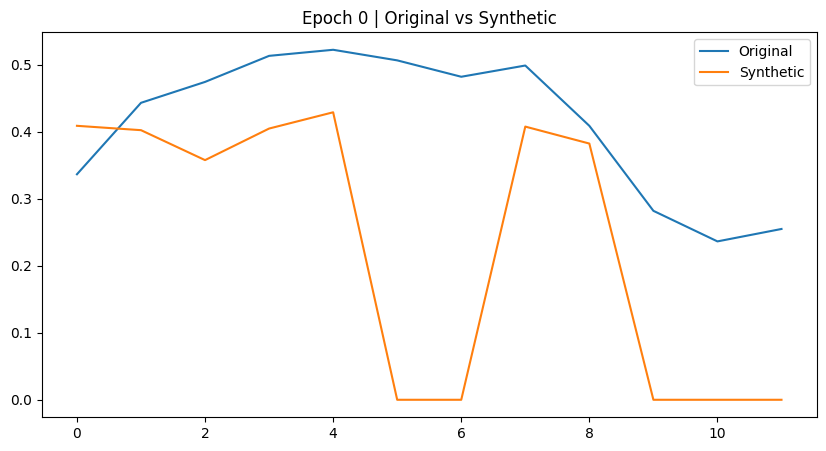

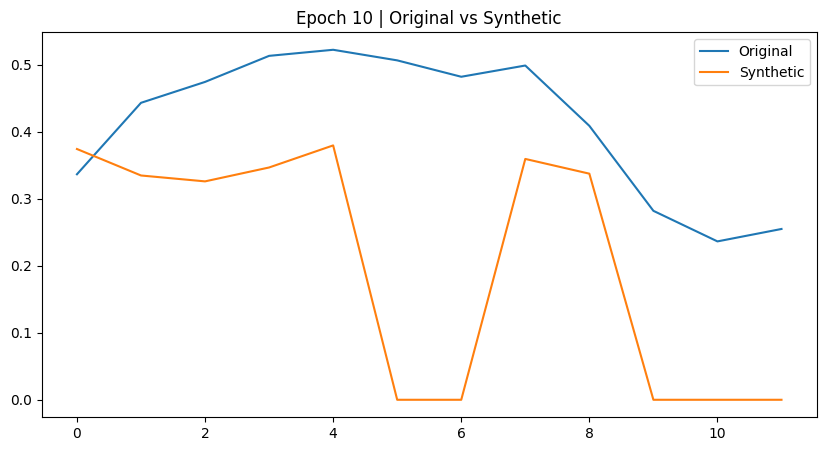

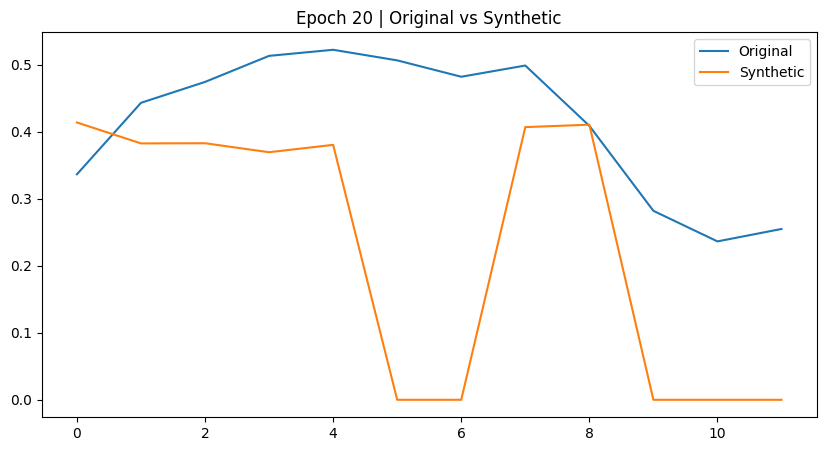

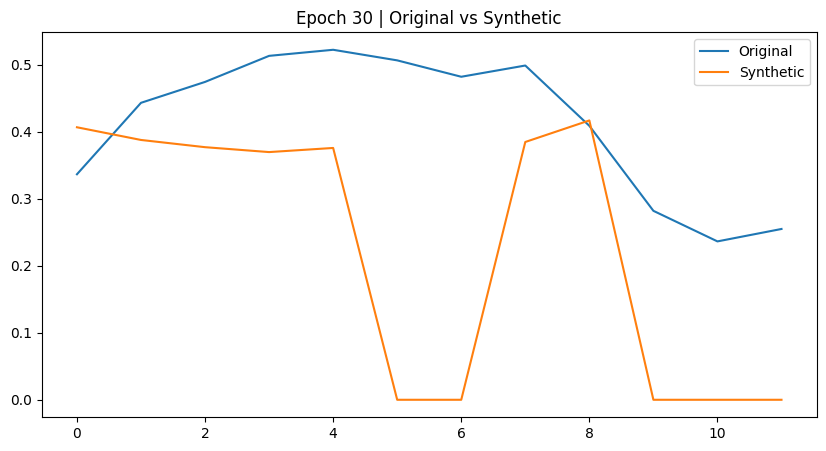

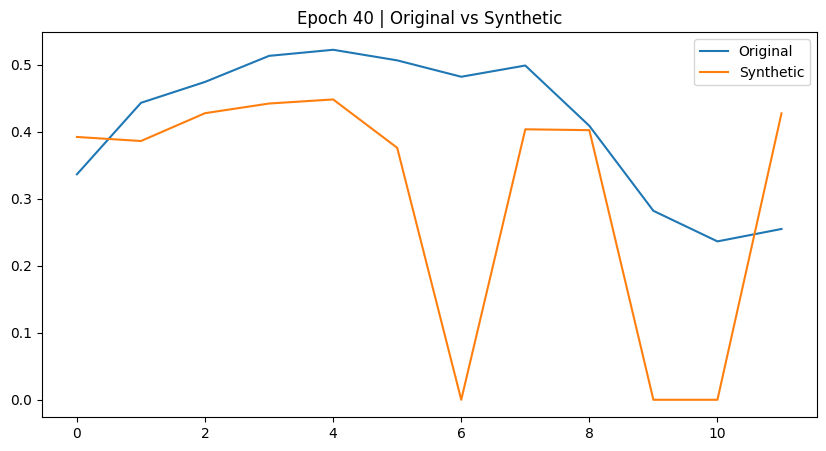

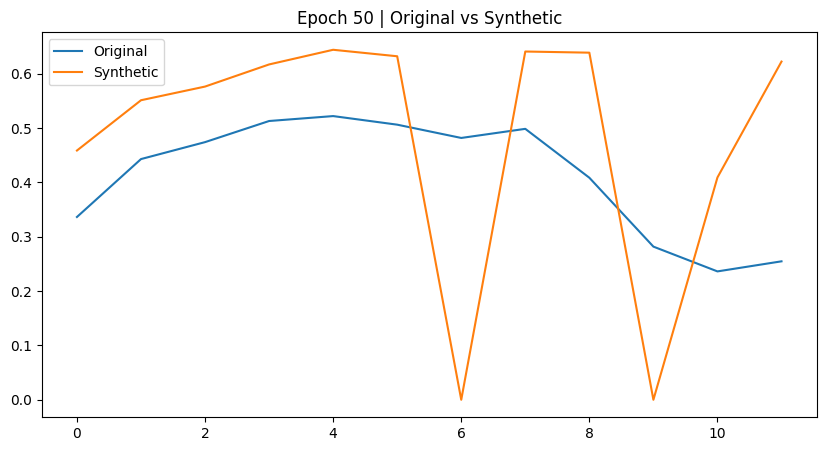

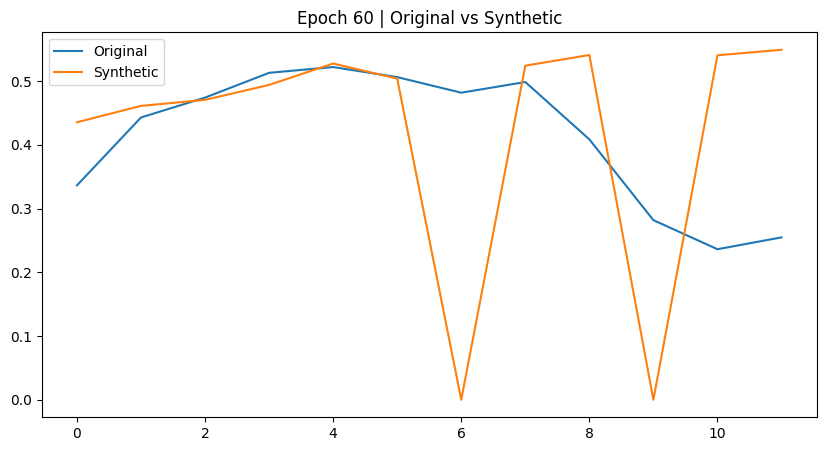

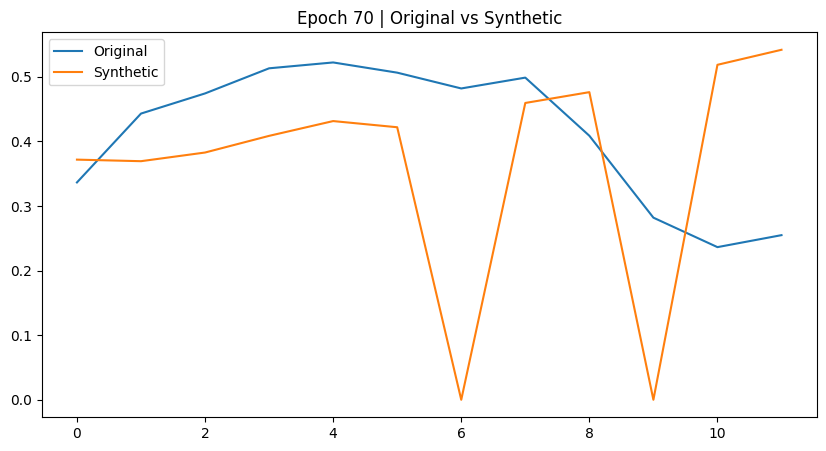

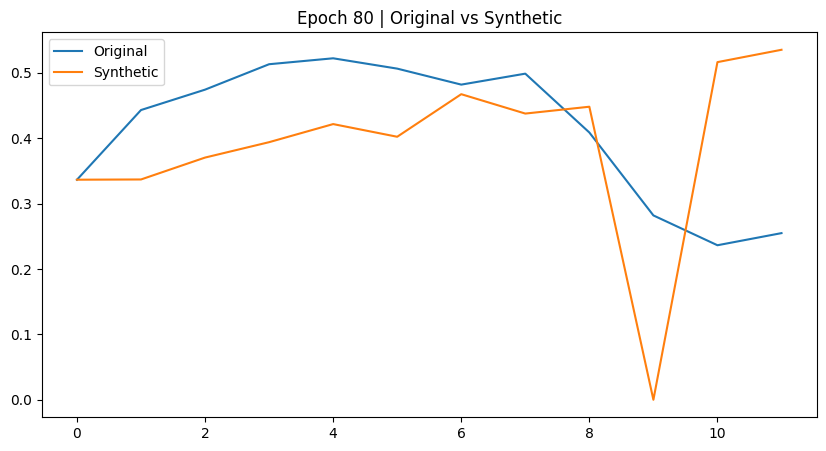

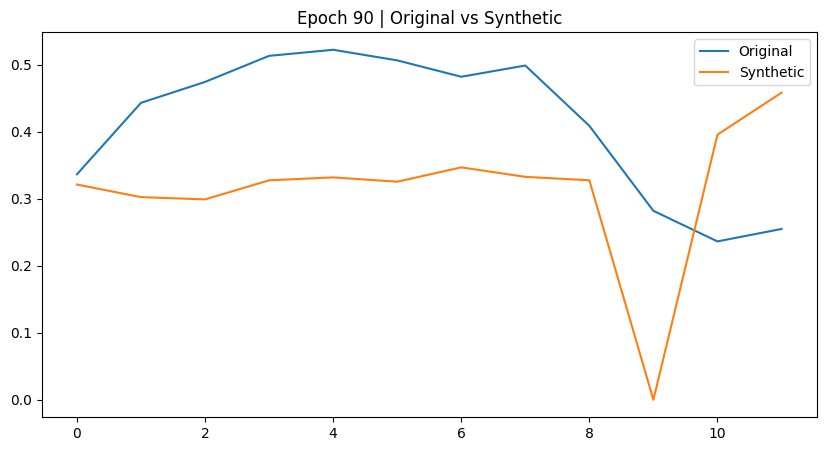

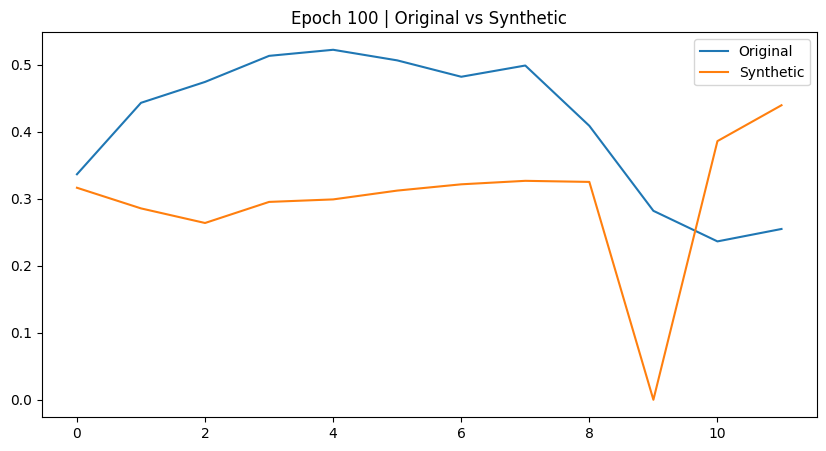

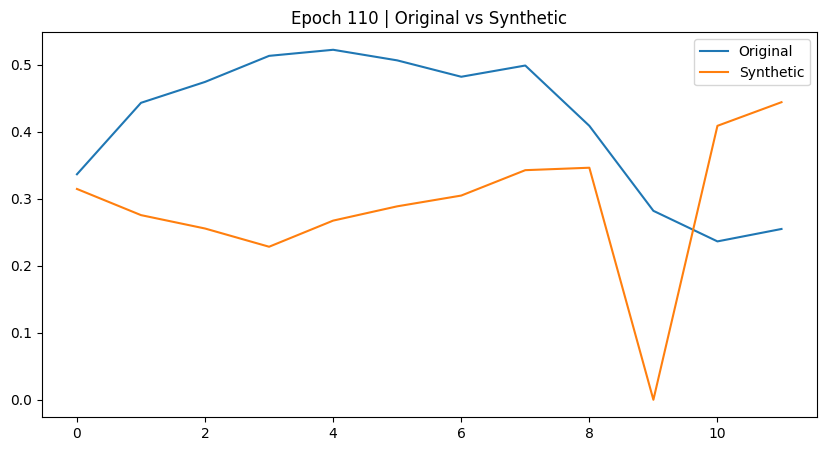

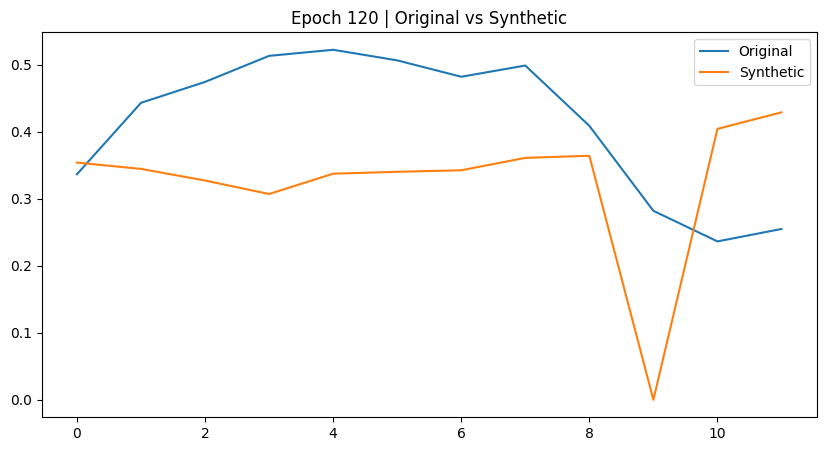

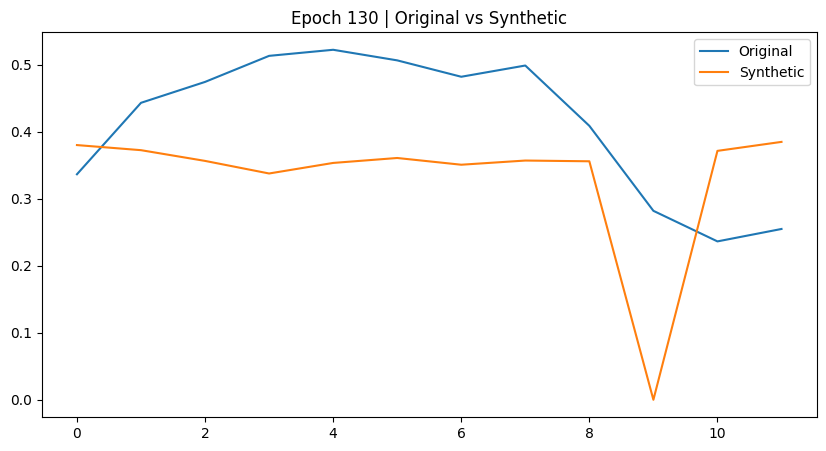

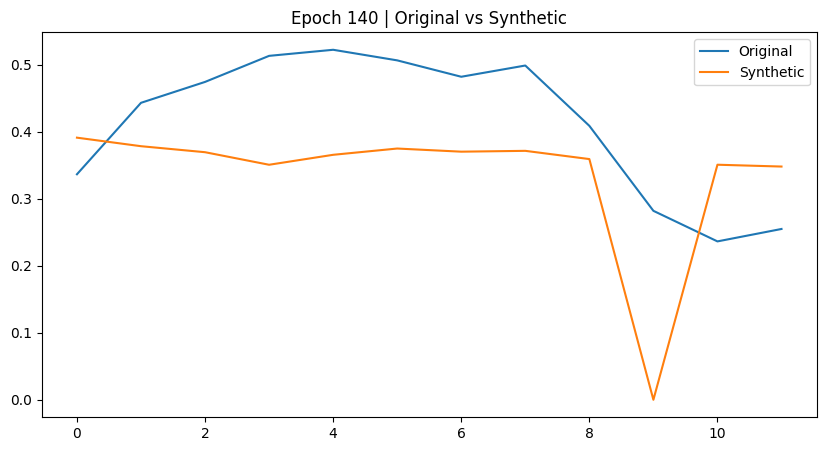

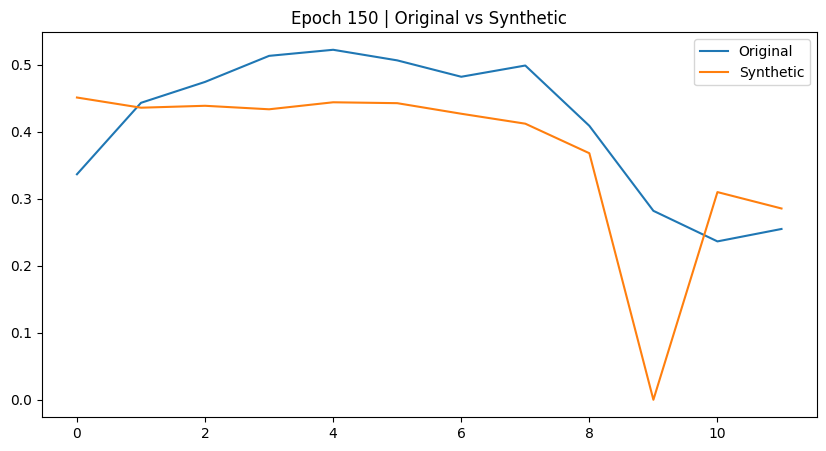

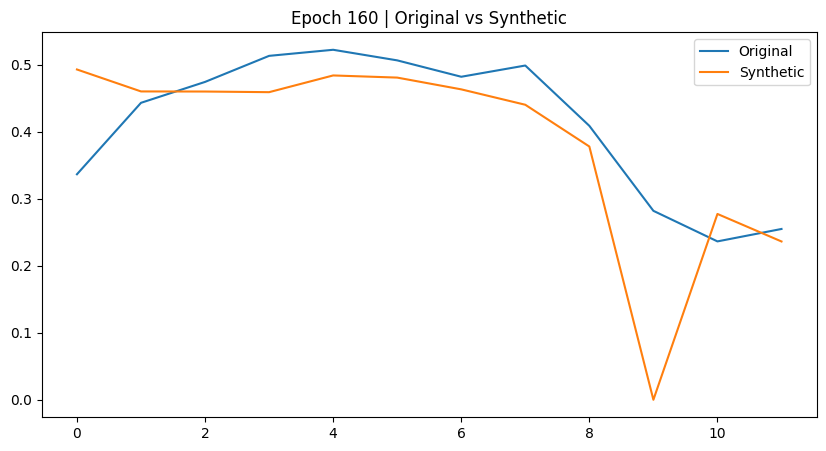

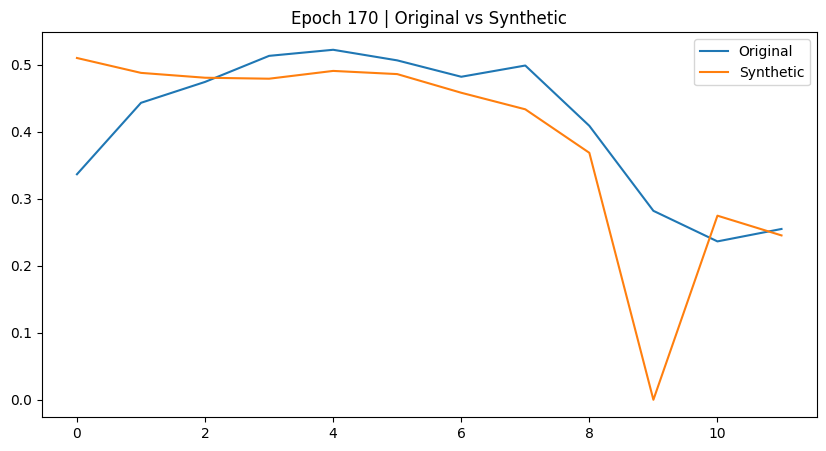

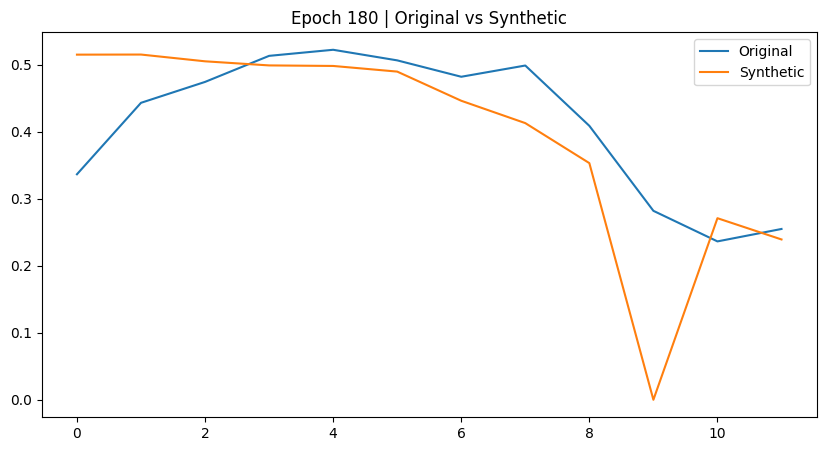

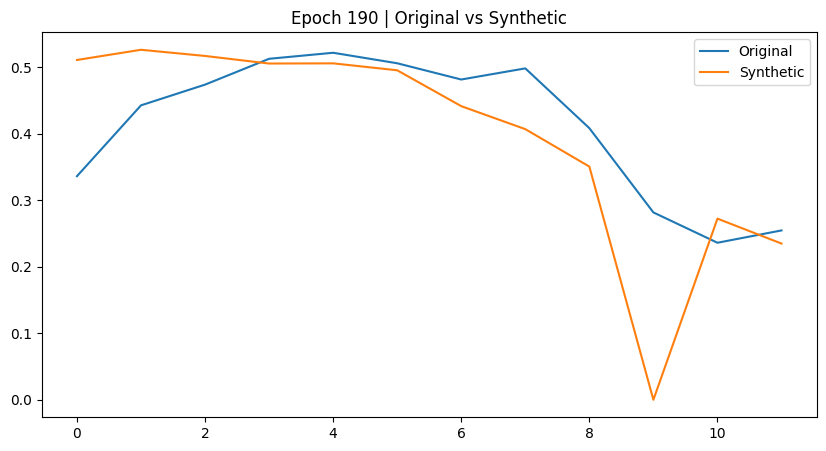

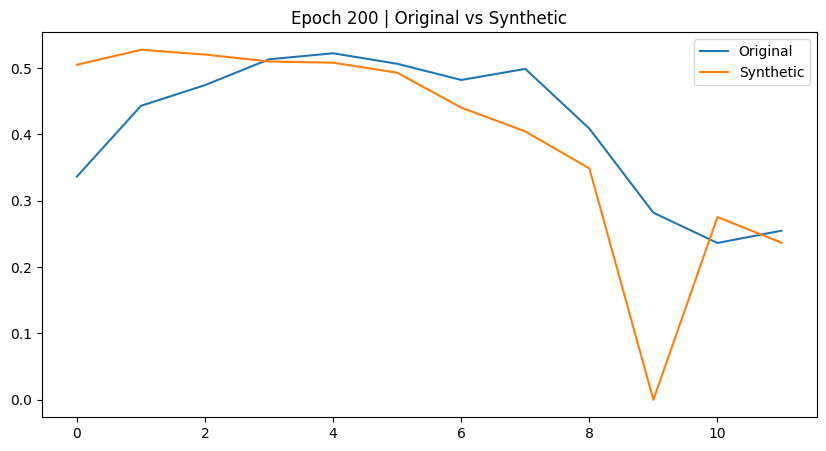

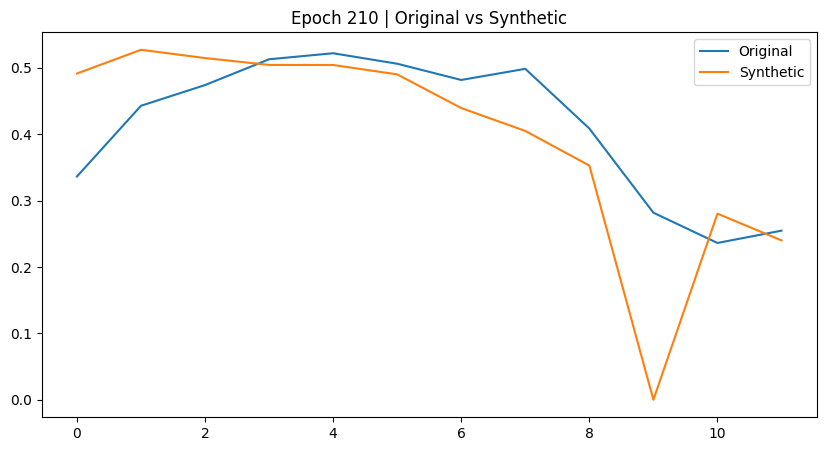

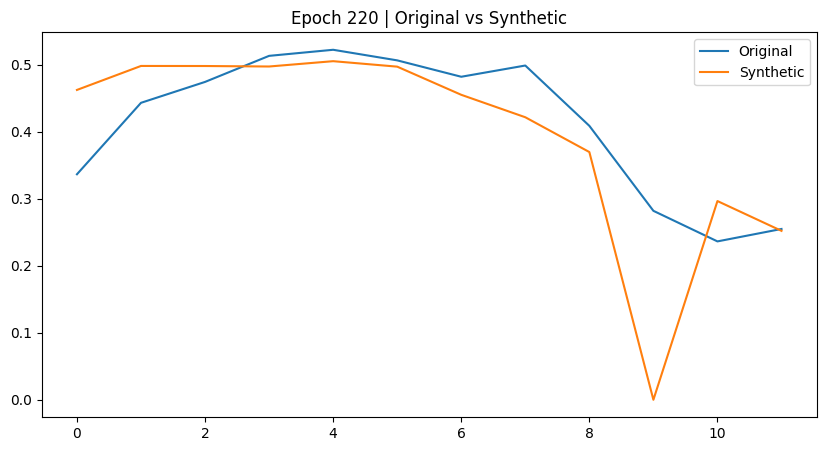

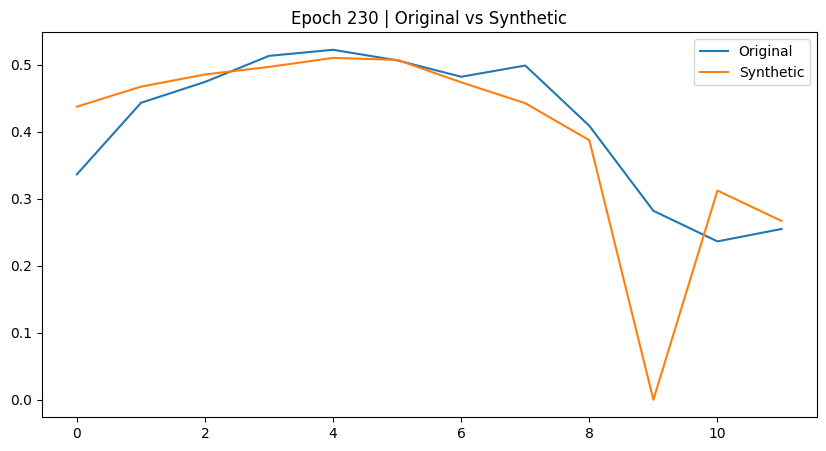

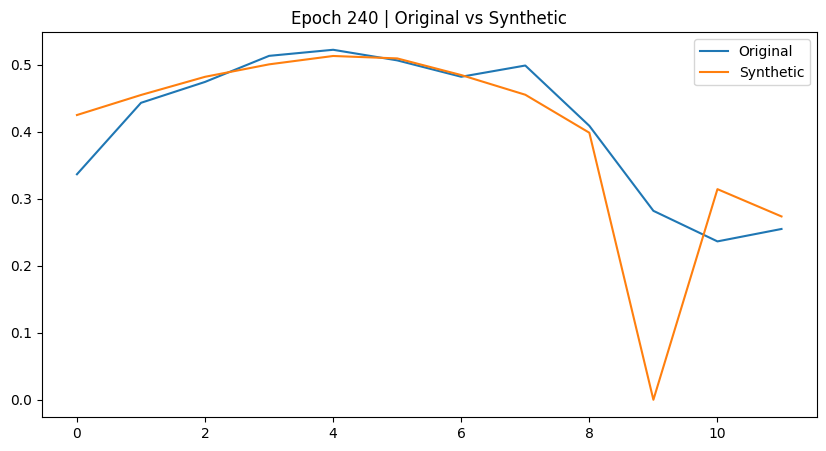

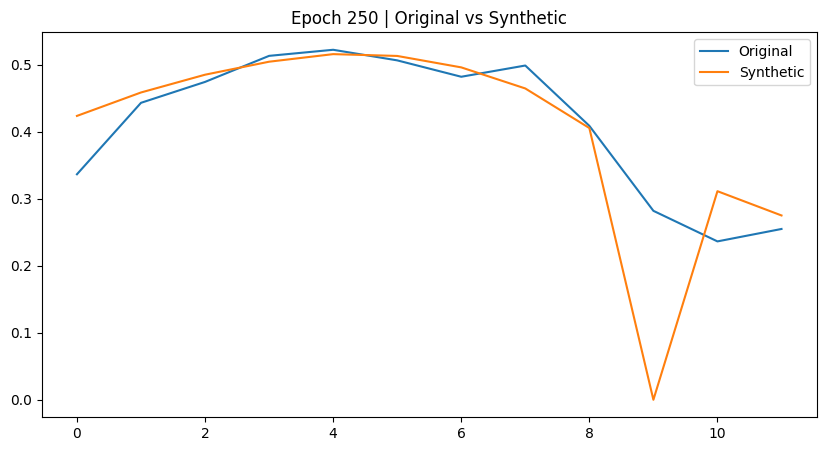

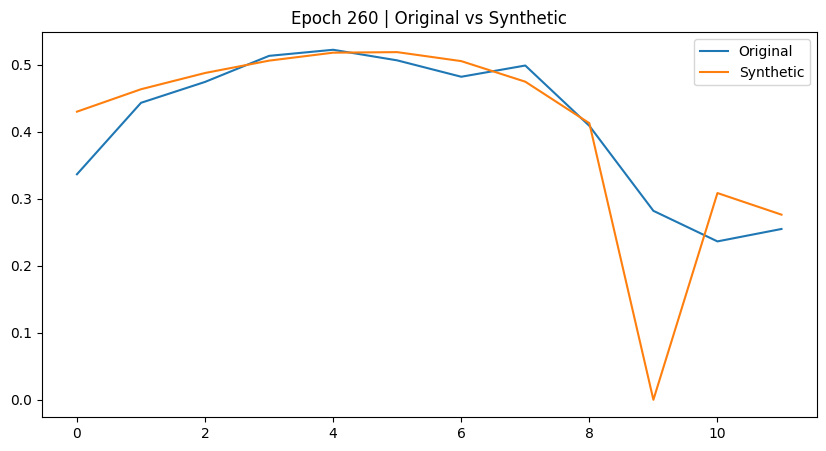

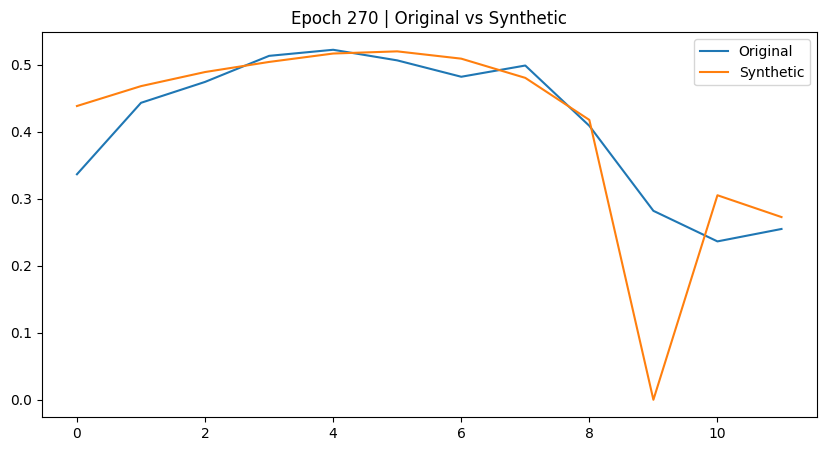

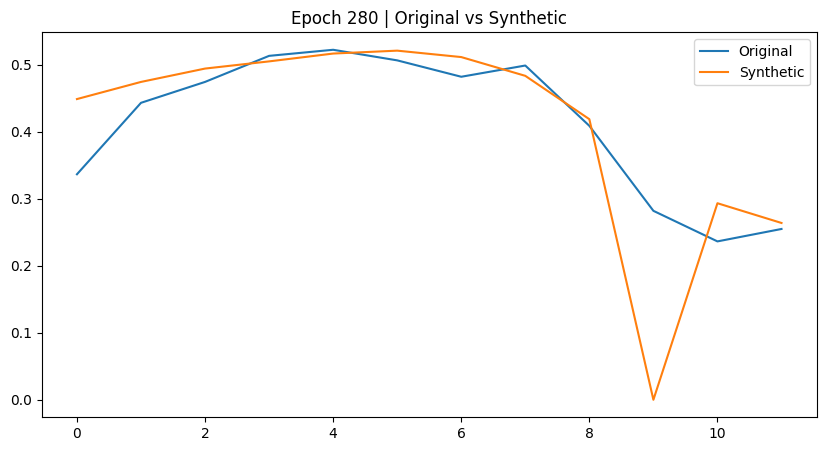

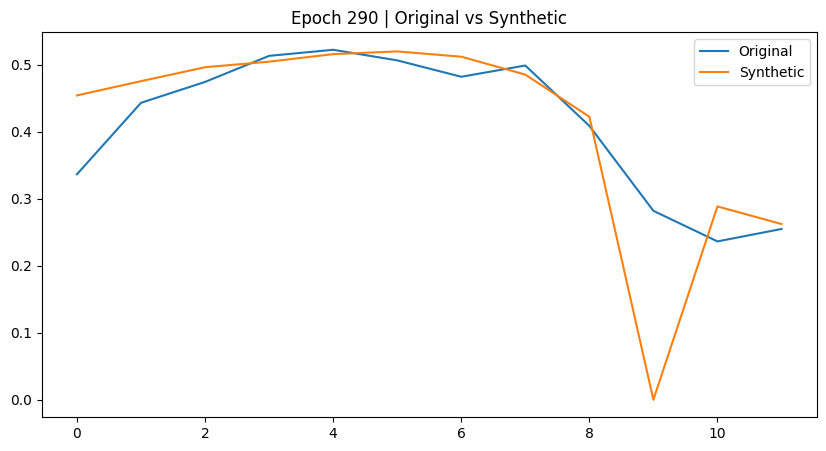

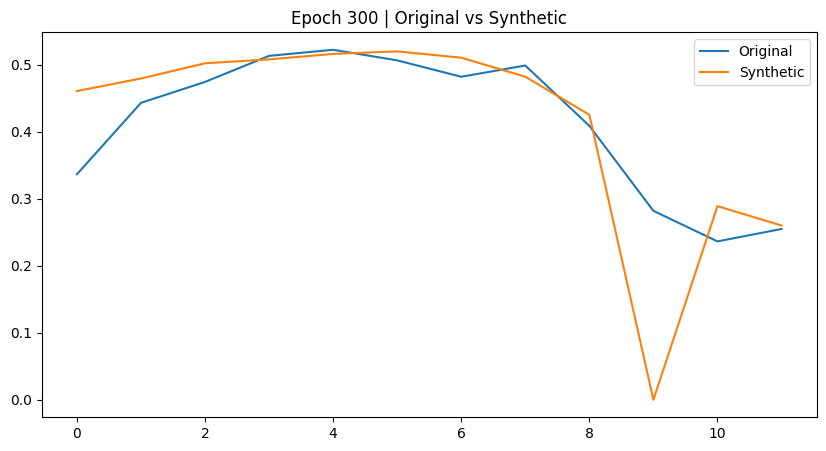

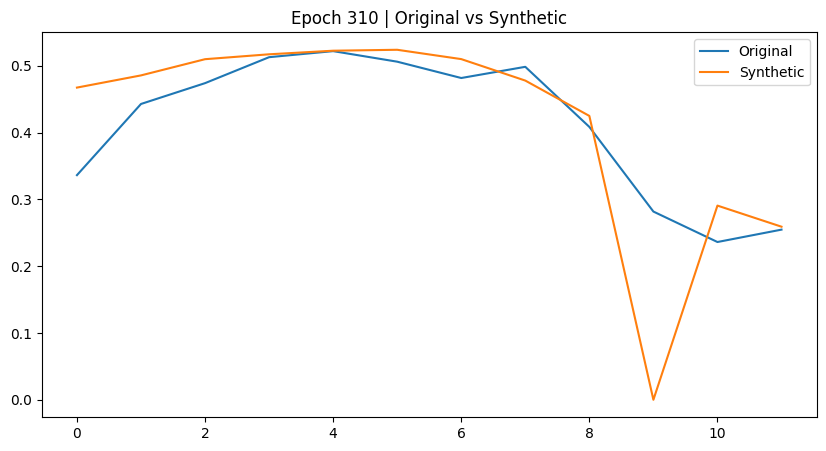

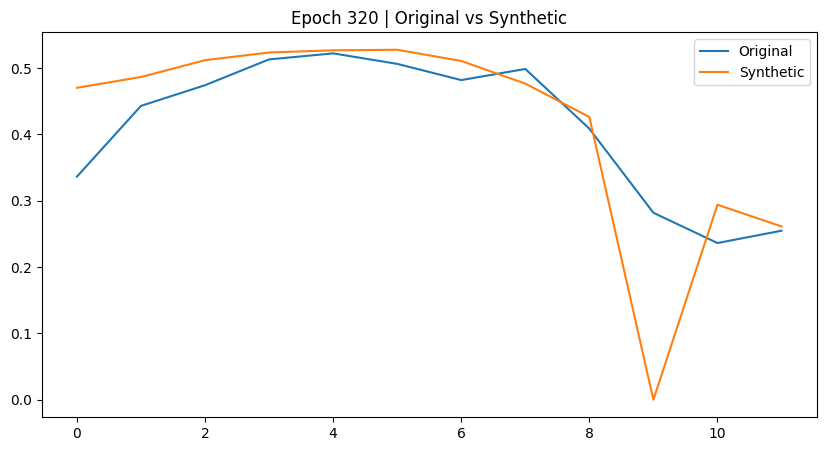

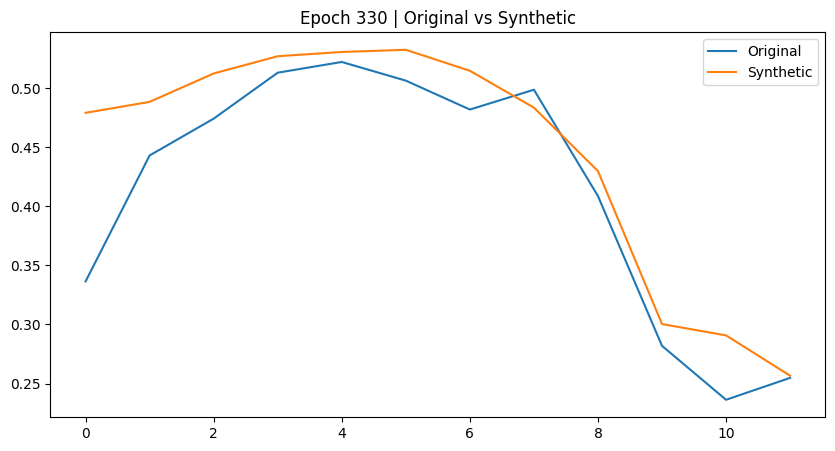

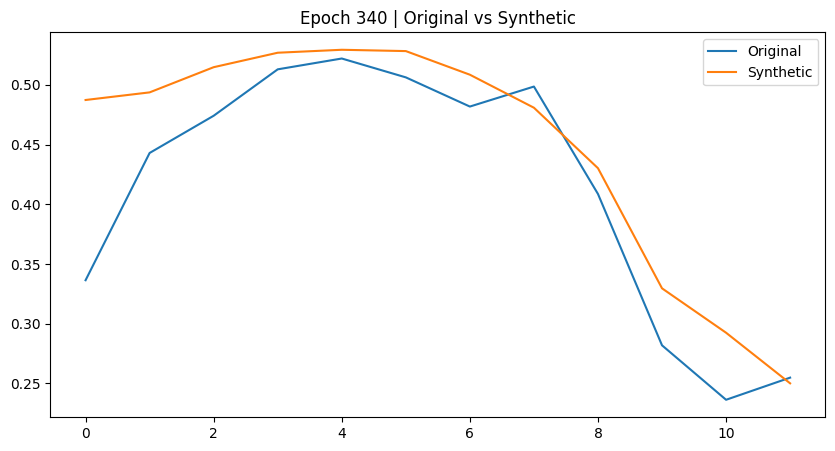

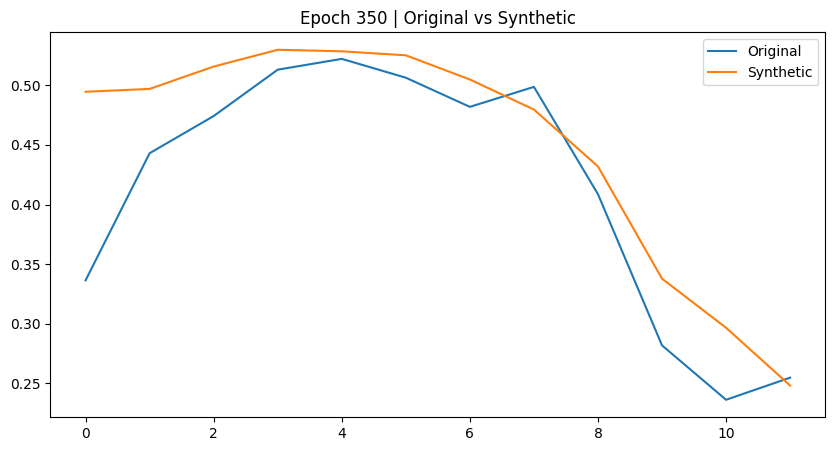

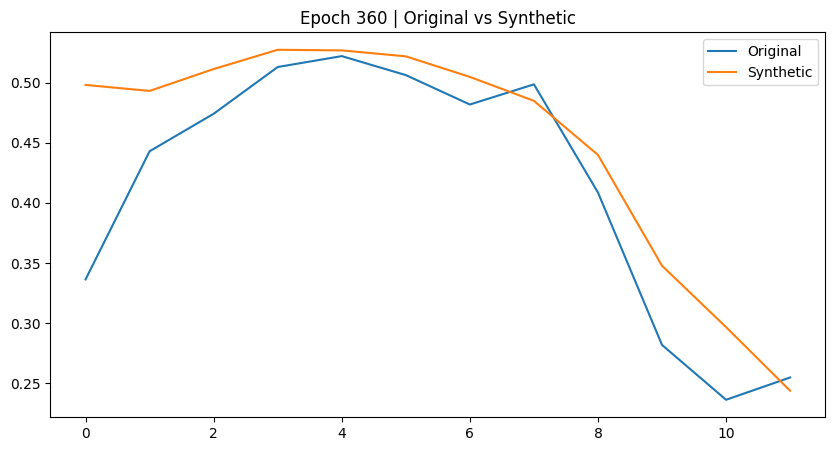

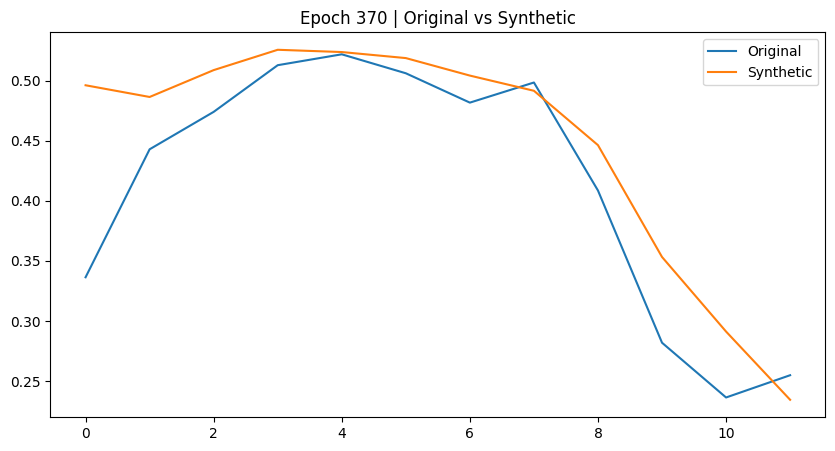

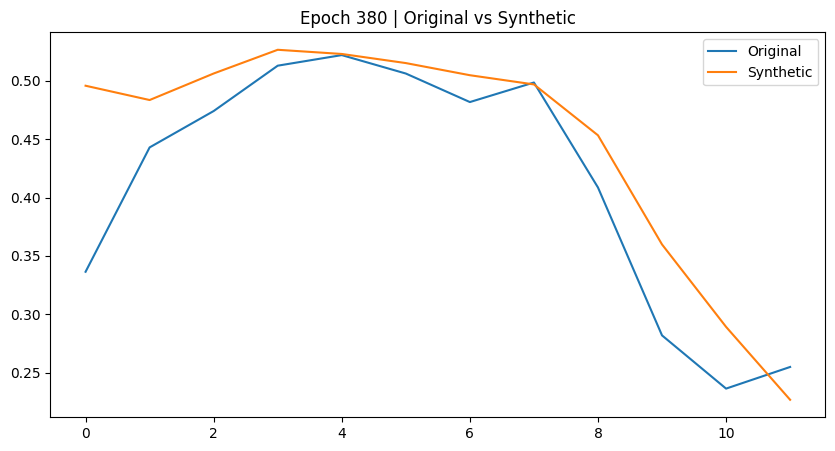

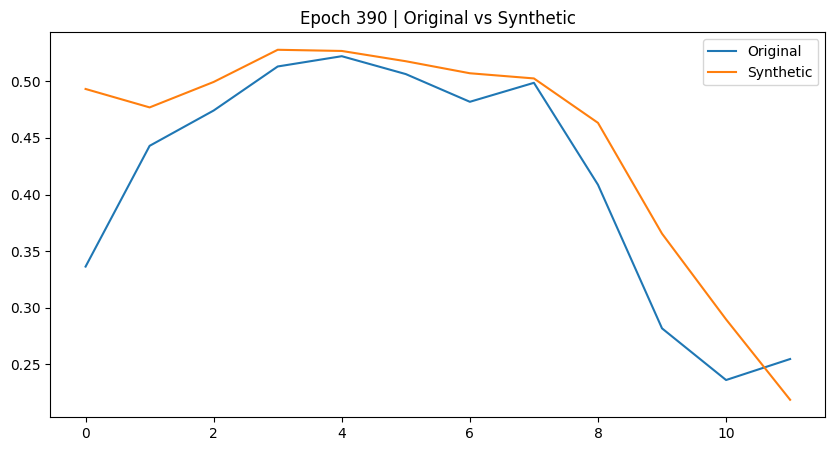

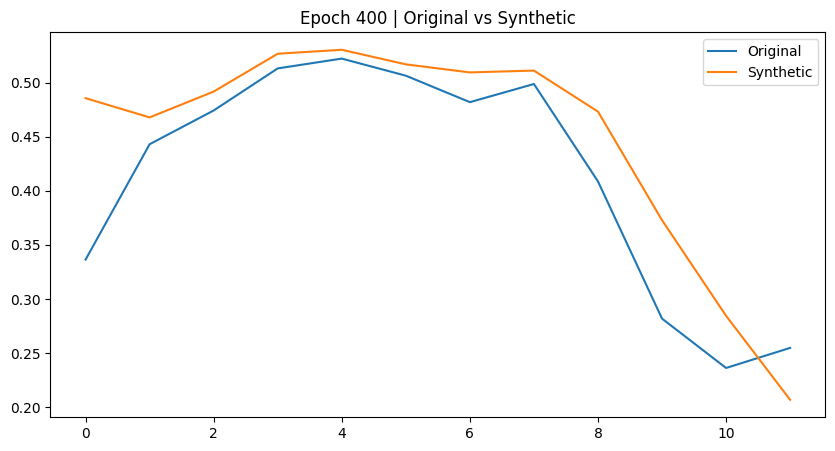

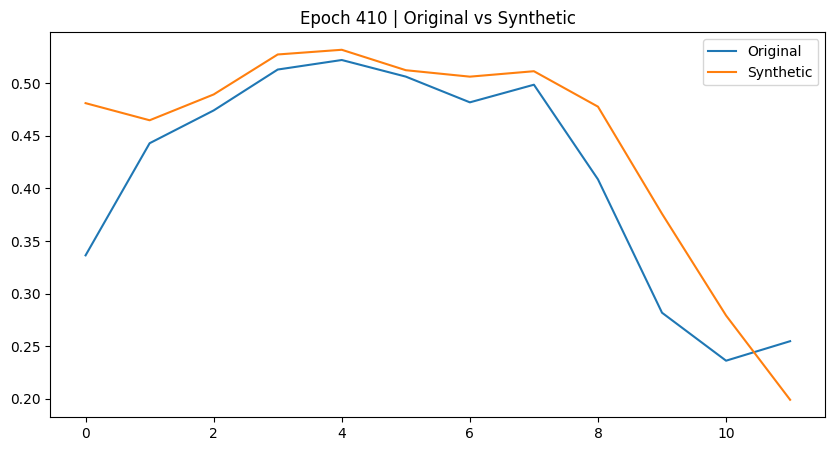

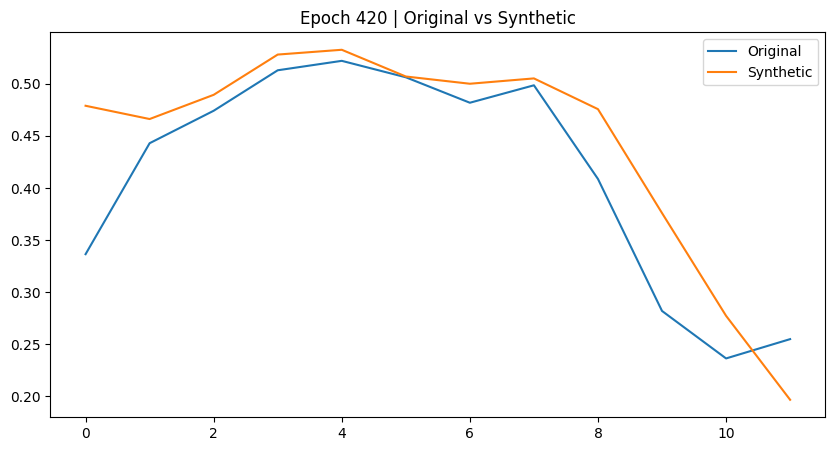

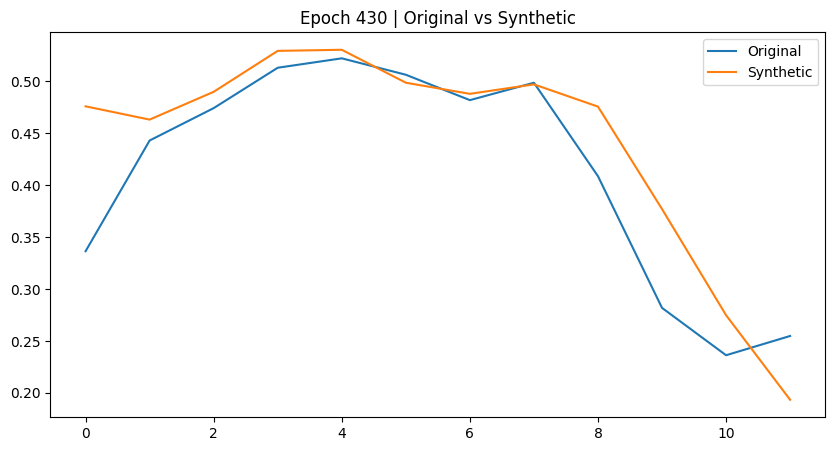

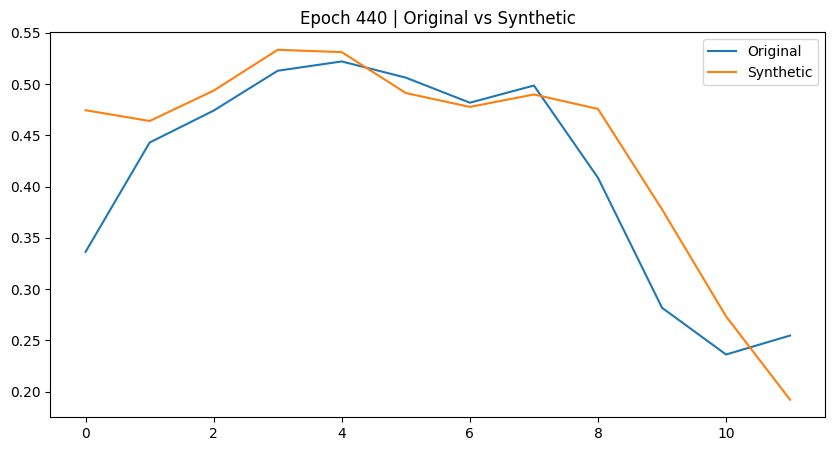

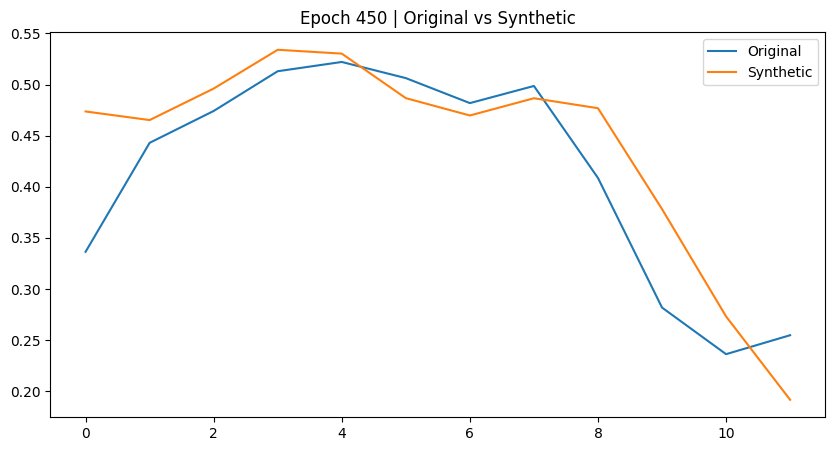

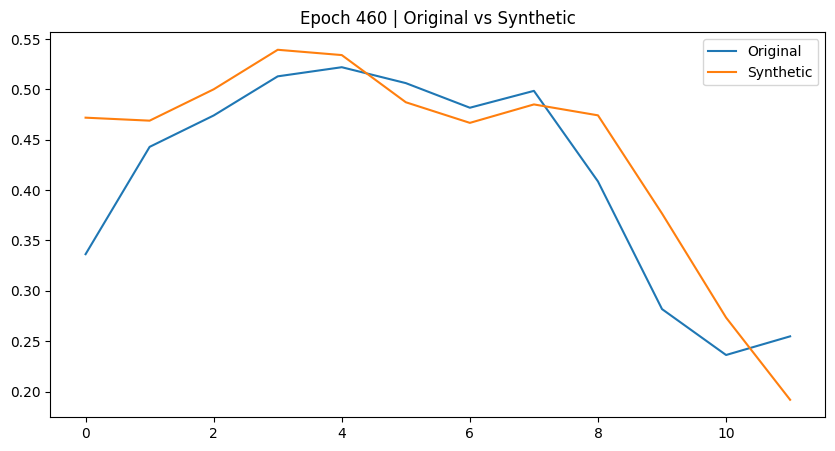

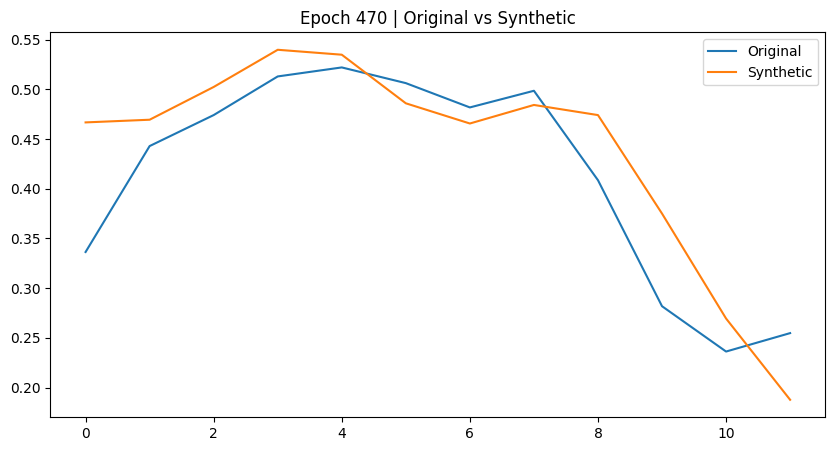

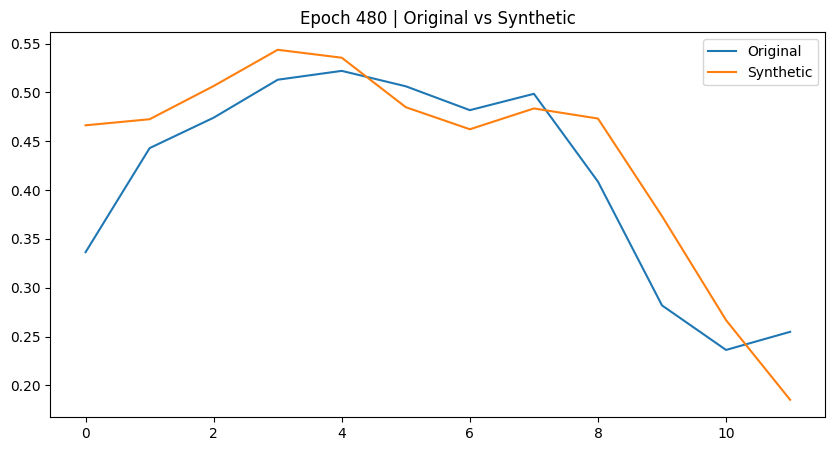

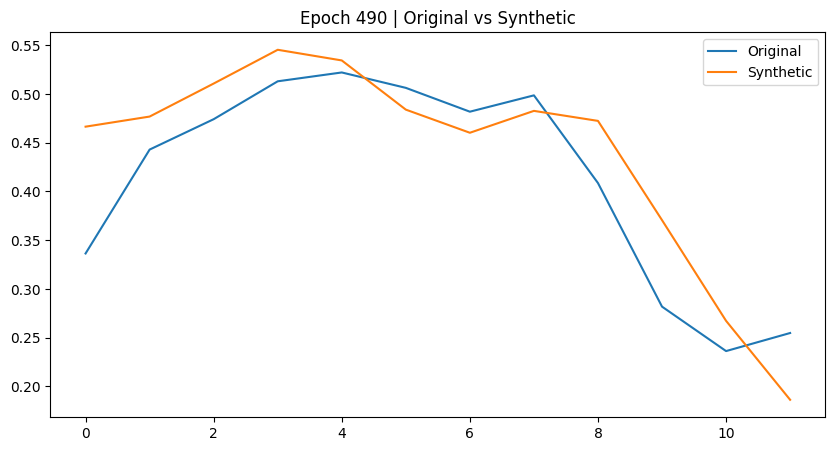

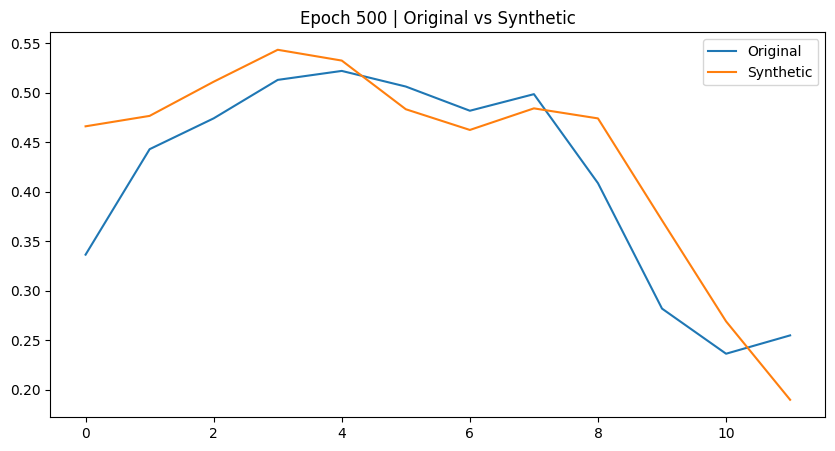

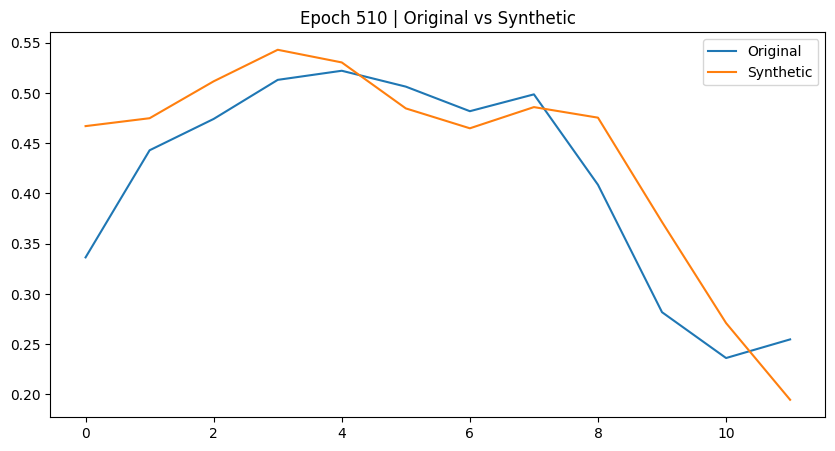

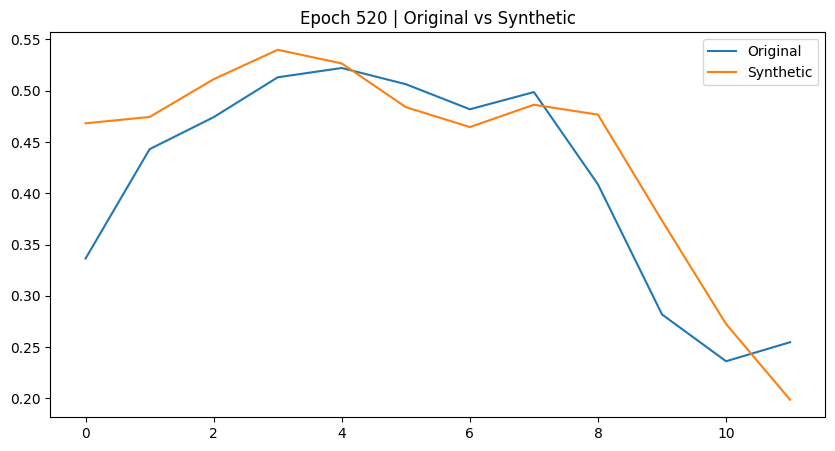

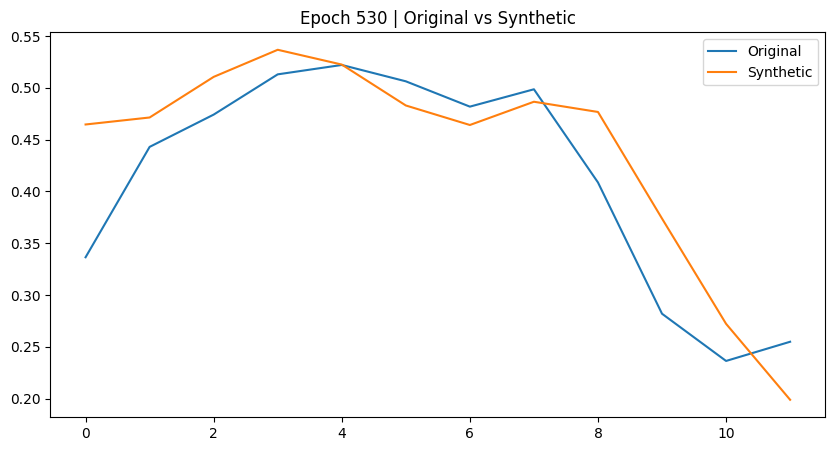

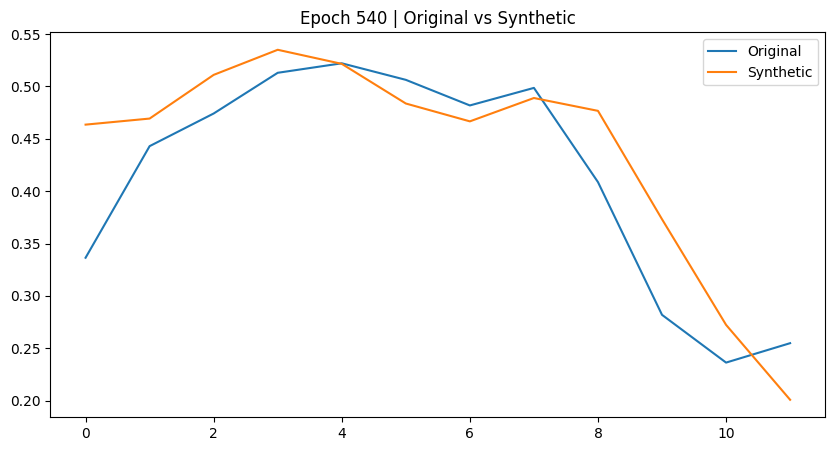

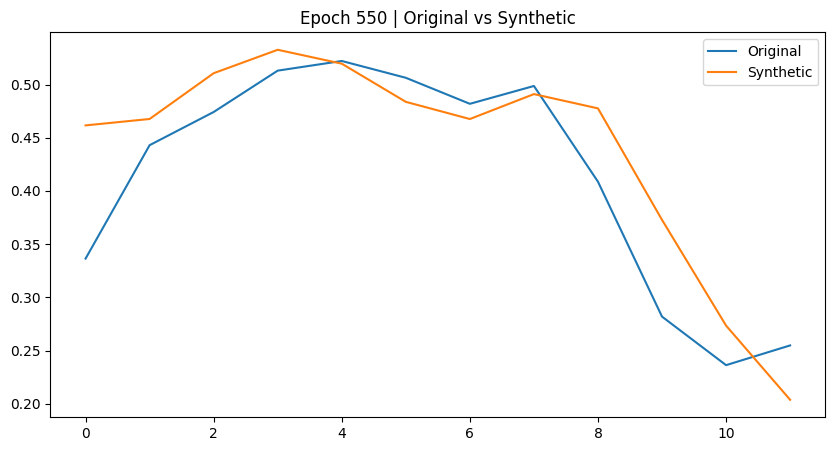

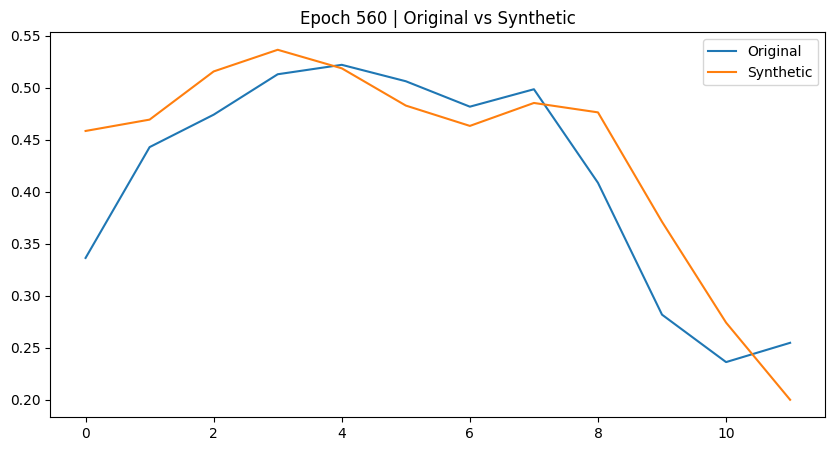

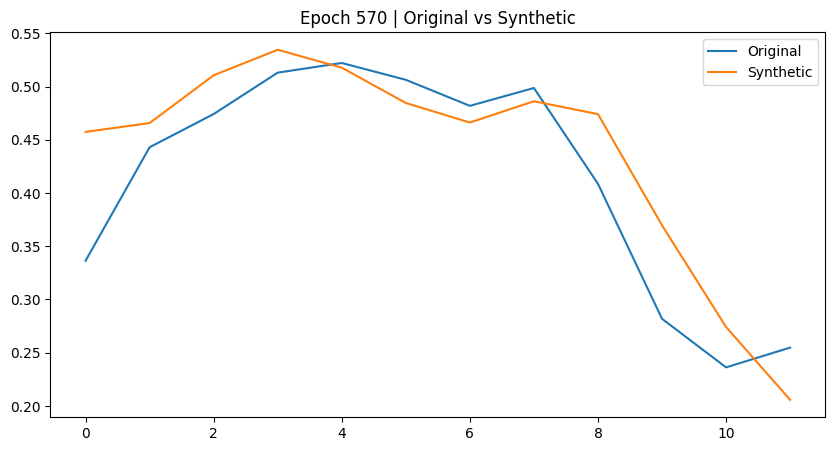

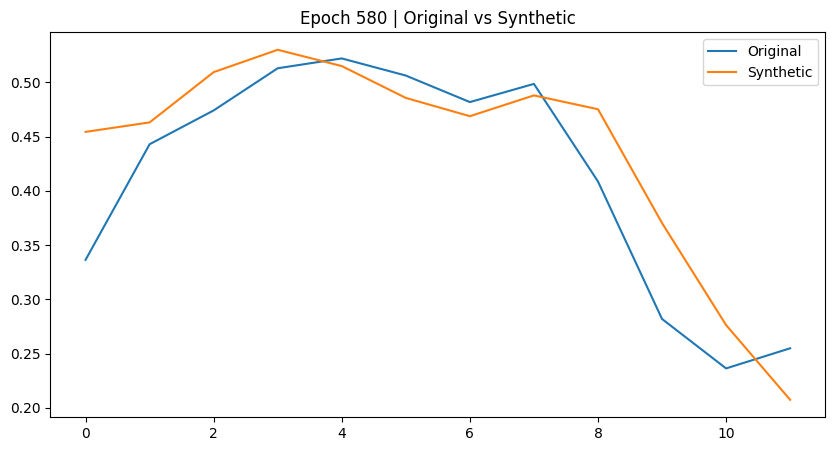

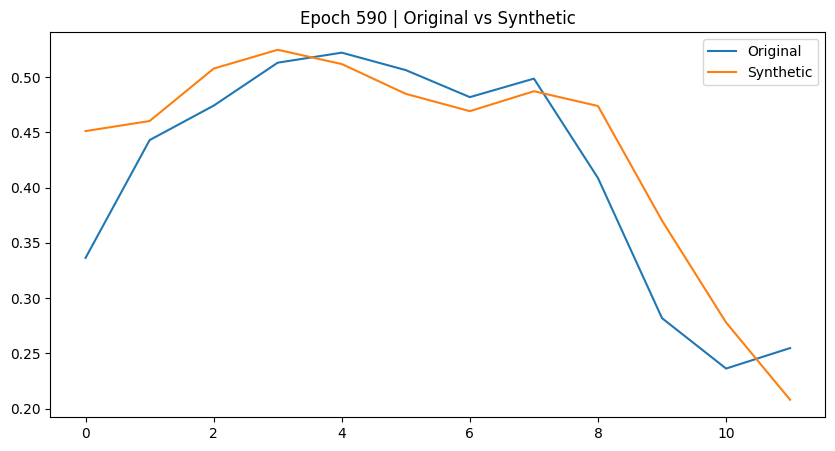

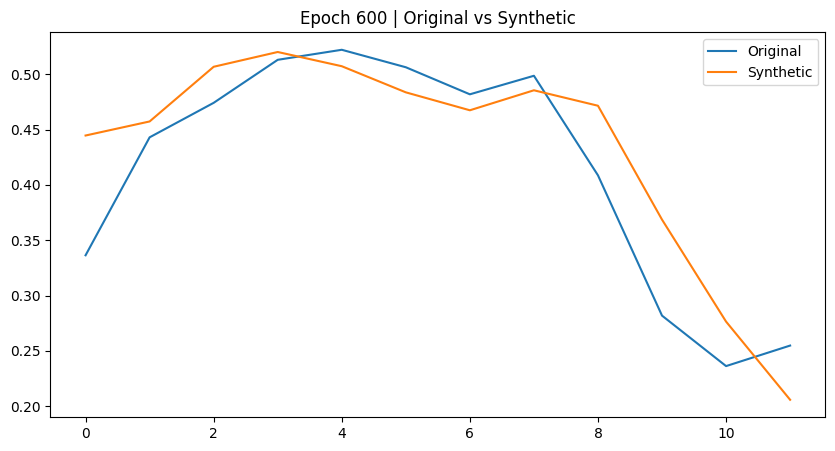

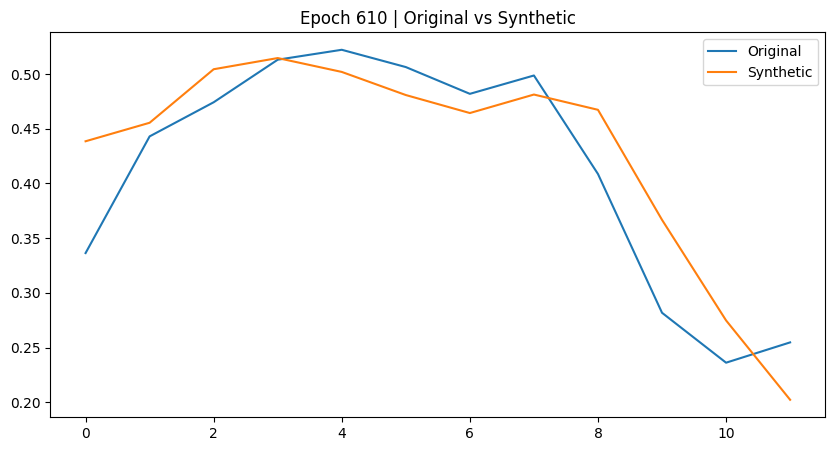

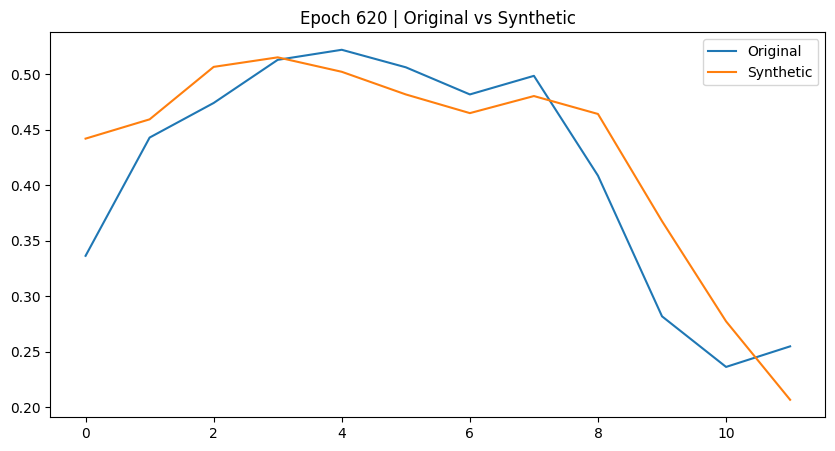

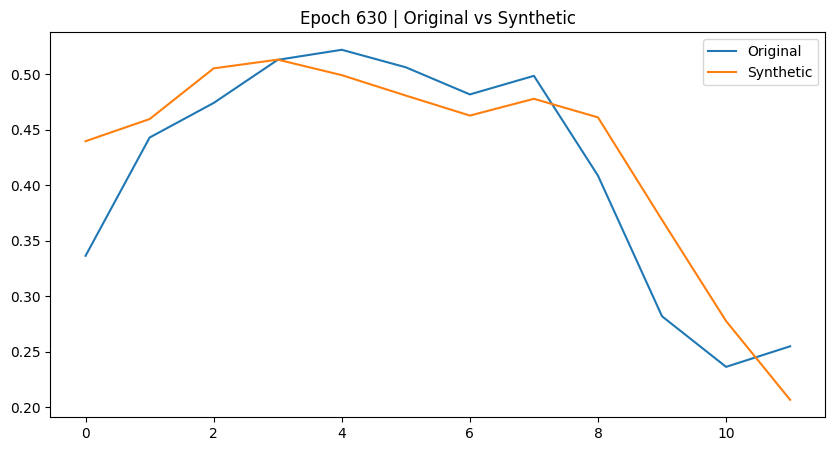

In [16]:
if TEST_EXISTING_MODEL:
    model_path = f"{model_name}_best.pth"
else:
    model_path = f"{model_name}_checkpoint.pth"

    train_losses, val_losses = train_autoencoder(
        model=model,
        hyperparameters=hyperparameters,
        train_loader=train_loader,
        val_loader=val_loader,
        criterion=criterion,
        optimizer=optimizer,
        save_path=model_path
    )

## Evaluate Training

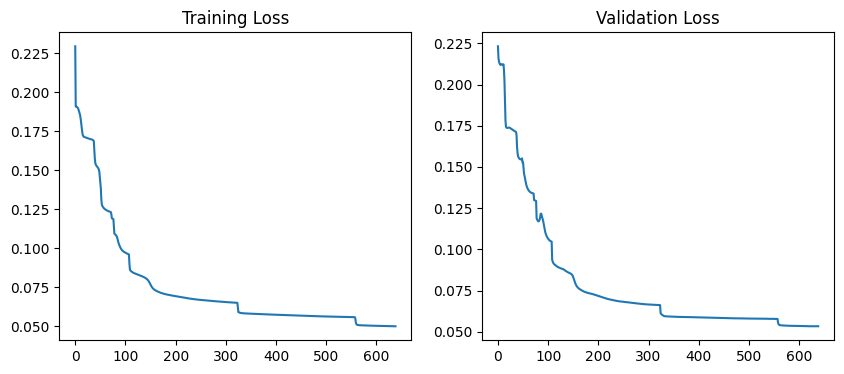

In [17]:
if not TEST_EXISTING_MODEL:
    fig, axs = plt.subplots(1, 2, figsize=(10, 4))

        # Diagramm 1 (oben links)
    axs[0].plot(train_losses, label="BCELoss")
    axs[0].set_title('Training Loss')

    axs[1].plot(val_losses, label="BCELoss")
    axs[1].set_title('Validation Loss')

In [18]:
if not TEST_EXISTING_MODEL:
    smallest_val_loss = val_losses[-11]
    smallest_train_loss = train_losses[-11]
    print(f'Smallest Val Loss: {smallest_val_loss} | Smallest Train Loss: {smallest_train_loss}')

Smallest Val Loss: 0.0532914392566413 | Smallest Train Loss: 0.05001153497660185


## Testing Model

In [19]:
if model_name == "LSTM_AE":
    print("LSMT_AE")
    test_model = LSTMAE().to(hyperparameters['device'])
elif model_name == "FCAE":
    print("FCAE")
    test_model = FCAE(verbose=True).to(hyperparameters['device'])

# load model state dict
test_model.load_state_dict(torch.load(model_path))

LSMT_AE


<All keys matched successfully>

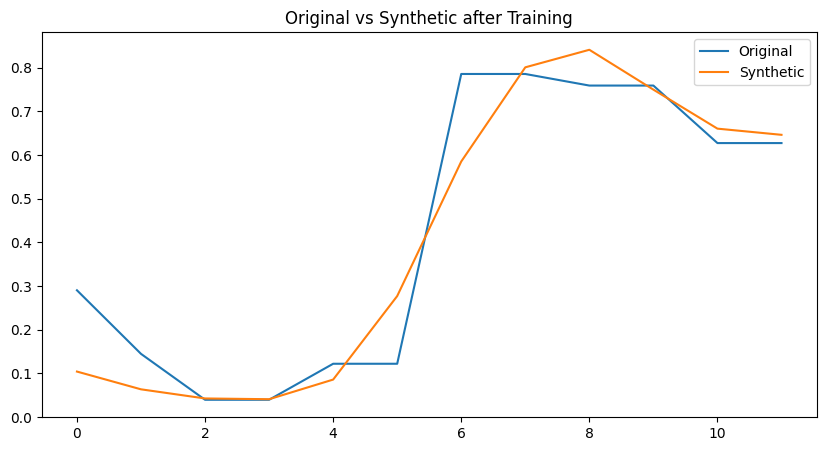

In [60]:
random_idx = random.randint(0, len(train_dataset) - 1)
random_test_sample = torch.tensor(train_dataset[random_idx][0], dtype=torch.float32).unsqueeze(0)
random_test_sample = random_test_sample.float().to(hyperparameters['device'])

test_model.eval()
with torch.inference_mode():
    test_pred = test_model(random_test_sample)

test_plot = dc(random_test_sample.detach().numpy())
pred_plot = dc(test_pred.detach().numpy())

# plot the original and synthetic test data
plt.figure(figsize=(10, 5))
plt.title(f'Original vs Synthetic after Training')
plt.plot(test_plot[0, :, 0], label='Original')
plt.plot(pred_plot[0, :, 0], label='Synthetic')
plt.legend()

In [21]:
test_model.eval()
with torch.inference_mode():
    syn_train = test_model(torch.tensor(train_seq_scaled, dtype=torch.float32))
    syn_test = test_model(torch.tensor(test_seq_scaled, dtype=torch.float32))
    syn_val = test_model(torch.tensor(val_seq_scaled, dtype=torch.float32))

In [22]:
syn_train.shape, syn_test.shape, syn_val.shape

(torch.Size([22797, 12, 5]),
 torch.Size([2840, 12, 5]),
 torch.Size([2841, 12, 5]))

In [23]:
syn_train = syn_train.detach().numpy()
syn_test = syn_test.detach().numpy()
syn_val = syn_val.detach().numpy()

In [24]:
result = np.concatenate([syn_train, syn_val, syn_test], axis=0)

In [25]:
result.shape

(28478, 12, 5)

In [26]:
result_unscaled = scaler.inverse_scale_complete_dataset(result, input_data_is_sequential=True)

In [27]:
no, seq, dim = result_unscaled.shape
data_to_save = result_unscaled.reshape(no, seq*dim)

In [61]:
np.savetxt(f'mitv_{no}_{seq}_{dim}_autoencoder_{model_name}_unscaled.csv', data_to_save, delimiter=',')

### Check on synthetic data

In [29]:
df = pd.DataFrame(result_unscaled.reshape(-1, dim))
df.describe()

,0,1,2,3,4
count,341736.000000,341736.000000,341736.0,341736.0,341736.000000
mean,3219.063232,282.606476,0.0,0.0,33.918293
std,1903.659302,12.232781,0.0,0.0,38.167381
min,0.000000,245.411835,0.0,0.0,0.000000
25%,1305.094727,273.442223,0.0,0.0,0.000000
50%,3642.661865,284.551956,0.0,0.0,9.848331
75%,4834.411865,292.582085,0.0,0.0,78.658363
max,7454.748047,308.811157,0.0,0.0,111.866798


In [30]:
traffic_df.describe()

,traffic_volume,temp,rain_1h,snow_1h,clouds_all
count,28511.00000,28511.000000,28511.000000,28511.000000,28511.000000
mean,3313.74238,282.688768,0.061611,0.000250,42.122795
std,1971.53206,12.367361,0.678185,0.008298,39.316195
min,0.00000,243.390000,0.000000,0.000000,0.000000
25%,1289.00000,273.480000,0.000000,0.000000,1.000000
50%,3507.00000,284.550000,0.000000,0.000000,40.000000
75%,4948.00000,292.790000,0.000000,0.000000,90.000000
max,7280.00000,310.070000,42.000000,0.510000,100.000000
